In [1]:
!pip install rdkit

In [2]:
!pip install rdkit-pypi
!pip install matplotlib

In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [5]:
!pip install torchvision

In [6]:
!pip install pytorch-lightning

In [7]:
!pip install deepchem

In [8]:
!pip install pytorch-lightning

In [9]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
import torch
from torch_geometric.data import Data


In [10]:
import os
import csv
import glob
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data

In [11]:
from typing import List, Tuple
import numpy as np

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer
from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot

In [12]:
# from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
# from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
# from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]

USER_ATOM_TYPE_SET  = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
       'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
       'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
       'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb']
USER_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
USER_HYBRIDIZATION_SET = ["SP", "SP2", "SP3", 'SP3D','SP3D2']

In [15]:
def one_hot_encode(value, allowed_values, include_unknown_set=False):
    """Create a one-hot encoded vector based on allowed values."""
    if include_unknown_set and value not in allowed_values:
        value = allowed_values[-1]

    return [1.0 if v == value else 0.0 for v in allowed_values]


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
from torch_geometric.data import Data

class MolGraphConvFeaturizer:
    def __init__(self, use_edges=True, use_chirality=True, use_partial_charge=True):
        self.use_edges = use_edges
        self.use_chirality = use_chirality
        self.use_partial_charge = use_partial_charge

    def featurize(self, smiles):
        # Convert SMILES to RDKit Mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Compute Gasteiger charges if necessary
        if self.use_partial_charge:
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                return None  # Unable to compute charges for this molecule

        # Get atom features
        atom_features = np.array([self._get_atom_features(atom) for atom in mol.GetAtoms()])

        # Get bond features and indices
        if self.use_edges:
            edge_indices, edge_features = self._get_bond_features(mol)
        else:
            edge_indices, edge_features = None, None

        # Create a graph data object
        graph = Data(x=torch.tensor(atom_features, dtype=torch.float),
                     edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices is not None else None,
                     edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)

        return graph

    def _get_atom_features(self, atom):
        # One-hot encoding of atom type
        atom_type = one_hot_encode(atom.GetSymbol(), USER_ATOM_TYPE_SET, include_unknown_set=True)

        # Formal charge of the atom
        formal_charge = get_atom_formal_charge(atom)

        # One-hot encoding of the atom's hybridization
        hybridization = get_atom_hybridization_one_hot(atom, USER_HYBRIDIZATION_SET, include_unknown_set=True)

        # Aromaticity of the atom
        aromatic = get_atom_is_in_aromatic_one_hot(atom)

        # One-hot encoding of the atom's degree
        degree = get_atom_total_degree_one_hot(atom, USER_TOTAL_DEGREE_SET, include_unknown_set=True)

        # One-hot encoding of the total number of hydrogens connected to the atom
        total_num_Hs = get_atom_total_num_Hs_one_hot(atom, DEFAULT_TOTAL_NUM_Hs_SET, include_unknown_set=True)

        # Concatenating all the features
        atom_feat = np.concatenate([
            atom_type, formal_charge, hybridization, aromatic, degree, total_num_Hs
        ])

        if self.use_chirality:
            chirality = get_atom_chirality_one_hot(atom)
            atom_feat = np.concatenate([atom_feat, chirality])

        if self.use_partial_charge:
            partial_charge = get_atom_partial_charge(atom)
            atom_feat = np.concatenate([atom_feat, partial_charge])

        return atom_feat

    def _get_bond_features(self, mol):
        # Initialize lists for source and destination atoms of each bond
        src, dest, bond_features = [], [], []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            src += [start, end]
            dest += [end, start]

            # Extract bond features and duplicate for both bond directions
            bond_feat = self._extract_bond_features(bond)
            bond_features += [bond_feat, bond_feat]

        edge_indices = [src, dest]
        #print("edge_indices : ",edge_indices)
        #print("bond_features : ",bond_features)
        return edge_indices, bond_features
        
    def _extract_bond_features(self, bond):
        """
        Extract bond features from a RDKit bond object.
        """

        # One-hot encoding of bond type
        bond_type = one_hot_encode(bond.GetBondTypeAsDouble(), [1.0, 1.5, 2.0, 3.0], include_unknown_set=True)

        # Whether the bond is in the same ring
        same_ring = [1.0] if bond.IsInRing() else [0.0]

        # Whether the bond is conjugated
        conjugated = [1.0] if bond.GetIsConjugated() else [0.0]

        # One-hot encoding of bond stereo configuration
        stereo = one_hot_encode(bond.GetStereo(), [Chem.rdchem.BondStereo.STEREONONE, 
                                                   Chem.rdchem.BondStereo.STEREOANY, 
                                                   Chem.rdchem.BondStereo.STEREOZ, 
                                                   Chem.rdchem.BondStereo.STEREOE], 
                                include_unknown_set=True)

        # Concatenate all bond features
        bond_feat = np.concatenate([bond_type, same_ring, conjugated, stereo])

        return bond_feat        


In [17]:
# Example usage
#featurizer = MolGraphConvFeaturizer()
#graph = featurizer.featurize('CCO')  # Example SMILES string
#print(type(graph))
#print((graph))

In [18]:
## Assuming graphs[0] is a torch_geometric.data.Data object from your graphs list

## Print node features
#print("Len of graph:", len(graph))
#print("Node Features:")
#for i, node_feature in enumerate(graph.x):
#    print(f"Node {i}: {node_feature}")

## Print edge pairs and edge features
#print("\nEdge Pairs and Features:")
#for i, edge in enumerate(graph.edge_index.t()):
#    src, dest = edge[0].item(), edge[1].item()
#    edge_feature = graph.edge_attr[i]
#    print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


In [19]:
#graph.is_directed()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_graph(data):
    # Create a networkx graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(data.num_nodes):
        G.add_node(i)

    # Add edges to the graph
    edge_index = data.edge_index.t().cpu().numpy()
    for edge in edge_index:
        src, dest = edge[0], edge[1]
        G.add_edge(src, dest)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()
#visualize_graph(graph)

In [21]:
# Load the data 
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-41-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test50k.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test25k.txt", header=None, names=['SMILES'])


In [22]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [23]:
# Define a function to convert a SMILES string to a graph data object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    # Get bond features and adjacency information
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [(start, end), (end, start)]
        edge_feature = [bond.GetBondTypeAsDouble()]
        edge_features += [edge_feature, edge_feature]  # add twice for both directions

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create a graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [24]:
def read_smiles_df_check(smiles_df):
    graphs = []
    invalid_indices = []
    for idx, smiles in enumerate(smiles_df['SMILES']):
        graph = smiles_to_graph(smiles)
        if graph:
            graphs.append(graph)
        else:
            print("Invalid graph :", idx,smiles)
            invalid_indices.append(idx)
    return graphs, invalid_indices

graphs, invalid_indices = read_smiles_df_check(smiles_df)
print(f"Number of valid graphs: {len(graphs)}")
print(f"Indices of invalid SMILES: {invalid_indices}")

Number of valid graphs: 50001
Indices of invalid SMILES: []


In [25]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 50001


In [26]:
# Initialize the featurizer
featurizer = MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)

# Featurize SMILES strings and track invalid entries
graphs = []
invalid_indices = []
for idx, smiles in enumerate(smiles_df['SMILES']):
    print(idx)
    graph = featurizer.featurize(smiles)
    graphs.append(graph)    
    
#    try:
#        graph = featurizer.featurize(smiles)
#        graphs.append(graph)
#    except Exception as e:
#        print(f"Invalid SMILES at index {idx}: {smiles} (Error: {e})")
#        invalid_indices.append(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


C:\Users\Malli\AppData\Local\Temp\ipykernel_13800\3029635957.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)


30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
29

1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100


3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751


5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453


6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156


8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859


10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
1047

11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
1185

13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
1324

14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
1462

15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
1607

17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
1752

18809
18810
18811
18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
18823
18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
18872
18873
18874
18875
18876
18877
18878
18879
18880
18881
18882
18883
18884
18885
18886
18887
18888
18889
18890
18891
18892
18893
18894
18895
18896
18897
18898
18899
18900
18901
18902
18903
18904
18905
18906
18907
18908
18909
18910
18911
18912
18913
18914
18915
18916
18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
1897

20252
20253
20254
20255
20256
20257
20258
20259
20260
20261
20262
20263
20264
20265
20266
20267
20268
20269
20270
20271
20272
20273
20274
20275
20276
20277
20278
20279
20280
20281
20282
20283
20284
20285
20286
20287
20288
20289
20290
20291
20292
20293
20294
20295
20296
20297
20298
20299
20300
20301
20302
20303
20304
20305
20306
20307
20308
20309
20310
20311
20312
20313
20314
20315
20316
20317
20318
20319
20320
20321
20322
20323
20324
20325
20326
20327
20328
20329
20330
20331
20332
20333
20334
20335
20336
20337
20338
20339
20340
20341
20342
20343
20344
20345
20346
20347
20348
20349
20350
20351
20352
20353
20354
20355
20356
20357
20358
20359
20360
20361
20362
20363
20364
20365
20366
20367
20368
20369
20370
20371
20372
20373
20374
20375
20376
20377
20378
20379
20380
20381
20382
20383
20384
20385
20386
20387
20388
20389
20390
20391
20392
20393
20394
20395
20396
20397
20398
20399
20400
20401
20402
20403
20404
20405
20406
20407
20408
20409
20410
20411
20412
20413
20414
20415
20416
20417
2041

21706
21707
21708
21709
21710
21711
21712
21713
21714
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21737
21738
21739
21740
21741
21742
21743
21744
21745
21746
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757
21758
21759
21760
21761
21762
21763
21764
21765
21766
21767
21768
21769
21770
21771
21772
21773
21774
21775
21776
21777
21778
21779
21780
21781
21782
21783
21784
21785
21786
21787
21788
21789
21790
21791
21792
21793
21794
21795
21796
21797
21798
21799
21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849
21850
21851
21852
21853
21854
21855
21856
21857
21858
21859
21860
21861
21862
21863
21864
21865
21866
21867
21868
21869
21870
21871
2187

23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
23125
23126
23127
23128
23129
23130
23131
23132
23133
23134
23135
23136
23137
23138
23139
23140
23141
23142
23143
23144
23145
23146
23147
23148
23149
23150
23151
23152
23153
23154
23155
23156
23157
23158
23159
23160
23161
23162
23163
23164
23165
23166
23167
23168
23169
23170
23171
23172
23173
23174
23175
23176
23177
23178
23179
23180
23181
23182
23183
23184
23185
23186
23187
23188
23189
23190
23191
23192
23193
23194
23195
23196
23197
23198
23199
23200
23201
23202
23203
23204
23205
23206
23207
23208
23209
23210
23211
23212
23213
23214
23215
23216
23217
23218
23219
23220
23221
23222
23223
23224
23225
23226
23227
23228
23229
23230
23231
23232
23233
23234
23235
23236
23237
23238
23239
23240
23241
23242
23243
23244
23245
23246
2324

24471
24472
24473
24474
24475
24476
24477
24478
24479
24480
24481
24482
24483
24484
24485
24486
24487
24488
24489
24490
24491
24492
24493
24494
24495
24496
24497
24498
24499
24500
24501
24502
24503
24504
24505
24506
24507
24508
24509
24510
24511
24512
24513
24514
24515
24516
24517
24518
24519
24520
24521
24522
24523
24524
24525
24526
24527
24528
24529
24530
24531
24532
24533
24534
24535
24536
24537
24538
24539
24540
24541
24542
24543
24544
24545
24546
24547
24548
24549
24550
24551
24552
24553
24554
24555
24556
24557
24558
24559
24560
24561
24562
24563
24564
24565
24566
24567
24568
24569
24570
24571
24572
24573
24574
24575
24576
24577
24578
24579
24580
24581
24582
24583
24584
24585
24586
24587
24588
24589
24590
24591
24592
24593
24594
24595
24596
24597
24598
24599
24600
24601
24602
24603
24604
24605
24606
24607
24608
24609
24610
24611
24612
24613
24614
24615
24616
24617
24618
24619
24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631
24632
24633
24634
24635
24636
2463

25914
25915
25916
25917
25918
25919
25920
25921
25922
25923
25924
25925
25926
25927
25928
25929
25930
25931
25932
25933
25934
25935
25936
25937
25938
25939
25940
25941
25942
25943
25944
25945
25946
25947
25948
25949
25950
25951
25952
25953
25954
25955
25956
25957
25958
25959
25960
25961
25962
25963
25964
25965
25966
25967
25968
25969
25970
25971
25972
25973
25974
25975
25976
25977
25978
25979
25980
25981
25982
25983
25984
25985
25986
25987
25988
25989
25990
25991
25992
25993
25994
25995
25996
25997
25998
25999
26000
26001
26002
26003
26004
26005
26006
26007
26008
26009
26010
26011
26012
26013
26014
26015
26016
26017
26018
26019
26020
26021
26022
26023
26024
26025
26026
26027
26028
26029
26030
26031
26032
26033
26034
26035
26036
26037
26038
26039
26040
26041
26042
26043
26044
26045
26046
26047
26048
26049
26050
26051
26052
26053
26054
26055
26056
26057
26058
26059
26060
26061
26062
26063
26064
26065
26066
26067
26068
26069
26070
26071
26072
26073
26074
26075
26076
26077
26078
26079
2608

27328
27329
27330
27331
27332
27333
27334
27335
27336
27337
27338
27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
27410
27411
27412
27413
27414
27415
27416
27417
27418
27419
27420
27421
27422
27423
27424
27425
27426
27427
27428
27429
27430
27431
27432
27433
27434
27435
27436
27437
27438
27439
27440
27441
27442
27443
27444
27445
27446
27447
27448
27449
27450
27451
27452
27453
27454
27455
27456
27457
27458
27459
27460
27461
27462
27463
27464
27465
27466
27467
27468
27469
27470
27471
27472
27473
27474
27475
27476
27477
27478
27479
27480
27481
27482
27483
27484
27485
27486
27487
27488
27489
27490
27491
27492
27493
2749

28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
28792
28793
28794
28795
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811
28812
28813
28814
28815
28816
28817
28818
28819
28820
28821
28822
28823
28824
28825
28826
28827
28828
28829
28830
28831
28832
28833
28834
28835
28836
28837
28838
28839
28840
28841
28842
28843
28844
28845
28846
28847
28848
28849
28850
28851
28852
28853
28854
28855
28856
28857
28858
28859
28860
28861
28862
28863
28864
28865
28866
28867
28868
28869
28870
28871
28872
28873
28874
28875
28876
28877
28878
28879
28880
28881
28882
28883
28884
28885
28886
28887
28888
28889
28890
28891
28892
28893
28894
28895
28896
28897
28898
28899
28900
28901
28902
28903
28904
28905
28906
28907
28908
28909
28910
28911
28912
28913
28914
28915
28916
28917
28918
28919
28920
28921
28922
28923
28924
28925
28926
28927
28928
28929
28930
28931
28932
28933
28934
28935
28936
28937
28938
2893

30233
30234
30235
30236
30237
30238
30239
30240
30241
30242
30243
30244
30245
30246
30247
30248
30249
30250
30251
30252
30253
30254
30255
30256
30257
30258
30259
30260
30261
30262
30263
30264
30265
30266
30267
30268
30269
30270
30271
30272
30273
30274
30275
30276
30277
30278
30279
30280
30281
30282
30283
30284
30285
30286
30287
30288
30289
30290
30291
30292
30293
30294
30295
30296
30297
30298
30299
30300
30301
30302
30303
30304
30305
30306
30307
30308
30309
30310
30311
30312
30313
30314
30315
30316
30317
30318
30319
30320
30321
30322
30323
30324
30325
30326
30327
30328
30329
30330
30331
30332
30333
30334
30335
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349
30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360
30361
30362
30363
30364
30365
30366
30367
30368
30369
30370
30371
30372
30373
30374
30375
30376
30377
30378
30379
30380
30381
30382
30383
30384
30385
30386
30387
30388
30389
30390
30391
30392
30393
30394
30395
30396
30397
30398
3039

31599
31600
31601
31602
31603
31604
31605
31606
31607
31608
31609
31610
31611
31612
31613
31614
31615
31616
31617
31618
31619
31620
31621
31622
31623
31624
31625
31626
31627
31628
31629
31630
31631
31632
31633
31634
31635
31636
31637
31638
31639
31640
31641
31642
31643
31644
31645
31646
31647
31648
31649
31650
31651
31652
31653
31654
31655
31656
31657
31658
31659
31660
31661
31662
31663
31664
31665
31666
31667
31668
31669
31670
31671
31672
31673
31674
31675
31676
31677
31678
31679
31680
31681
31682
31683
31684
31685
31686
31687
31688
31689
31690
31691
31692
31693
31694
31695
31696
31697
31698
31699
31700
31701
31702
31703
31704
31705
31706
31707
31708
31709
31710
31711
31712
31713
31714
31715
31716
31717
31718
31719
31720
31721
31722
31723
31724
31725
31726
31727
31728
31729
31730
31731
31732
31733
31734
31735
31736
31737
31738
31739
31740
31741
31742
31743
31744
31745
31746
31747
31748
31749
31750
31751
31752
31753
31754
31755
31756
31757
31758
31759
31760
31761
31762
31763
31764
3176

33024
33025
33026
33027
33028
33029
33030
33031
33032
33033
33034
33035
33036
33037
33038
33039
33040
33041
33042
33043
33044
33045
33046
33047
33048
33049
33050
33051
33052
33053
33054
33055
33056
33057
33058
33059
33060
33061
33062
33063
33064
33065
33066
33067
33068
33069
33070
33071
33072
33073
33074
33075
33076
33077
33078
33079
33080
33081
33082
33083
33084
33085
33086
33087
33088
33089
33090
33091
33092
33093
33094
33095
33096
33097
33098
33099
33100
33101
33102
33103
33104
33105
33106
33107
33108
33109
33110
33111
33112
33113
33114
33115
33116
33117
33118
33119
33120
33121
33122
33123
33124
33125
33126
33127
33128
33129
33130
33131
33132
33133
33134
33135
33136
33137
33138
33139
33140
33141
33142
33143
33144
33145
33146
33147
33148
33149
33150
33151
33152
33153
33154
33155
33156
33157
33158
33159
33160
33161
33162
33163
33164
33165
33166
33167
33168
33169
33170
33171
33172
33173
33174
33175
33176
33177
33178
33179
33180
33181
33182
33183
33184
33185
33186
33187
33188
33189
3319

34435
34436
34437
34438
34439
34440
34441
34442
34443
34444
34445
34446
34447
34448
34449
34450
34451
34452
34453
34454
34455
34456
34457
34458
34459
34460
34461
34462
34463
34464
34465
34466
34467
34468
34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
34480
34481
34482
34483
34484
34485
34486
34487
34488
34489
34490
34491
34492
34493
34494
34495
34496
34497
34498
34499
34500
34501
34502
34503
34504
34505
34506
34507
34508
34509
34510
34511
34512
34513
34514
34515
34516
34517
34518
34519
34520
34521
34522
34523
34524
34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535
34536
34537
34538
34539
34540
34541
34542
34543
34544
34545
34546
34547
34548
34549
34550
34551
34552
34553
34554
34555
34556
34557
34558
34559
34560
34561
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574
34575
34576
34577
34578
34579
34580
34581
34582
34583
34584
34585
34586
34587
34588
34589
34590
34591
34592
34593
34594
34595
34596
34597
34598
34599
34600
3460

35858
35859
35860
35861
35862
35863
35864
35865
35866
35867
35868
35869
35870
35871
35872
35873
35874
35875
35876
35877
35878
35879
35880
35881
35882
35883
35884
35885
35886
35887
35888
35889
35890
35891
35892
35893
35894
35895
35896
35897
35898
35899
35900
35901
35902
35903
35904
35905
35906
35907
35908
35909
35910
35911
35912
35913
35914
35915
35916
35917
35918
35919
35920
35921
35922
35923
35924
35925
35926
35927
35928
35929
35930
35931
35932
35933
35934
35935
35936
35937
35938
35939
35940
35941
35942
35943
35944
35945
35946
35947
35948
35949
35950
35951
35952
35953
35954
35955
35956
35957
35958
35959
35960
35961
35962
35963
35964
35965
35966
35967
35968
35969
35970
35971
35972
35973
35974
35975
35976
35977
35978
35979
35980
35981
35982
35983
35984
35985
35986
35987
35988
35989
35990
35991
35992
35993
35994
35995
35996
35997
35998
35999
36000
36001
36002
36003
36004
36005
36006
36007
36008
36009
36010
36011
36012
36013
36014
36015
36016
36017
36018
36019
36020
36021
36022
36023
3602

37252
37253
37254
37255
37256
37257
37258
37259
37260
37261
37262
37263
37264
37265
37266
37267
37268
37269
37270
37271
37272
37273
37274
37275
37276
37277
37278
37279
37280
37281
37282
37283
37284
37285
37286
37287
37288
37289
37290
37291
37292
37293
37294
37295
37296
37297
37298
37299
37300
37301
37302
37303
37304
37305
37306
37307
37308
37309
37310
37311
37312
37313
37314
37315
37316
37317
37318
37319
37320
37321
37322
37323
37324
37325
37326
37327
37328
37329
37330
37331
37332
37333
37334
37335
37336
37337
37338
37339
37340
37341
37342
37343
37344
37345
37346
37347
37348
37349
37350
37351
37352
37353
37354
37355
37356
37357
37358
37359
37360
37361
37362
37363
37364
37365
37366
37367
37368
37369
37370
37371
37372
37373
37374
37375
37376
37377
37378
37379
37380
37381
37382
37383
37384
37385
37386
37387
37388
37389
37390
37391
37392
37393
37394
37395
37396
37397
37398
37399
37400
37401
37402
37403
37404
37405
37406
37407
37408
37409
37410
37411
37412
37413
37414
37415
37416
37417
3741

38698
38699
38700
38701
38702
38703
38704
38705
38706
38707
38708
38709
38710
38711
38712
38713
38714
38715
38716
38717
38718
38719
38720
38721
38722
38723
38724
38725
38726
38727
38728
38729
38730
38731
38732
38733
38734
38735
38736
38737
38738
38739
38740
38741
38742
38743
38744
38745
38746
38747
38748
38749
38750
38751
38752
38753
38754
38755
38756
38757
38758
38759
38760
38761
38762
38763
38764
38765
38766
38767
38768
38769
38770
38771
38772
38773
38774
38775
38776
38777
38778
38779
38780
38781
38782
38783
38784
38785
38786
38787
38788
38789
38790
38791
38792
38793
38794
38795
38796
38797
38798
38799
38800
38801
38802
38803
38804
38805
38806
38807
38808
38809
38810
38811
38812
38813
38814
38815
38816
38817
38818
38819
38820
38821
38822
38823
38824
38825
38826
38827
38828
38829
38830
38831
38832
38833
38834
38835
38836
38837
38838
38839
38840
38841
38842
38843
38844
38845
38846
38847
38848
38849
38850
38851
38852
38853
38854
38855
38856
38857
38858
38859
38860
38861
38862
38863
3886

40084
40085
40086
40087
40088
40089
40090
40091
40092
40093
40094
40095
40096
40097
40098
40099
40100
40101
40102
40103
40104
40105
40106
40107
40108
40109
40110
40111
40112
40113
40114
40115
40116
40117
40118
40119
40120
40121
40122
40123
40124
40125
40126
40127
40128
40129
40130
40131
40132
40133
40134
40135
40136
40137
40138
40139
40140
40141
40142
40143
40144
40145
40146
40147
40148
40149
40150
40151
40152
40153
40154
40155
40156
40157
40158
40159
40160
40161
40162
40163
40164
40165
40166
40167
40168
40169
40170
40171
40172
40173
40174
40175
40176
40177
40178
40179
40180
40181
40182
40183
40184
40185
40186
40187
40188
40189
40190
40191
40192
40193
40194
40195
40196
40197
40198
40199
40200
40201
40202
40203
40204
40205
40206
40207
40208
40209
40210
40211
40212
40213
40214
40215
40216
40217
40218
40219
40220
40221
40222
40223
40224
40225
40226
40227
40228
40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
4025

41469
41470
41471
41472
41473
41474
41475
41476
41477
41478
41479
41480
41481
41482
41483
41484
41485
41486
41487
41488
41489
41490
41491
41492
41493
41494
41495
41496
41497
41498
41499
41500
41501
41502
41503
41504
41505
41506
41507
41508
41509
41510
41511
41512
41513
41514
41515
41516
41517
41518
41519
41520
41521
41522
41523
41524
41525
41526
41527
41528
41529
41530
41531
41532
41533
41534
41535
41536
41537
41538
41539
41540
41541
41542
41543
41544
41545
41546
41547
41548
41549
41550
41551
41552
41553
41554
41555
41556
41557
41558
41559
41560
41561
41562
41563
41564
41565
41566
41567
41568
41569
41570
41571
41572
41573
41574
41575
41576
41577
41578
41579
41580
41581
41582
41583
41584
41585
41586
41587
41588
41589
41590
41591
41592
41593
41594
41595
41596
41597
41598
41599
41600
41601
41602
41603
41604
41605
41606
41607
41608
41609
41610
41611
41612
41613
41614
41615
41616
41617
41618
41619
41620
41621
41622
41623
41624
41625
41626
41627
41628
41629
41630
41631
41632
41633
41634
4163

42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
42933
42934
42935
42936
42937
42938
42939
42940
42941
42942
42943
42944
42945
42946
42947
42948
42949
42950
42951
42952
42953
42954
42955
42956
42957
42958
42959
42960
42961
42962
42963
42964
42965
42966
42967
42968
42969
42970
42971
42972
42973
42974
42975
42976
42977
42978
42979
42980
42981
42982
42983
42984
42985
42986
42987
42988
42989
42990
42991
42992
42993
42994
42995
42996
42997
42998
42999
43000
43001
43002
43003
43004
43005
43006
43007
43008
43009
43010
43011
43012
43013
43014
43015
43016
43017
43018
43019
43020
43021
43022
43023
43024
43025
43026
43027
43028
43029
43030
43031
43032
43033
43034
43035
43036
43037
43038
43039
43040
43041
43042
43043
43044
4304

44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
44355
44356
44357
44358
44359
44360
44361
44362
44363
44364
44365
44366
44367
44368
44369
44370
44371
44372
44373
44374
44375
44376
44377
44378
44379
44380
44381
44382
44383
44384
44385
44386
44387
44388
44389
44390
44391
44392
44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410
44411
44412
44413
44414
44415
44416
44417
44418
44419
44420
44421
44422
44423
44424
44425
44426
44427
44428
44429
44430
44431
44432
44433
44434
44435
44436
44437
44438
44439
44440
44441
44442
44443
44444
44445
44446
44447
44448
44449
44450
44451
44452
44453
44454
44455
44456
44457
44458
44459
44460
44461
44462
44463
44464
44465
44466
44467
44468
44469
44470
4447

45678
45679
45680
45681
45682
45683
45684
45685
45686
45687
45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822
45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
45842
45843
4584

47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
47158
47159
47160
47161
47162
47163
47164
47165
47166
47167
47168
47169
47170
47171
47172
47173
47174
47175
47176
47177
47178
47179
47180
47181
47182
47183
47184
47185
47186
47187
47188
47189
47190
47191
47192
47193
47194
47195
47196
47197
47198
47199
47200
47201
47202
47203
47204
47205
47206
47207
47208
47209
47210
47211
47212
47213
47214
47215
47216
47217
47218
47219
47220
47221
47222
47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
47236
47237
47238
47239
47240
47241
47242
47243
47244
47245
47246
47247
47248
47249
47250
47251
47252
47253
47254
47255
47256
47257
47258
47259
47260
47261
47262
47263
47264
47265
47266
47267
47268
47269
47270
47271
47272
47273
47274
47275
47276
47277
47278
47279
47280
47281
47282
47283
47284
47285
47286
47287
47288
47289
47290
47291
47292
47293
47294
47295
47296
47297
47298
47299
47300
4730

48567
48568
48569
48570
48571
48572
48573
48574
48575
48576
48577
48578
48579
48580
48581
48582
48583
48584
48585
48586
48587
48588
48589
48590
48591
48592
48593
48594
48595
48596
48597
48598
48599
48600
48601
48602
48603
48604
48605
48606
48607
48608
48609
48610
48611
48612
48613
48614
48615
48616
48617
48618
48619
48620
48621
48622
48623
48624
48625
48626
48627
48628
48629
48630
48631
48632
48633
48634
48635
48636
48637
48638
48639
48640
48641
48642
48643
48644
48645
48646
48647
48648
48649
48650
48651
48652
48653
48654
48655
48656
48657
48658
48659
48660
48661
48662
48663
48664
48665
48666
48667
48668
48669
48670
48671
48672
48673
48674
48675
48676
48677
48678
48679
48680
48681
48682
48683
48684
48685
48686
48687
48688
48689
48690
48691
48692
48693
48694
48695
48696
48697
48698
48699
48700
48701
48702
48703
48704
48705
48706
48707
48708
48709
48710
48711
48712
48713
48714
48715
48716
48717
48718
48719
48720
48721
48722
48723
48724
48725
48726
48727
48728
48729
48730
48731
48732
4873

49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000


In [27]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))

Length of smiles_df: 50001


In [28]:
print(len(graphs))
print(type(graphs[1]))
print((graphs[1]))

50001
<class 'torch_geometric.data.data.Data'>
Data(x=[17, 72], edge_index=[36, 2], edge_attr=[36, 10])


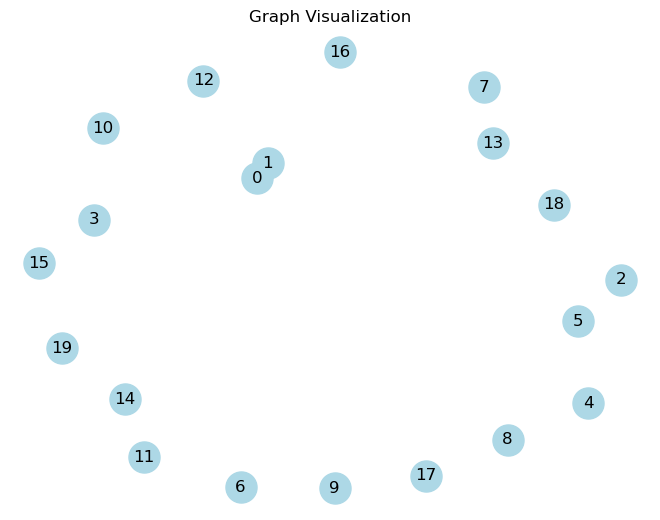

In [29]:
visualize_graph(graphs[3])

In [30]:
!pip install torch_geometric

In [31]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

In [32]:
import torch

# Example graph object from the user's data
graph = graphs[3]

# Extracting edge indices
edge_indices = graph.edge_index.t().tolist()

# Extracting node features (assuming each node has a feature vector)
node_features = graph.x.tolist()

# The nodes can be represented as a list of indices from 0 to the number of nodes - 1
node_indices = list(range(len(node_features)))

# Displaying the node indices and edge indices
#node_indices, edge_indices
#print(node_features)

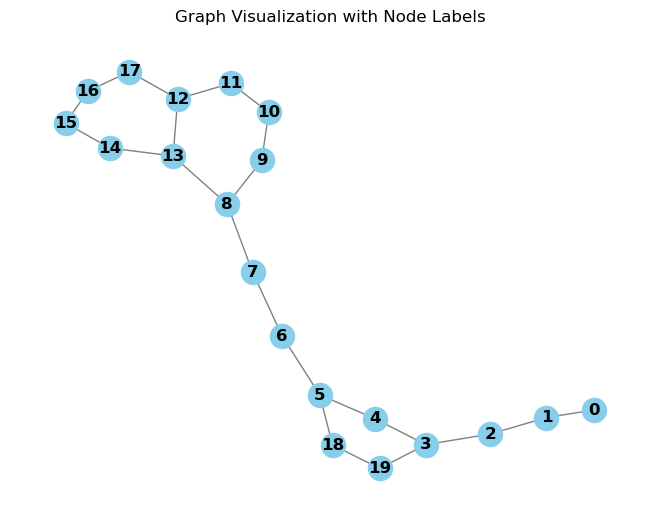

In [33]:
import networkx as nx
import torch_geometric

edge_index = torch.tensor(edge_indices, dtype=torch.long)
x = torch.tensor(node_indices, dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Draw the graph with node labels
pos = nx.spring_layout(g)  # Compute layout
nx.draw(g, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization with Node Labels")
plt.show()

In [34]:
# Print the edge indices
print(graphs[3].edge_index.t().tolist())

[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 5, 18, 18, 19, 19, 3, 13, 8, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 5, 19, 18, 3, 19, 8, 13, 12, 17]]


In [35]:
# graphs[0] is a torch_geometric.data.Data object from your graphs list
graph = graphs[3]

# Print node features
print("Len of graph:", len(graph))
print("Node Features:")
print(len(graph.x))
#for i, node_feature in enumerate(graph.x):
    #print(f"Node {i}: {node_feature}")

# Print edge pairs and edge features
print("\nEdge Pairs and Features:")
print(graph.edge_index.t())
for i, edge in enumerate(graph.edge_index.t()):
    src, dest = edge[0].item(), edge[1].item()
    edge_feature = graph.edge_attr[i]
    #print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


Len of graph: 3
Node Features:
20

Edge Pairs and Features:
tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,  5, 18,
         18, 19, 19,  3, 13,  8, 17, 12],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,  5,
         19, 18,  3, 19,  8, 13, 12, 17]])


In [36]:
# Extracting edge list and edge features from the provided graph
graph = graphs[5]  

# Extracting edge index
edge_index = graph.edge_index.t()

# Preparing the edge list
edge_list = []
for i in range(edge_index.shape[1]):
    edge = edge_index[:, i]
    edge_list.append((edge[0].item(), edge[1].item()))

edge_list


[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (9, 10),
 (10, 9),
 (1, 11),
 (11, 1),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (14, 24),
 (24, 14),
 (24, 25),
 (25, 24),
 (10, 4),
 (4, 10),
 (25, 11),
 (11, 25),
 (23, 15),
 (15, 23),
 (23, 18),
 (18, 23)]

In [37]:
import torch
from torch_geometric.data import Data

# Assuming graph_data is your list of graph objects
# graph_data[0] is the first graph object

# Select the first graph object
first_graph = graphs[3]

# Convert node features to a floating-point type if they aren't already
node_features_float = first_graph.x.float()

# Inspect node features
print("Node features (x) of the first graph:")
print(node_features_float)
print("Shape of node features:", node_features_float.shape)

# Inspect edge features
print("\nEdge features (edge_attr) of the first graph:")
print(first_graph.edge_attr)
print("Shape of edge features:", first_graph.edge_attr.shape)

# Inspect edge index (connectivity)
print("\nEdge index (edge_index) of the first graph:")
print(first_graph.edge_index)
print("Shape of edge index:", first_graph.edge_index.shape)

# Calculate min and max for each node feature of the first graph
min_values, max_values = node_features_float.min(dim=0)[0], node_features_float.max(dim=0)[0]

print("\nMinimum values of node features:", min_values)
print("Maximum values of node features:", max_values)

# Calculate the standard deviation for each node feature
std_deviation = node_features_float.std(dim=0)
print("\nStandard deviation of node features:", std_deviation)


Node features (x) of the first graph:
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000, -0.3944],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0628],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0658],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0275],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1335],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0670]])
Shape of node features: torch.Size([20, 72])

Edge features (edge_attr) of the first graph:
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1.,

In [38]:
smiles_df['SMILES'][3]

'OCCn1cc(CNc2cccc3c2CCCC3)nn1'

In [39]:
mol = Chem.MolFromSmiles(smiles_df['SMILES'][3])
AllChem.ComputeGasteigerCharges(mol)

In [40]:
edge_indices = []
for bond in mol.GetBonds():
    start_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    edge_indices.append((start_idx, end_idx))
    edge_indices.append((end_idx, start_idx))  # Add the reverse direction


In [41]:
edge_indices

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (5, 18),
 (18, 5),
 (18, 19),
 (19, 18),
 (19, 3),
 (3, 19),
 (13, 8),
 (8, 13),
 (17, 12),
 (12, 17)]

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

In [43]:
print((graphs[0]))
print((smiles_df.head(1)))

Data(x=[25, 72], edge_index=[54, 2], edge_attr=[54, 10])
                                   SMILES
0  CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1


In [44]:
print(len(graphs))
print(len(smiles_df))

50001
50001


In [45]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 50001


In [46]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [47]:
print(type(graphs[3]))

<class 'torch_geometric.data.data.Data'>


In [48]:
# Unsupervised Graph Generative Adversarial Netwrok

In [49]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [50]:
def generate_random_edge_index(num_nodes):
    # Example implementation to generate a random edge_index
    # Here we create a fully connected graph for simplicity
    edge_index = torch.combinations(torch.arange(num_nodes), r=2)
    return torch.cat([edge_index, edge_index.flip([1])], dim=0).t()  # Making it undirected

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data, Batch
from torch_geometric.utils import erdos_renyi_graph

def generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes):
    """
    Generate random noise for a batch of graphs with variable number of nodes and edges,
    but fixed node feature and edge feature dimensions.

    Args:
    - batch_size (int): Number of random graphs to generate.
    - node_feature_dim (int): Number of features for each node.
    - edge_feature_dim (int): Number of features for each edge.
    - max_num_nodes (int): Maximum number of nodes a graph can have.

    Returns:
    - A list of Data objects containing random noise for node and edge features.
    """
    random_graphs = []

    for _ in range(batch_size):
        # Randomly determine the number of nodes for this graph
        num_nodes = torch.randint(low=1, high=max_num_nodes, size=(1,)).item()

        # Generate random node features
        x = torch.randn(num_nodes, node_feature_dim)

        # Generate a random graph structure (edge_index)
        edge_index = erdos_renyi_graph(num_nodes, edge_prob=0.5)  # p is the probability of an edge

        # Generate random edge features (if needed)
        num_edges = edge_index.size(1)
        edge_attr = torch.randn(num_edges, edge_feature_dim) if edge_feature_dim > 0 else None

        # Create a Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        random_graphs.append(data)

    #return random_graphs
    return Batch.from_data_list(random_graphs)





In [52]:
# Example usage
batch_size = 32
node_feature_dim = 72  # Number of node features
edge_feature_dim = 10  # Number of edge features, adjust as needed
max_num_nodes = 50    # Maximum number of nodes in a graph

random_noise_graphs = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)

In [53]:
random_noise_graphs 

DataBatch(x=[687, 72], edge_index=[2, 10178], edge_attr=[10178, 10], batch=[687], ptr=[33])

In [54]:
# Generator Model
class Generator_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index gen",type(x), type(edge_index))
        #print("x, edge_index gen",x.size(), edge_index.size())
        #print("x, edge_index gen",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("Generator x layer 1:",x)
        x = torch.sigmoid(self.layer2(x, edge_index))
        #print("Generator x  layer 2:",x)
        return x

In [55]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.layer1(x, edge_index))
        x = torch.sigmoid(self.layer2(x, edge_index))

        # Generate fake edge_index (simple example, should be improved)
        fake_edge_index = self.generate_fake_edge_index(x.size(0))
        return x, fake_edge_index

    def generate_fake_edge_index(self, num_nodes):
        # Implement logic to generate a plausible edge_index for fake graphs
        # Placeholder logic: create a simple linear chain graph
        edge_index = torch.tensor([[i, i+1] for i in range(num_nodes - 1)], dtype=torch.long).t()
        return edge_index


In [56]:
# Discriminator Model  
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        #print("In discriminator")
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("self.layer1",input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        #print("self.layer2",hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index1",type(x), type(edge_index))
        #print("x, edge_index2",x.size(), edge_index.size())
        #print("x, edge_index3",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("x 2",x)
        x = torch.sigmoid(self.layer2(x))
        #print("x 3",x)
        return x

In [57]:
# Model Initialization
generator_input_dim = 72
generator_hidden_dim = 256
#generator_hidden_dim = 128
generator_output_dim = 72

discriminator_input_dim = 72
discriminator_hidden_dim = 256
#discriminator_hidden_dim = 128

In [58]:
generator = Generator(generator_input_dim, generator_hidden_dim, generator_output_dim)
discriminator = Discriminator(discriminator_input_dim, discriminator_hidden_dim)

In [59]:
import torch.optim as optim
from torch_geometric.data import DataLoader
#from torch_geometric.loader import DataLoader

from torch.utils.data import Dataset

# Sample data loader (replace with your dataset)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=['x', 'edge_index'])
data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=[])



# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function
adversarial_loss = torch.nn.BCELoss()

C:\Users\Malli\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [60]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(discriminator, real_data, fake_data):
    real_predictions = discriminator(real_data).round()
    fake_predictions = discriminator(fake_data).round()
    correct_predictions = (real_predictions == 1).sum() + (fake_predictions == 0).sum()
    total_predictions = real_predictions.numel() + fake_predictions.numel()
    accuracy = 100 * correct_predictions.float() / total_predictions
    return accuracy

In [61]:
print((data_loader))

In [62]:
print((graphs[3].x).shape)
print((graphs[3].edge_index).shape)

torch.Size([20, 72])
torch.Size([44, 2])


In [63]:
print((graphs[0].x).shape)
print((graphs[0].edge_index).shape)

torch.Size([25, 72])
torch.Size([54, 2])


In [64]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

def custom_graph_data_loader(graph_dataset, batch_size):
    """
    Custom data loader for graph data.
    
    Args:
    - graph_dataset (list of Data): The dataset containing graph Data objects.
    - batch_size (int): The size of each batch.

    Yields:
    - Batched Data object containing a batch of graphs.
    """

    def batch_graphs(graphs):
        """
        Manually batches a list of graphs into a single Batch object.
        """
        batched_edge_index = []
        batched_x = []
        batched_batch = []

        current_node_idx = 0
        for i, graph in enumerate(graphs):
            # Offset the node indices by the current_node_idx and add them to the batched edge index.
            #edge_index_offset = graph.edge_index + current_node_idx
            #batched_edge_index.append(edge_index_offset)
            
            # Offset only the node indices in the edge_index tensor.
            edge_index_offset = graph.edge_index.clone()  # Make a copy to avoid modifying the original graph
            edge_index_offset[0, :] += current_node_idx  # Offset source node indices
            edge_index_offset[1, :] += current_node_idx  # Offset target node indices
            #batched_edge_index.append(edge_index_offset)            
            
            #Tring edge_index
            #batched_edge_index.append(graph.edge_index)
            batched_edge_index.append(graph.edge_index + current_node_idx)

            # Add the current graph's node features to the batched node features.
            batched_x.append(graph.x)

            # Add the graph index to the batch vector for all nodes of this graph.
            batched_batch.append(torch.full((graph.x.size(0),), i, dtype=torch.long))

            # Update the current_node_idx for the next graph.
            current_node_idx += graph.x.size(0)

        # Concatenate all the lists to create tensors.       
        
        batched_edge_index = torch.cat(batched_edge_index, dim=0)
        batched_x = torch.cat(batched_x, dim=0)
        batched_batch = torch.cat(batched_batch, dim=0)
        

        # Create a new Data object to hold the batched graph.
        batched_data = Data(x=batched_x, edge_index=batched_edge_index)
        batched_data.batch = batched_batch

        return batched_data

    # Shuffle dataset at the beginning of each epoch
    indices = torch.randperm(len(graph_dataset))
    
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_graphs_list = [graph_dataset[i] for i in batch_indices]
        batch = batch_graphs(batch_graphs_list)
        yield batch


In [65]:
import matplotlib.pyplot as plt
import torch

def calculate_accuracy(preds, labels):
    predicted_labels = preds.round()  # Convert probabilities to 0/1
    correct = (predicted_labels == labels).float()  # Convert into float for division 
    accuracy = correct.sum() / len(correct)
    return accuracy

In [66]:
# Create a NetworkX graph from node features and edge index
def create_networkx_graph(node_features, edge_index):
    G = nx.Graph()
    for i, feature in enumerate(node_features):
        G.add_node(i, feature=feature)
    for source, target in edge_index.t().numpy():
        G.add_edge(source, target)
    return G

In [67]:
num_epochs = 50
batch_size = 32

# Lists to store metrics
epochs = []
d_losses = []
g_losses = []
real_accuracy_list =[]
fake_accuracy_list=[]
d_accuracies = []

early_stop_threshold = 1.0  # Define your threshold near 1
loss_smoothing = 0.1  # Smoothing factor for loss, to avoid immediate stopping due to fluctuations
fake_loss_history = []  # To store recent history of fake losses
smoothed_fake_loss = float('inf')  # Initialize smoothed_fake_loss
prev_d_loss = None  # Initialize previous discriminator loss



# Initialize storage for real and fake graph
graph_data_per_epoch = {}

# To define how often to take snapshots 
snapshot_interval = 5  

for epoch in range(num_epochs):
    print("epoch", epoch)
    early_stop_triggered = False  # Flag to indicate if early stopping was triggered
    graph_data_per_epoch[epoch] = []
    
    for batch in custom_graph_data_loader(graphs, batch_size):
        # Generate fake data
        random_noise_graphs_batch = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)

        # Ensure the real edge_index is correctly shaped [2, num_edges]
        if batch.edge_index.size(0) != 2:
            batch.edge_index = batch.edge_index.t()  # Transpose if necessary        
        
        # Create fake data batch with both x and edge_index
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)

        # Labels for real and fake data (for each node)
        real_labels = torch.ones(batch.x.size(0), 1)
        fake_labels = torch.zeros(fake_data.x.size(0), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(batch), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # Recompute fake data and perform forward pass through discriminator
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)
        updated_real_labels = torch.ones(fake_data.x.size(0), 1)
        g_loss = adversarial_loss(discriminator(fake_data), updated_real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        # Calculate discriminator accuracy
        real_accuracy = calculate_accuracy(discriminator(batch).detach(), real_labels)
        print("real_accuracy",real_accuracy)
        fake_accuracy = calculate_accuracy(discriminator(fake_data).detach(), fake_labels)
        print("fake_accuracy",fake_accuracy)
        d_accuracy = (real_accuracy + fake_accuracy) / 2

        # Store metrics
        d_losses.append(d_loss.item())
        print("d_loss.item()",d_loss.item())
        g_losses.append(g_loss.item())
        print("g_loss.item()",g_loss.item())
        d_accuracies.append(d_accuracy.item())
        real_accuracy_list.append(real_accuracy.item())
        fake_accuracy_list.append(fake_accuracy.item())

        # Get current discriminator loss
        current_g_loss = g_loss.item()    
        print("current_g_loss",current_g_loss)
        
        # Calculate and store fake loss
        current_fake_loss = fake_loss.item()
        fake_loss_history.append(current_fake_loss)             
        
        # Update previous discriminator loss
        prev_g_loss = current_g_loss        
        

    
        ##################################################        
        # Post-Processing for Visualization and Analysis
        # Early stopping check
        if epoch > 20:  # Ensure some minimum number of iterations

            if current_g_loss == 0.0 and prev_g_loss == 0.0:
                print(f"Early stopping triggered at epoch {epoch}")
                early_stop_triggered = True

                # Store both real and fake graph data for each batch
                graph_data = {
                    "real_x": batch.x.clone().detach(),
                    "real_edge_index": batch.edge_index.clone().detach(),
                    "fake_x": fake_x.clone().detach(),
                    "fake_edge_index": fake_edge_index.clone().detach()
                }
                graph_data_per_epoch[epoch].append(graph_data)                

                break

        # Update previous discriminator loss
        prev_g_loss = current_g_loss

        # At the end of the last epoch, store the fake graphs
        if epoch == num_epochs - 1:
            # Store both real and fake graph data for each batch
            graph_data = {
                "real_x": batch.x.clone().detach(),
                "real_edge_index": batch.edge_index.clone().detach(),
                "fake_x": fake_x.clone().detach(),
                "fake_edge_index": fake_edge_index.clone().detach()
            }
            graph_data_per_epoch[epoch].append(graph_data)

        # Update previous discriminator loss
        prev_g_loss = current_g_loss 

        if early_stop_triggered:
            break  # Break the outer loop if early stopping was triggered
        
        
        ##################################################        
        

        epochs.append(epoch)


epoch 0
real_accuracy tensor(0.2365)
fake_accuracy tensor(1.)
d_loss.item() 1.3292057514190674
g_loss.item() 0.8571394085884094
current_g_loss 0.8571394085884094
real_accuracy tensor(0.3168)
fake_accuracy tensor(1.)
d_loss.item() 1.2605063915252686
g_loss.item() 0.9389579892158508
current_g_loss 0.9389579892158508
real_accuracy tensor(0.4005)
fake_accuracy tensor(1.)
d_loss.item() 1.1989772319793701
g_loss.item() 1.0218249559402466
current_g_loss 1.0218249559402466
real_accuracy tensor(0.5923)
fake_accuracy tensor(1.)
d_loss.item() 1.1443183422088623
g_loss.item() 1.1040359735488892
current_g_loss 1.1040359735488892
real_accuracy tensor(0.9318)
fake_accuracy tensor(1.)
d_loss.item() 1.0953285694122314
g_loss.item() 1.1849159002304077
current_g_loss 1.1849159002304077
real_accuracy tensor(0.9798)
fake_accuracy tensor(1.)
d_loss.item() 1.0492470264434814
g_loss.item() 1.2726563215255737
current_g_loss 1.2726563215255737
real_accuracy tensor(0.9926)
fake_accuracy tensor(1.)
d_loss.item() 

real_accuracy tensor(1.)
fake_accuracy tensor(0.8576)
d_loss.item() 0.5003529787063599
g_loss.item() 1.7375965118408203
current_g_loss 1.7375965118408203
real_accuracy tensor(1.)
fake_accuracy tensor(0.9486)
d_loss.item() 0.3506218194961548
g_loss.item() 1.9515039920806885
current_g_loss 1.9515039920806885
real_accuracy tensor(1.)
fake_accuracy tensor(0.8951)
d_loss.item() 0.4202057123184204
g_loss.item() 1.9623775482177734
current_g_loss 1.9623775482177734
real_accuracy tensor(1.)
fake_accuracy tensor(0.8971)
d_loss.item() 0.43198543787002563
g_loss.item() 1.8743480443954468
current_g_loss 1.8743480443954468
real_accuracy tensor(1.)
fake_accuracy tensor(0.8951)
d_loss.item() 0.44019925594329834
g_loss.item() 1.8165473937988281
current_g_loss 1.8165473937988281
real_accuracy tensor(1.)
fake_accuracy tensor(0.8652)
d_loss.item() 0.5357192158699036
g_loss.item() 1.6334539651870728
current_g_loss 1.6334539651870728
real_accuracy tensor(1.)
fake_accuracy tensor(0.8008)
d_loss.item() 0.5807

real_accuracy tensor(0.9449)
fake_accuracy tensor(1.)
d_loss.item() 0.7202358245849609
g_loss.item() 1.3446561098098755
current_g_loss 1.3446561098098755
real_accuracy tensor(0.8888)
fake_accuracy tensor(1.)
d_loss.item() 0.7789182662963867
g_loss.item() 1.314738154411316
current_g_loss 1.314738154411316
real_accuracy tensor(0.9007)
fake_accuracy tensor(1.)
d_loss.item() 0.7804487347602844
g_loss.item() 1.2630863189697266
current_g_loss 1.2630863189697266
real_accuracy tensor(0.8782)
fake_accuracy tensor(1.)
d_loss.item() 0.7880486249923706
g_loss.item() 1.2654931545257568
current_g_loss 1.2654931545257568
real_accuracy tensor(0.8467)
fake_accuracy tensor(1.)
d_loss.item() 0.8102833032608032
g_loss.item() 1.267933964729309
current_g_loss 1.267933964729309
real_accuracy tensor(0.8373)
fake_accuracy tensor(1.)
d_loss.item() 0.8312318325042725
g_loss.item() 1.25483238697052
current_g_loss 1.25483238697052
real_accuracy tensor(0.8347)
fake_accuracy tensor(1.)
d_loss.item() 0.82915806770324

fake_accuracy tensor(1.)
d_loss.item() 0.37401193380355835
g_loss.item() 2.0165581703186035
current_g_loss 2.0165581703186035
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.36591586470603943
g_loss.item() 2.013061046600342
current_g_loss 2.013061046600342
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.3330872654914856
g_loss.item() 2.0116968154907227
current_g_loss 2.0116968154907227
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.32325366139411926
g_loss.item() 2.0010650157928467
current_g_loss 2.0010650157928467
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.3227893114089966
g_loss.item() 1.9792282581329346
current_g_loss 1.9792282581329346
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.32459723949432373
g_loss.item() 1.9573026895523071
current_g_loss 1.9573026895523071
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.3348776698112488
g_loss.item() 1.866068720817

real_accuracy tensor(0.9717)
fake_accuracy tensor(1.)
d_loss.item() 0.44519421458244324
g_loss.item() 1.827072262763977
current_g_loss 1.827072262763977
real_accuracy tensor(0.9732)
fake_accuracy tensor(1.)
d_loss.item() 0.42637088894844055
g_loss.item() 1.8724571466445923
current_g_loss 1.8724571466445923
real_accuracy tensor(0.9795)
fake_accuracy tensor(1.)
d_loss.item() 0.3992236256599426
g_loss.item() 1.9298301935195923
current_g_loss 1.9298301935195923
real_accuracy tensor(0.9938)
fake_accuracy tensor(1.)
d_loss.item() 0.37272873520851135
g_loss.item() 1.9618115425109863
current_g_loss 1.9618115425109863
real_accuracy tensor(0.9918)
fake_accuracy tensor(1.)
d_loss.item() 0.35837194323539734
g_loss.item() 1.9677104949951172
current_g_loss 1.9677104949951172
real_accuracy tensor(0.9898)
fake_accuracy tensor(1.)
d_loss.item() 0.3282409906387329
g_loss.item() 2.0125539302825928
current_g_loss 2.0125539302825928
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.31773692

real_accuracy tensor(0.5246)
fake_accuracy tensor(1.)
d_loss.item() 1.1462419033050537
g_loss.item() 1.1954602003097534
current_g_loss 1.1954602003097534
real_accuracy tensor(0.6150)
fake_accuracy tensor(1.)
d_loss.item() 1.1043920516967773
g_loss.item() 1.187159776687622
current_g_loss 1.187159776687622
real_accuracy tensor(0.6282)
fake_accuracy tensor(1.)
d_loss.item() 1.068819522857666
g_loss.item() 1.1837447881698608
current_g_loss 1.1837447881698608
real_accuracy tensor(0.7160)
fake_accuracy tensor(1.)
d_loss.item() 0.9727649688720703
g_loss.item() 1.2128173112869263
current_g_loss 1.2128173112869263
real_accuracy tensor(0.7379)
fake_accuracy tensor(1.)
d_loss.item() 0.9522354602813721
g_loss.item() 1.1244621276855469
current_g_loss 1.1244621276855469
real_accuracy tensor(0.7317)
fake_accuracy tensor(1.)
d_loss.item() 0.952067494392395
g_loss.item() 1.1075371503829956
current_g_loss 1.1075371503829956
real_accuracy tensor(0.7743)
fake_accuracy tensor(1.)
d_loss.item() 0.8993116617

real_accuracy tensor(0.7147)
fake_accuracy tensor(1.)
d_loss.item() 0.726158082485199
g_loss.item() 2.0784380435943604
current_g_loss 2.0784380435943604
real_accuracy tensor(0.7741)
fake_accuracy tensor(1.)
d_loss.item() 0.6096806526184082
g_loss.item() 2.129110097885132
current_g_loss 2.129110097885132
real_accuracy tensor(0.7133)
fake_accuracy tensor(1.)
d_loss.item() 0.6674957275390625
g_loss.item() 2.1551475524902344
current_g_loss 2.1551475524902344
real_accuracy tensor(0.7660)
fake_accuracy tensor(1.)
d_loss.item() 0.6280839443206787
g_loss.item() 2.1229512691497803
current_g_loss 2.1229512691497803
real_accuracy tensor(0.7796)
fake_accuracy tensor(1.)
d_loss.item() 0.5845233201980591
g_loss.item() 2.1743085384368896
current_g_loss 2.1743085384368896
real_accuracy tensor(0.7846)
fake_accuracy tensor(1.)
d_loss.item() 0.5444973707199097
g_loss.item() 2.183232307434082
current_g_loss 2.183232307434082
real_accuracy tensor(0.8153)
fake_accuracy tensor(1.)
d_loss.item() 0.52340292930

real_accuracy tensor(0.8796)
fake_accuracy tensor(1.)
d_loss.item() 0.7230014801025391
g_loss.item() 1.2274314165115356
current_g_loss 1.2274314165115356
real_accuracy tensor(0.8839)
fake_accuracy tensor(1.)
d_loss.item() 0.6859444975852966
g_loss.item() 1.3035422563552856
current_g_loss 1.3035422563552856
real_accuracy tensor(0.8737)
fake_accuracy tensor(1.)
d_loss.item() 0.6132292747497559
g_loss.item() 1.4972290992736816
current_g_loss 1.4972290992736816
real_accuracy tensor(0.8964)
fake_accuracy tensor(1.)
d_loss.item() 0.6048201322555542
g_loss.item() 1.518308162689209
current_g_loss 1.518308162689209
real_accuracy tensor(0.8648)
fake_accuracy tensor(1.)
d_loss.item() 0.5730283260345459
g_loss.item() 1.6717543601989746
current_g_loss 1.6717543601989746
real_accuracy tensor(0.8764)
fake_accuracy tensor(1.)
d_loss.item() 0.5197407007217407
g_loss.item() 1.8200254440307617
current_g_loss 1.8200254440307617
real_accuracy tensor(0.8643)
fake_accuracy tensor(1.)
d_loss.item() 0.51028227

real_accuracy tensor(0.9931)
fake_accuracy tensor(1.)
d_loss.item() 0.0762711837887764
g_loss.item() 4.487915515899658
current_g_loss 4.487915515899658
real_accuracy tensor(0.9909)
fake_accuracy tensor(1.)
d_loss.item() 0.07503241300582886
g_loss.item() 4.428882122039795
current_g_loss 4.428882122039795
real_accuracy tensor(0.9935)
fake_accuracy tensor(1.)
d_loss.item() 0.07169243693351746
g_loss.item() 4.450486660003662
current_g_loss 4.450486660003662
real_accuracy tensor(0.9911)
fake_accuracy tensor(1.)
d_loss.item() 0.07530036568641663
g_loss.item() 4.36523962020874
current_g_loss 4.36523962020874
real_accuracy tensor(0.9925)
fake_accuracy tensor(1.)
d_loss.item() 0.07165630161762238
g_loss.item() 4.25495719909668
current_g_loss 4.25495719909668
real_accuracy tensor(0.9954)
fake_accuracy tensor(1.)
d_loss.item() 0.07385192066431046
g_loss.item() 4.228885173797607
current_g_loss 4.228885173797607
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.06268417835235596

real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.06700433790683746
g_loss.item() 3.9916396141052246
current_g_loss 3.9916396141052246
real_accuracy tensor(0.9945)
fake_accuracy tensor(1.)
d_loss.item() 0.07579683512449265
g_loss.item() 3.948697328567505
current_g_loss 3.948697328567505
real_accuracy tensor(0.9946)
fake_accuracy tensor(1.)
d_loss.item() 0.06574280560016632
g_loss.item() 3.909825325012207
current_g_loss 3.909825325012207
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.06746955215930939
g_loss.item() 3.854891777038574
current_g_loss 3.854891777038574
real_accuracy tensor(0.9962)
fake_accuracy tensor(1.)
d_loss.item() 0.06137574836611748
g_loss.item() 3.838261604309082
current_g_loss 3.838261604309082
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.07451372593641281
g_loss.item() 3.7544972896575928
current_g_loss 3.7544972896575928
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0636729523539543

real_accuracy tensor(0.9864)
fake_accuracy tensor(1.)
d_loss.item() 0.09634912014007568
g_loss.item() 3.9394524097442627
current_g_loss 3.9394524097442627
real_accuracy tensor(0.9951)
fake_accuracy tensor(1.)
d_loss.item() 0.09822133183479309
g_loss.item() 4.017650127410889
current_g_loss 4.017650127410889
real_accuracy tensor(0.9769)
fake_accuracy tensor(1.)
d_loss.item() 0.1138489618897438
g_loss.item() 4.057721138000488
current_g_loss 4.057721138000488
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.09072854369878769
g_loss.item() 4.0677618980407715
current_g_loss 4.0677618980407715
real_accuracy tensor(0.9864)
fake_accuracy tensor(1.)
d_loss.item() 0.09463156759738922
g_loss.item() 4.150669574737549
current_g_loss 4.150669574737549
real_accuracy tensor(0.9861)
fake_accuracy tensor(1.)
d_loss.item() 0.08601560443639755
g_loss.item() 4.218868732452393
current_g_loss 4.218868732452393
real_accuracy tensor(0.9872)
fake_accuracy tensor(1.)
d_loss.item() 0.090412169

real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.042580753564834595
g_loss.item() 4.618325710296631
current_g_loss 4.618325710296631
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.05254879221320152
g_loss.item() 4.492333889007568
current_g_loss 4.492333889007568
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.04938910901546478
g_loss.item() 4.59103536605835
current_g_loss 4.59103536605835
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.037499986588954926
g_loss.item() 4.519378662109375
current_g_loss 4.519378662109375
real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.05139090120792389
g_loss.item() 4.36463737487793
current_g_loss 4.36463737487793
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.04129771888256073
g_loss.item() 4.2848310470581055
current_g_loss 4.2848310470581055
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.04939763620495796
g_

real_accuracy tensor(0.8173)
fake_accuracy tensor(0.9892)
d_loss.item() 0.7275049090385437
g_loss.item() 1.4557691812515259
current_g_loss 1.4557691812515259
real_accuracy tensor(0.8118)
fake_accuracy tensor(0.9892)
d_loss.item() 0.7119011878967285
g_loss.item() 1.46091628074646
current_g_loss 1.46091628074646
real_accuracy tensor(0.8002)
fake_accuracy tensor(1.)
d_loss.item() 0.7190424799919128
g_loss.item() 1.4760963916778564
current_g_loss 1.4760963916778564
real_accuracy tensor(0.8010)
fake_accuracy tensor(1.)
d_loss.item() 0.6712802052497864
g_loss.item() 1.554524302482605
current_g_loss 1.554524302482605
real_accuracy tensor(0.7751)
fake_accuracy tensor(0.9969)
d_loss.item() 0.7453855872154236
g_loss.item() 1.5478734970092773
current_g_loss 1.5478734970092773
real_accuracy tensor(0.7789)
fake_accuracy tensor(1.)
d_loss.item() 0.6417818069458008
g_loss.item() 1.834097981452942
current_g_loss 1.834097981452942
real_accuracy tensor(0.7563)
fake_accuracy tensor(1.)
d_loss.item() 0.63

real_accuracy tensor(0.9681)
fake_accuracy tensor(1.)
d_loss.item() 0.15223905444145203
g_loss.item() 3.007847785949707
current_g_loss 3.007847785949707
real_accuracy tensor(0.9617)
fake_accuracy tensor(1.)
d_loss.item() 0.14981094002723694
g_loss.item() 3.0237252712249756
current_g_loss 3.0237252712249756
real_accuracy tensor(0.9866)
fake_accuracy tensor(1.)
d_loss.item() 0.12439891695976257
g_loss.item() 3.0155322551727295
current_g_loss 3.0155322551727295
real_accuracy tensor(0.9782)
fake_accuracy tensor(1.)
d_loss.item() 0.12502199411392212
g_loss.item() 3.0338659286499023
current_g_loss 3.0338659286499023
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.12401653826236725
g_loss.item() 3.026555061340332
current_g_loss 3.026555061340332
real_accuracy tensor(0.9644)
fake_accuracy tensor(1.)
d_loss.item() 0.16564488410949707
g_loss.item() 2.9763801097869873
current_g_loss 2.9763801097869873
real_accuracy tensor(0.9862)
fake_accuracy tensor(1.)
d_loss.item() 0.1209

real_accuracy tensor(0.9811)
fake_accuracy tensor(1.)
d_loss.item() 0.10596351325511932
g_loss.item() 3.112567663192749
current_g_loss 3.112567663192749
real_accuracy tensor(0.9520)
fake_accuracy tensor(1.)
d_loss.item() 0.1384364366531372
g_loss.item() 3.0935301780700684
current_g_loss 3.0935301780700684
real_accuracy tensor(0.9642)
fake_accuracy tensor(1.)
d_loss.item() 0.12024033069610596
g_loss.item() 3.0870914459228516
current_g_loss 3.0870914459228516
real_accuracy tensor(0.9610)
fake_accuracy tensor(1.)
d_loss.item() 0.11441081762313843
g_loss.item() 3.0977871417999268
current_g_loss 3.0977871417999268
real_accuracy tensor(0.9856)
fake_accuracy tensor(1.)
d_loss.item() 0.10745669901371002
g_loss.item() 3.1068150997161865
current_g_loss 3.1068150997161865
real_accuracy tensor(0.9756)
fake_accuracy tensor(1.)
d_loss.item() 0.1158129870891571
g_loss.item() 3.1278915405273438
current_g_loss 3.1278915405273438
real_accuracy tensor(0.9893)
fake_accuracy tensor(1.)
d_loss.item() 0.0981

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.05080197751522064
g_loss.item() 3.7123665809631348
current_g_loss 3.7123665809631348
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.0681658610701561
g_loss.item() 3.6421213150024414
current_g_loss 3.6421213150024414
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.05858844518661499
g_loss.item() 3.6506717205047607
current_g_loss 3.6506717205047607
real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.06549222767353058
g_loss.item() 3.4900009632110596
current_g_loss 3.4900009632110596
real_accuracy tensor(0.9963)
fake_accuracy tensor(1.)
d_loss.item() 0.06031809002161026
g_loss.item() 3.6008224487304688
current_g_loss 3.6008224487304688
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.06851600855588913
g_loss.item() 3.4222190380096436
current_g_loss 3.4222190380096436
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.06617

real_accuracy tensor(0.9152)
fake_accuracy tensor(1.)
d_loss.item() 0.31162029504776
g_loss.item() 2.297532558441162
current_g_loss 2.297532558441162
real_accuracy tensor(0.8932)
fake_accuracy tensor(1.)
d_loss.item() 0.35165780782699585
g_loss.item() 2.1886932849884033
current_g_loss 2.1886932849884033
real_accuracy tensor(0.9129)
fake_accuracy tensor(1.)
d_loss.item() 0.33848637342453003
g_loss.item() 2.160848379135132
current_g_loss 2.160848379135132
real_accuracy tensor(0.9245)
fake_accuracy tensor(1.)
d_loss.item() 0.3986264169216156
g_loss.item() 1.9024194478988647
current_g_loss 1.9024194478988647
real_accuracy tensor(0.8987)
fake_accuracy tensor(1.)
d_loss.item() 0.3483050465583801
g_loss.item() 2.2120518684387207
current_g_loss 2.2120518684387207
real_accuracy tensor(0.9179)
fake_accuracy tensor(1.)
d_loss.item() 0.34459376335144043
g_loss.item() 2.068082809448242
current_g_loss 2.068082809448242
real_accuracy tensor(0.9025)
fake_accuracy tensor(1.)
d_loss.item() 0.40345937013

real_accuracy tensor(0.9760)
fake_accuracy tensor(1.)
d_loss.item() 0.17821016907691956
g_loss.item() 2.521573781967163
current_g_loss 2.521573781967163
real_accuracy tensor(0.9697)
fake_accuracy tensor(1.)
d_loss.item() 0.18697448074817657
g_loss.item() 2.411938428878784
current_g_loss 2.411938428878784
real_accuracy tensor(0.9705)
fake_accuracy tensor(1.)
d_loss.item() 0.17557205259799957
g_loss.item() 2.690537214279175
current_g_loss 2.690537214279175
real_accuracy tensor(0.9843)
fake_accuracy tensor(1.)
d_loss.item() 0.15643641352653503
g_loss.item() 2.6484270095825195
current_g_loss 2.6484270095825195
real_accuracy tensor(0.9716)
fake_accuracy tensor(1.)
d_loss.item() 0.16114026308059692
g_loss.item() 2.686166524887085
current_g_loss 2.686166524887085
real_accuracy tensor(0.9724)
fake_accuracy tensor(1.)
d_loss.item() 0.14935874938964844
g_loss.item() 2.913339853286743
current_g_loss 2.913339853286743
real_accuracy tensor(0.9759)
fake_accuracy tensor(1.)
d_loss.item() 0.1319138109

real_accuracy tensor(0.9424)
fake_accuracy tensor(1.)
d_loss.item() 0.33381766080856323
g_loss.item() 2.193859338760376
current_g_loss 2.193859338760376
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.30757755041122437
g_loss.item() 2.416475296020508
current_g_loss 2.416475296020508
real_accuracy tensor(0.9566)
fake_accuracy tensor(1.)
d_loss.item() 0.2762629985809326
g_loss.item() 2.5365328788757324
current_g_loss 2.5365328788757324
real_accuracy tensor(0.9478)
fake_accuracy tensor(1.)
d_loss.item() 0.2846260070800781
g_loss.item() 2.6568596363067627
current_g_loss 2.6568596363067627
real_accuracy tensor(0.9645)
fake_accuracy tensor(1.)
d_loss.item() 0.2337271273136139
g_loss.item() 2.7590529918670654
current_g_loss 2.7590529918670654
real_accuracy tensor(0.9462)
fake_accuracy tensor(1.)
d_loss.item() 0.237557053565979
g_loss.item() 2.937694549560547
current_g_loss 2.937694549560547
real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.21774221956

real_accuracy tensor(0.9669)
fake_accuracy tensor(1.)
d_loss.item() 0.25458186864852905
g_loss.item() 2.7732131481170654
current_g_loss 2.7732131481170654
real_accuracy tensor(0.9703)
fake_accuracy tensor(1.)
d_loss.item() 0.25633054971694946
g_loss.item() 2.6732773780822754
current_g_loss 2.6732773780822754
real_accuracy tensor(0.9757)
fake_accuracy tensor(1.)
d_loss.item() 0.2495248019695282
g_loss.item() 2.6589908599853516
current_g_loss 2.6589908599853516
real_accuracy tensor(0.9756)
fake_accuracy tensor(1.)
d_loss.item() 0.24805083870887756
g_loss.item() 2.586008310317993
current_g_loss 2.586008310317993
real_accuracy tensor(0.9531)
fake_accuracy tensor(1.)
d_loss.item() 0.31236621737480164
g_loss.item() 2.5141327381134033
current_g_loss 2.5141327381134033
real_accuracy tensor(0.9704)
fake_accuracy tensor(1.)
d_loss.item() 0.3147544860839844
g_loss.item() 2.2488107681274414
current_g_loss 2.2488107681274414
real_accuracy tensor(0.9768)
fake_accuracy tensor(1.)
d_loss.item() 0.2714

real_accuracy tensor(0.6590)
fake_accuracy tensor(1.)
d_loss.item() 0.905097484588623
g_loss.item() 1.4678105115890503
current_g_loss 1.4678105115890503
real_accuracy tensor(0.7472)
fake_accuracy tensor(1.)
d_loss.item() 0.735626220703125
g_loss.item() 1.4837119579315186
current_g_loss 1.4837119579315186
real_accuracy tensor(0.6954)
fake_accuracy tensor(1.)
d_loss.item() 0.7957385778427124
g_loss.item() 1.542665719985962
current_g_loss 1.542665719985962
real_accuracy tensor(0.7366)
fake_accuracy tensor(1.)
d_loss.item() 0.6673532128334045
g_loss.item() 1.6549018621444702
current_g_loss 1.6549018621444702
real_accuracy tensor(0.7307)
fake_accuracy tensor(1.)
d_loss.item() 0.6881200671195984
g_loss.item() 1.6659611463546753
current_g_loss 1.6659611463546753
real_accuracy tensor(0.7828)
fake_accuracy tensor(1.)
d_loss.item() 0.6034272909164429
g_loss.item() 1.7206343412399292
current_g_loss 1.7206343412399292
real_accuracy tensor(0.7613)
fake_accuracy tensor(1.)
d_loss.item() 0.6225320100

real_accuracy tensor(0.8770)
fake_accuracy tensor(1.)
d_loss.item() 0.4299319386482239
g_loss.item() 2.0244462490081787
current_g_loss 2.0244462490081787
real_accuracy tensor(0.8862)
fake_accuracy tensor(1.)
d_loss.item() 0.41746026277542114
g_loss.item() 2.043124198913574
current_g_loss 2.043124198913574
real_accuracy tensor(0.8567)
fake_accuracy tensor(1.)
d_loss.item() 0.4792504906654358
g_loss.item() 2.0093255043029785
current_g_loss 2.0093255043029785
real_accuracy tensor(0.8876)
fake_accuracy tensor(1.)
d_loss.item() 0.44229432940483093
g_loss.item() 1.9968163967132568
current_g_loss 1.9968163967132568
real_accuracy tensor(0.9407)
fake_accuracy tensor(1.)
d_loss.item() 0.34255287051200867
g_loss.item() 1.965868592262268
current_g_loss 1.965868592262268
real_accuracy tensor(0.9028)
fake_accuracy tensor(1.)
d_loss.item() 0.42363107204437256
g_loss.item() 1.9657464027404785
current_g_loss 1.9657464027404785
real_accuracy tensor(0.9167)
fake_accuracy tensor(1.)
d_loss.item() 0.395734

real_accuracy tensor(0.8356)
fake_accuracy tensor(1.)
d_loss.item() 0.5461722612380981
g_loss.item() 2.2835593223571777
current_g_loss 2.2835593223571777
real_accuracy tensor(0.8428)
fake_accuracy tensor(1.)
d_loss.item() 0.5197575092315674
g_loss.item() 2.104855537414551
current_g_loss 2.104855537414551
real_accuracy tensor(0.9033)
fake_accuracy tensor(1.)
d_loss.item() 0.36667317152023315
g_loss.item() 2.0900278091430664
current_g_loss 2.0900278091430664
real_accuracy tensor(0.8967)
fake_accuracy tensor(1.)
d_loss.item() 0.39835870265960693
g_loss.item() 2.1646816730499268
current_g_loss 2.1646816730499268
real_accuracy tensor(0.8633)
fake_accuracy tensor(1.)
d_loss.item() 0.5285876393318176
g_loss.item() 1.9471843242645264
current_g_loss 1.9471843242645264
real_accuracy tensor(0.8445)
fake_accuracy tensor(1.)
d_loss.item() 0.5643853545188904
g_loss.item() 1.9113938808441162
current_g_loss 1.9113938808441162
real_accuracy tensor(0.8747)
fake_accuracy tensor(1.)
d_loss.item() 0.480986

real_accuracy tensor(0.7751)
fake_accuracy tensor(0.9676)
d_loss.item() 0.8923639059066772
g_loss.item() 1.4042863845825195
current_g_loss 1.4042863845825195
real_accuracy tensor(0.8252)
fake_accuracy tensor(1.)
d_loss.item() 0.6938519477844238
g_loss.item() 1.4564857482910156
current_g_loss 1.4564857482910156
real_accuracy tensor(0.8473)
fake_accuracy tensor(0.9827)
d_loss.item() 0.7586891651153564
g_loss.item() 1.3626103401184082
current_g_loss 1.3626103401184082
real_accuracy tensor(0.8262)
fake_accuracy tensor(0.9791)
d_loss.item() 0.7427219152450562
g_loss.item() 1.4016109704971313
current_g_loss 1.4016109704971313
real_accuracy tensor(0.8133)
fake_accuracy tensor(0.9987)
d_loss.item() 0.720095157623291
g_loss.item() 1.4984253644943237
current_g_loss 1.4984253644943237
real_accuracy tensor(0.7598)
fake_accuracy tensor(0.9903)
d_loss.item() 0.8652735948562622
g_loss.item() 1.4903039932250977
current_g_loss 1.4903039932250977
real_accuracy tensor(0.8055)
fake_accuracy tensor(0.9739)

real_accuracy tensor(0.9790)
fake_accuracy tensor(1.)
d_loss.item() 0.16720151901245117
g_loss.item() 2.4118428230285645
current_g_loss 2.4118428230285645
real_accuracy tensor(0.9837)
fake_accuracy tensor(1.)
d_loss.item() 0.182758167386055
g_loss.item() 2.3117763996124268
current_g_loss 2.3117763996124268
real_accuracy tensor(0.9795)
fake_accuracy tensor(1.)
d_loss.item() 0.19604653120040894
g_loss.item() 2.2077064514160156
current_g_loss 2.2077064514160156
real_accuracy tensor(0.9763)
fake_accuracy tensor(1.)
d_loss.item() 0.20521041750907898
g_loss.item() 2.1873674392700195
current_g_loss 2.1873674392700195
real_accuracy tensor(0.9716)
fake_accuracy tensor(1.)
d_loss.item() 0.27208849787712097
g_loss.item() 1.984085202217102
current_g_loss 1.984085202217102
real_accuracy tensor(0.9677)
fake_accuracy tensor(1.)
d_loss.item() 0.24724765121936798
g_loss.item() 2.0618810653686523
current_g_loss 2.0618810653686523
real_accuracy tensor(0.9725)
fake_accuracy tensor(1.)
d_loss.item() 0.2694

real_accuracy tensor(0.9851)
fake_accuracy tensor(1.)
d_loss.item() 0.246076762676239
g_loss.item() 2.123473644256592
current_g_loss 2.123473644256592
real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.27917081117630005
g_loss.item() 2.2135801315307617
current_g_loss 2.2135801315307617
real_accuracy tensor(0.9762)
fake_accuracy tensor(1.)
d_loss.item() 0.2254020869731903
g_loss.item() 2.318591833114624
current_g_loss 2.318591833114624
real_accuracy tensor(0.9782)
fake_accuracy tensor(0.9499)
d_loss.item() 0.3528761565685272
g_loss.item() 1.9477566480636597
current_g_loss 1.9477566480636597
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9718)
d_loss.item() 0.35671865940093994
g_loss.item() 2.0056838989257812
current_g_loss 2.0056838989257812
real_accuracy tensor(0.9501)
fake_accuracy tensor(1.)
d_loss.item() 0.3691597282886505
g_loss.item() 1.869698166847229
current_g_loss 1.869698166847229
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9521)
d_loss.item() 0

real_accuracy tensor(0.9541)
fake_accuracy tensor(0.9990)
d_loss.item() 0.2731449604034424
g_loss.item() 2.5781404972076416
current_g_loss 2.5781404972076416
real_accuracy tensor(0.9466)
fake_accuracy tensor(0.9938)
d_loss.item() 0.2748793065547943
g_loss.item() 2.831061601638794
current_g_loss 2.831061601638794
real_accuracy tensor(0.9373)
fake_accuracy tensor(0.9724)
d_loss.item() 0.33202487230300903
g_loss.item() 2.559413433074951
current_g_loss 2.559413433074951
real_accuracy tensor(0.9438)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2840258777141571
g_loss.item() 2.601640462875366
current_g_loss 2.601640462875366
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.36601078510284424
g_loss.item() 2.537792444229126
current_g_loss 2.537792444229126
real_accuracy tensor(0.9211)
fake_accuracy tensor(1.)
d_loss.item() 0.3755178451538086
g_loss.item() 2.4219210147857666
current_g_loss 2.4219210147857666
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item(

real_accuracy tensor(0.8896)
fake_accuracy tensor(1.)
d_loss.item() 0.436644971370697
g_loss.item() 2.1627068519592285
current_g_loss 2.1627068519592285
real_accuracy tensor(0.9177)
fake_accuracy tensor(1.)
d_loss.item() 0.3427368402481079
g_loss.item() 2.3519809246063232
current_g_loss 2.3519809246063232
real_accuracy tensor(0.8860)
fake_accuracy tensor(1.)
d_loss.item() 0.4061800539493561
g_loss.item() 2.444672107696533
current_g_loss 2.444672107696533
real_accuracy tensor(0.8915)
fake_accuracy tensor(0.9986)
d_loss.item() 0.3884162902832031
g_loss.item() 2.418442487716675
current_g_loss 2.418442487716675
real_accuracy tensor(0.9036)
fake_accuracy tensor(1.)
d_loss.item() 0.33092325925827026
g_loss.item() 2.557742118835449
current_g_loss 2.557742118835449
real_accuracy tensor(0.8882)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3374391198158264
g_loss.item() 2.605029344558716
current_g_loss 2.605029344558716
real_accuracy tensor(0.8709)
fake_accuracy tensor(1.)
d_loss.item() 0.411967

real_accuracy tensor(0.9749)
fake_accuracy tensor(1.)
d_loss.item() 0.10286878049373627
g_loss.item() 4.353086471557617
current_g_loss 4.353086471557617
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9966)
d_loss.item() 0.13873305916786194
g_loss.item() 4.100198745727539
current_g_loss 4.100198745727539
real_accuracy tensor(0.9565)
fake_accuracy tensor(1.)
d_loss.item() 0.15859682857990265
g_loss.item() 4.120499134063721
current_g_loss 4.120499134063721
real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1441495418548584
g_loss.item() 4.07952356338501
current_g_loss 4.07952356338501
real_accuracy tensor(0.9512)
fake_accuracy tensor(1.)
d_loss.item() 0.18059712648391724
g_loss.item() 3.9605510234832764
current_g_loss 3.9605510234832764
real_accuracy tensor(0.9663)
fake_accuracy tensor(1.)
d_loss.item() 0.11201798170804977
g_loss.item() 4.276126384735107
current_g_loss 4.276126384735107
real_accuracy tensor(0.9778)
fake_accuracy tensor(1.)
d_loss.item() 0.11166

real_accuracy tensor(0.9748)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12878844141960144
g_loss.item() 3.898120164871216
current_g_loss 3.898120164871216
real_accuracy tensor(0.9625)
fake_accuracy tensor(1.)
d_loss.item() 0.14066298305988312
g_loss.item() 4.467386245727539
current_g_loss 4.467386245727539
real_accuracy tensor(0.9676)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12499599158763885
g_loss.item() 4.18861722946167
current_g_loss 4.18861722946167
real_accuracy tensor(0.9693)
fake_accuracy tensor(1.)
d_loss.item() 0.12225767970085144
g_loss.item() 4.552556991577148
current_g_loss 4.552556991577148
real_accuracy tensor(0.9793)
fake_accuracy tensor(1.)
d_loss.item() 0.10422174632549286
g_loss.item() 4.2549824714660645
current_g_loss 4.2549824714660645
real_accuracy tensor(0.9707)
fake_accuracy tensor(1.)
d_loss.item() 0.10587894916534424
g_loss.item() 4.397098064422607
current_g_loss 4.397098064422607
real_accuracy tensor(0.9516)
fake_accuracy tensor(1.)
d_loss.item() 0.1746

real_accuracy tensor(0.9917)
fake_accuracy tensor(0.9988)
d_loss.item() 0.07411520183086395
g_loss.item() 3.69785737991333
current_g_loss 3.69785737991333
real_accuracy tensor(0.9882)
fake_accuracy tensor(1.)
d_loss.item() 0.08118434250354767
g_loss.item() 3.77644944190979
current_g_loss 3.77644944190979
real_accuracy tensor(0.9839)
fake_accuracy tensor(1.)
d_loss.item() 0.08719679713249207
g_loss.item() 3.7212913036346436
current_g_loss 3.7212913036346436
real_accuracy tensor(0.9855)
fake_accuracy tensor(1.)
d_loss.item() 0.08978603780269623
g_loss.item() 3.6856181621551514
current_g_loss 3.6856181621551514
real_accuracy tensor(0.9851)
fake_accuracy tensor(0.9959)
d_loss.item() 0.11231480538845062
g_loss.item() 3.4475595951080322
current_g_loss 3.4475595951080322
real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.08561301231384277
g_loss.item() 3.5984597206115723
current_g_loss 3.5984597206115723
real_accuracy tensor(0.9902)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(0.7215)
fake_accuracy tensor(1.)
d_loss.item() 0.7744550704956055
g_loss.item() 1.8447868824005127
current_g_loss 1.8447868824005127
real_accuracy tensor(0.8232)
fake_accuracy tensor(0.9969)
d_loss.item() 0.5772337913513184
g_loss.item() 1.9399622678756714
current_g_loss 1.9399622678756714
real_accuracy tensor(0.7038)
fake_accuracy tensor(0.9974)
d_loss.item() 0.9256128072738647
g_loss.item() 1.6498775482177734
current_g_loss 1.6498775482177734
real_accuracy tensor(0.8162)
fake_accuracy tensor(0.9987)
d_loss.item() 0.6965386867523193
g_loss.item() 1.7204420566558838
current_g_loss 1.7204420566558838
real_accuracy tensor(0.8154)
fake_accuracy tensor(1.)
d_loss.item() 0.6749951243400574
g_loss.item() 1.7414013147354126
current_g_loss 1.7414013147354126
real_accuracy tensor(0.7354)
fake_accuracy tensor(1.)
d_loss.item() 0.7993103265762329
g_loss.item() 1.9143105745315552
current_g_loss 1.9143105745315552
real_accuracy tensor(0.7392)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(0.9083)
fake_accuracy tensor(0.9503)
d_loss.item() 0.4279800057411194
g_loss.item() 2.1977791786193848
current_g_loss 2.1977791786193848
real_accuracy tensor(0.9061)
fake_accuracy tensor(0.9945)
d_loss.item() 0.3372427821159363
g_loss.item() 2.3264803886413574
current_g_loss 2.3264803886413574
real_accuracy tensor(0.8806)
fake_accuracy tensor(0.9987)
d_loss.item() 0.42836594581604004
g_loss.item() 2.3141307830810547
current_g_loss 2.3141307830810547
real_accuracy tensor(0.8591)
fake_accuracy tensor(0.9928)
d_loss.item() 0.5097648501396179
g_loss.item() 2.007028579711914
current_g_loss 2.007028579711914
real_accuracy tensor(0.8945)
fake_accuracy tensor(0.8970)
d_loss.item() 0.5609424114227295
g_loss.item() 2.062718152999878
current_g_loss 2.062718152999878
real_accuracy tensor(0.8965)
fake_accuracy tensor(0.9869)
d_loss.item() 0.410591721534729
g_loss.item() 2.3854424953460693
current_g_loss 2.3854424953460693
real_accuracy tensor(0.8519)
fake_accuracy tensor(0.9949

real_accuracy tensor(0.8589)
fake_accuracy tensor(1.)
d_loss.item() 0.3798231780529022
g_loss.item() 2.6721177101135254
current_g_loss 2.6721177101135254
real_accuracy tensor(0.8452)
fake_accuracy tensor(0.9930)
d_loss.item() 0.4352441430091858
g_loss.item() 2.6889209747314453
current_g_loss 2.6889209747314453
real_accuracy tensor(0.8833)
fake_accuracy tensor(0.9952)
d_loss.item() 0.3849933445453644
g_loss.item() 2.6753971576690674
current_g_loss 2.6753971576690674
real_accuracy tensor(0.9156)
fake_accuracy tensor(0.9580)
d_loss.item() 0.35070493817329407
g_loss.item() 2.5706710815429688
current_g_loss 2.5706710815429688
real_accuracy tensor(0.9008)
fake_accuracy tensor(0.9962)
d_loss.item() 0.3474464416503906
g_loss.item() 2.5676989555358887
current_g_loss 2.5676989555358887
real_accuracy tensor(0.9050)
fake_accuracy tensor(0.9974)
d_loss.item() 0.33550164103507996
g_loss.item() 2.6628048419952393
current_g_loss 2.6628048419952393
real_accuracy tensor(0.9430)
fake_accuracy tensor(0.96

real_accuracy tensor(0.9109)
fake_accuracy tensor(0.9965)
d_loss.item() 0.3834017515182495
g_loss.item() 2.0743894577026367
current_g_loss 2.0743894577026367
real_accuracy tensor(0.8976)
fake_accuracy tensor(1.)
d_loss.item() 0.3864971995353699
g_loss.item() 2.235090732574463
current_g_loss 2.235090732574463
real_accuracy tensor(0.9022)
fake_accuracy tensor(0.9986)
d_loss.item() 0.3398754596710205
g_loss.item() 2.364781141281128
current_g_loss 2.364781141281128
real_accuracy tensor(0.9186)
fake_accuracy tensor(1.)
d_loss.item() 0.28577470779418945
g_loss.item() 2.389692544937134
current_g_loss 2.389692544937134
real_accuracy tensor(0.8727)
fake_accuracy tensor(1.)
d_loss.item() 0.37051165103912354
g_loss.item() 2.526118516921997
current_g_loss 2.526118516921997
real_accuracy tensor(0.8638)
fake_accuracy tensor(1.)
d_loss.item() 0.4041106402873993
g_loss.item() 2.5141618251800537
current_g_loss 2.5141618251800537
real_accuracy tensor(0.8680)
fake_accuracy tensor(1.)
d_loss.item() 0.4126

real_accuracy tensor(0.8713)
fake_accuracy tensor(0.9552)
d_loss.item() 0.498765230178833
g_loss.item() 1.962881088256836
current_g_loss 1.962881088256836
real_accuracy tensor(0.8823)
fake_accuracy tensor(0.9551)
d_loss.item() 0.4545109272003174
g_loss.item() 2.011835813522339
current_g_loss 2.011835813522339
real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9965)
d_loss.item() 0.36915910243988037
g_loss.item() 2.0559303760528564
current_g_loss 2.0559303760528564
real_accuracy tensor(0.8866)
fake_accuracy tensor(0.9424)
d_loss.item() 0.43290334939956665
g_loss.item() 2.059016466140747
current_g_loss 2.059016466140747
real_accuracy tensor(0.8374)
fake_accuracy tensor(0.9530)
d_loss.item() 0.5771472454071045
g_loss.item() 2.0196800231933594
current_g_loss 2.0196800231933594
real_accuracy tensor(0.8738)
fake_accuracy tensor(0.9656)
d_loss.item() 0.507831871509552
g_loss.item() 2.014517068862915
current_g_loss 2.014517068862915
real_accuracy tensor(0.8854)
fake_accuracy tensor(0.9572)
d_

real_accuracy tensor(0.7637)
fake_accuracy tensor(0.9460)
d_loss.item() 0.7712008953094482
g_loss.item() 1.6195093393325806
current_g_loss 1.6195093393325806
real_accuracy tensor(0.7707)
fake_accuracy tensor(0.9884)
d_loss.item() 0.7999441623687744
g_loss.item() 1.5597301721572876
current_g_loss 1.5597301721572876
real_accuracy tensor(0.7370)
fake_accuracy tensor(0.9866)
d_loss.item() 0.7774695754051208
g_loss.item() 1.8209338188171387
current_g_loss 1.8209338188171387
real_accuracy tensor(0.7970)
fake_accuracy tensor(0.8692)
d_loss.item() 0.8946589827537537
g_loss.item() 1.6524920463562012
current_g_loss 1.6524920463562012
real_accuracy tensor(0.8153)
fake_accuracy tensor(0.9630)
d_loss.item() 0.6667940616607666
g_loss.item() 1.856616497039795
current_g_loss 1.856616497039795
real_accuracy tensor(0.8293)
fake_accuracy tensor(0.9580)
d_loss.item() 0.6743599772453308
g_loss.item() 1.8987420797348022
current_g_loss 1.8987420797348022
real_accuracy tensor(0.8446)
fake_accuracy tensor(0.90

real_accuracy tensor(0.8405)
fake_accuracy tensor(0.9252)
d_loss.item() 0.6770574450492859
g_loss.item() 1.77962327003479
current_g_loss 1.77962327003479
real_accuracy tensor(0.8772)
fake_accuracy tensor(0.9532)
d_loss.item() 0.5714356899261475
g_loss.item() 1.768916130065918
current_g_loss 1.768916130065918
real_accuracy tensor(0.8173)
fake_accuracy tensor(0.9924)
d_loss.item() 0.5473321676254272
g_loss.item() 2.10750412940979
current_g_loss 2.10750412940979
real_accuracy tensor(0.8261)
fake_accuracy tensor(0.9340)
d_loss.item() 0.6102973222732544
g_loss.item() 2.044564723968506
current_g_loss 2.044564723968506
real_accuracy tensor(0.8454)
fake_accuracy tensor(0.8956)
d_loss.item() 0.6641809940338135
g_loss.item() 1.8012038469314575
current_g_loss 1.8012038469314575
real_accuracy tensor(0.8327)
fake_accuracy tensor(0.9364)
d_loss.item() 0.6244989037513733
g_loss.item() 1.8926841020584106
current_g_loss 1.8926841020584106
real_accuracy tensor(0.8527)
fake_accuracy tensor(0.9628)
d_loss

real_accuracy tensor(0.8502)
fake_accuracy tensor(0.9753)
d_loss.item() 0.5434107184410095
g_loss.item() 1.8198802471160889
current_g_loss 1.8198802471160889
real_accuracy tensor(0.8717)
fake_accuracy tensor(0.9830)
d_loss.item() 0.5521687269210815
g_loss.item() 1.7570197582244873
current_g_loss 1.7570197582244873
real_accuracy tensor(0.8168)
fake_accuracy tensor(0.8813)
d_loss.item() 0.7268886566162109
g_loss.item() 1.6643553972244263
current_g_loss 1.6643553972244263
real_accuracy tensor(0.8262)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5721991658210754
g_loss.item() 1.9248361587524414
current_g_loss 1.9248361587524414
real_accuracy tensor(0.7998)
fake_accuracy tensor(0.9269)
d_loss.item() 0.663353681564331
g_loss.item() 1.778841495513916
current_g_loss 1.778841495513916
real_accuracy tensor(0.7788)
fake_accuracy tensor(0.8922)
d_loss.item() 0.7913693189620972
g_loss.item() 1.6080683469772339
current_g_loss 1.6080683469772339
real_accuracy tensor(0.7309)
fake_accuracy tensor(0.957

real_accuracy tensor(0.9252)
fake_accuracy tensor(0.9780)
d_loss.item() 0.3165545165538788
g_loss.item() 3.317516326904297
current_g_loss 3.317516326904297
real_accuracy tensor(0.9253)
fake_accuracy tensor(0.9937)
d_loss.item() 0.3141651451587677
g_loss.item() 3.2345900535583496
current_g_loss 3.2345900535583496
real_accuracy tensor(0.9260)
fake_accuracy tensor(0.9945)
d_loss.item() 0.30271950364112854
g_loss.item() 3.0875964164733887
current_g_loss 3.0875964164733887
real_accuracy tensor(0.9309)
fake_accuracy tensor(0.9707)
d_loss.item() 0.34982264041900635
g_loss.item() 2.63525652885437
current_g_loss 2.63525652885437
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.33981379866600037
g_loss.item() 2.5864381790161133
current_g_loss 2.5864381790161133
real_accuracy tensor(0.9140)
fake_accuracy tensor(1.)
d_loss.item() 0.2847062349319458
g_loss.item() 3.1949713230133057
current_g_loss 3.1949713230133057
real_accuracy tensor(0.9051)
fake_accuracy tensor(1.)
d_loss.it

real_accuracy tensor(0.7619)
fake_accuracy tensor(0.9269)
d_loss.item() 0.7863082885742188
g_loss.item() 1.7411689758300781
current_g_loss 1.7411689758300781
real_accuracy tensor(0.7882)
fake_accuracy tensor(0.9054)
d_loss.item() 0.8026213645935059
g_loss.item() 1.6285223960876465
current_g_loss 1.6285223960876465
real_accuracy tensor(0.7816)
fake_accuracy tensor(0.9499)
d_loss.item() 0.6875611543655396
g_loss.item() 1.798628807067871
current_g_loss 1.798628807067871
real_accuracy tensor(0.7765)
fake_accuracy tensor(0.9408)
d_loss.item() 0.7241551876068115
g_loss.item() 1.799468755722046
current_g_loss 1.799468755722046
real_accuracy tensor(0.7930)
fake_accuracy tensor(0.9411)
d_loss.item() 0.6809743642807007
g_loss.item() 1.9605085849761963
current_g_loss 1.9605085849761963
real_accuracy tensor(0.7657)
fake_accuracy tensor(0.9544)
d_loss.item() 0.7290859222412109
g_loss.item() 1.8337711095809937
current_g_loss 1.8337711095809937
real_accuracy tensor(0.7752)
fake_accuracy tensor(0.9415

real_accuracy tensor(0.8399)
fake_accuracy tensor(0.9616)
d_loss.item() 0.6553467512130737
g_loss.item() 1.5156363248825073
current_g_loss 1.5156363248825073
real_accuracy tensor(0.8295)
fake_accuracy tensor(0.9764)
d_loss.item() 0.6338076591491699
g_loss.item() 1.603255271911621
current_g_loss 1.603255271911621
real_accuracy tensor(0.8242)
fake_accuracy tensor(0.9923)
d_loss.item() 0.6546973586082458
g_loss.item() 1.64057457447052
current_g_loss 1.64057457447052
real_accuracy tensor(0.7845)
fake_accuracy tensor(0.9881)
d_loss.item() 0.6801626682281494
g_loss.item() 1.6563893556594849
current_g_loss 1.6563893556594849
real_accuracy tensor(0.8193)
fake_accuracy tensor(0.9944)
d_loss.item() 0.6207821369171143
g_loss.item() 1.72111976146698
current_g_loss 1.72111976146698
real_accuracy tensor(0.8360)
fake_accuracy tensor(0.9662)
d_loss.item() 0.6700708270072937
g_loss.item() 1.5344582796096802
current_g_loss 1.5344582796096802
real_accuracy tensor(0.8135)
fake_accuracy tensor(0.9657)
d_lo

real_accuracy tensor(0.8054)
fake_accuracy tensor(1.)
d_loss.item() 0.6207677721977234
g_loss.item() 1.8711302280426025
current_g_loss 1.8711302280426025
real_accuracy tensor(0.8435)
fake_accuracy tensor(0.9989)
d_loss.item() 0.5326167345046997
g_loss.item() 1.8320045471191406
current_g_loss 1.8320045471191406
real_accuracy tensor(0.7976)
fake_accuracy tensor(0.9943)
d_loss.item() 0.6187314391136169
g_loss.item() 1.7908048629760742
current_g_loss 1.7908048629760742
real_accuracy tensor(0.8255)
fake_accuracy tensor(1.)
d_loss.item() 0.6045087575912476
g_loss.item() 1.8040704727172852
current_g_loss 1.8040704727172852
real_accuracy tensor(0.8162)
fake_accuracy tensor(0.9808)
d_loss.item() 0.6198895573616028
g_loss.item() 1.7575643062591553
current_g_loss 1.7575643062591553
real_accuracy tensor(0.8313)
fake_accuracy tensor(0.9765)
d_loss.item() 0.6377542614936829
g_loss.item() 1.7023147344589233
current_g_loss 1.7023147344589233
real_accuracy tensor(0.8382)
fake_accuracy tensor(0.9604)
d_

real_accuracy tensor(0.8652)
fake_accuracy tensor(0.9973)
d_loss.item() 0.5001387596130371
g_loss.item() 1.9646060466766357
current_g_loss 1.9646060466766357
real_accuracy tensor(0.8929)
fake_accuracy tensor(0.9974)
d_loss.item() 0.4874724745750427
g_loss.item() 1.8261070251464844
current_g_loss 1.8261070251464844
real_accuracy tensor(0.8807)
fake_accuracy tensor(0.9854)
d_loss.item() 0.5580280423164368
g_loss.item() 1.7472567558288574
current_g_loss 1.7472567558288574
real_accuracy tensor(0.8826)
fake_accuracy tensor(0.9863)
d_loss.item() 0.4733824133872986
g_loss.item() 1.8926297426223755
current_g_loss 1.8926297426223755
real_accuracy tensor(0.8778)
fake_accuracy tensor(0.9897)
d_loss.item() 0.4835209846496582
g_loss.item() 1.9745995998382568
current_g_loss 1.9745995998382568
real_accuracy tensor(0.8707)
fake_accuracy tensor(0.9988)
d_loss.item() 0.4905475974082947
g_loss.item() 2.0445239543914795
current_g_loss 2.0445239543914795
real_accuracy tensor(0.8944)
fake_accuracy tensor(0.

real_accuracy tensor(0.8432)
fake_accuracy tensor(0.8799)
d_loss.item() 0.6793175339698792
g_loss.item() 1.6363513469696045
current_g_loss 1.6363513469696045
real_accuracy tensor(0.8069)
fake_accuracy tensor(0.8747)
d_loss.item() 0.8173503875732422
g_loss.item() 1.4297351837158203
current_g_loss 1.4297351837158203
real_accuracy tensor(0.8020)
fake_accuracy tensor(0.8670)
d_loss.item() 0.855749249458313
g_loss.item() 1.5112965106964111
current_g_loss 1.5112965106964111
real_accuracy tensor(0.8039)
fake_accuracy tensor(0.9301)
d_loss.item() 0.8222435712814331
g_loss.item() 1.6183899641036987
current_g_loss 1.6183899641036987
real_accuracy tensor(0.7573)
fake_accuracy tensor(0.9257)
d_loss.item() 0.9263573884963989
g_loss.item() 1.4303065538406372
current_g_loss 1.4303065538406372
real_accuracy tensor(0.7513)
fake_accuracy tensor(0.8448)
d_loss.item() 0.9966286420822144
g_loss.item() 1.341907262802124
current_g_loss 1.341907262802124
real_accuracy tensor(0.7718)
fake_accuracy tensor(0.905

real_accuracy tensor(0.7876)
fake_accuracy tensor(1.)
d_loss.item() 0.6420153379440308
g_loss.item() 2.0517418384552
current_g_loss 2.0517418384552
real_accuracy tensor(0.7734)
fake_accuracy tensor(1.)
d_loss.item() 0.610451340675354
g_loss.item() 2.098745822906494
current_g_loss 2.098745822906494
real_accuracy tensor(0.7811)
fake_accuracy tensor(1.)
d_loss.item() 0.6298412084579468
g_loss.item() 2.2166857719421387
current_g_loss 2.2166857719421387
real_accuracy tensor(0.8219)
fake_accuracy tensor(1.)
d_loss.item() 0.6026172637939453
g_loss.item() 2.079174757003784
current_g_loss 2.079174757003784
real_accuracy tensor(0.8497)
fake_accuracy tensor(1.)
d_loss.item() 0.5449903011322021
g_loss.item() 2.240393877029419
current_g_loss 2.240393877029419
real_accuracy tensor(0.8466)
fake_accuracy tensor(1.)
d_loss.item() 0.545476496219635
g_loss.item() 2.2870047092437744
current_g_loss 2.2870047092437744
real_accuracy tensor(0.8946)
fake_accuracy tensor(1.)
d_loss.item() 0.42306333780288696
g_

real_accuracy tensor(0.8676)
fake_accuracy tensor(0.9964)
d_loss.item() 0.625838577747345
g_loss.item() 1.6672636270523071
current_g_loss 1.6672636270523071
real_accuracy tensor(0.8775)
fake_accuracy tensor(0.9973)
d_loss.item() 0.6136720776557922
g_loss.item() 1.6751644611358643
current_g_loss 1.6751644611358643
real_accuracy tensor(0.8509)
fake_accuracy tensor(0.9950)
d_loss.item() 0.7080479264259338
g_loss.item() 1.4993637800216675
current_g_loss 1.4993637800216675
real_accuracy tensor(0.8343)
fake_accuracy tensor(0.9942)
d_loss.item() 0.7172653675079346
g_loss.item() 1.5974923372268677
current_g_loss 1.5974923372268677
real_accuracy tensor(0.8735)
fake_accuracy tensor(0.9642)
d_loss.item() 0.6373546123504639
g_loss.item() 1.5050535202026367
current_g_loss 1.5050535202026367
real_accuracy tensor(0.8617)
fake_accuracy tensor(0.9802)
d_loss.item() 0.6957066655158997
g_loss.item() 1.4822814464569092
current_g_loss 1.4822814464569092
real_accuracy tensor(0.8993)
fake_accuracy tensor(0.9

real_accuracy tensor(0.8570)
fake_accuracy tensor(0.9632)
d_loss.item() 0.5976142287254333
g_loss.item() 2.0676064491271973
current_g_loss 2.0676064491271973
real_accuracy tensor(0.8573)
fake_accuracy tensor(0.9689)
d_loss.item() 0.5351042747497559
g_loss.item() 2.3305459022521973
current_g_loss 2.3305459022521973
real_accuracy tensor(0.8847)
fake_accuracy tensor(0.9782)
d_loss.item() 0.48152586817741394
g_loss.item() 2.1511213779449463
current_g_loss 2.1511213779449463
real_accuracy tensor(0.8913)
fake_accuracy tensor(0.9972)
d_loss.item() 0.41653507947921753
g_loss.item() 2.439046621322632
current_g_loss 2.439046621322632
real_accuracy tensor(0.8766)
fake_accuracy tensor(0.9985)
d_loss.item() 0.4823496341705322
g_loss.item() 2.2450125217437744
current_g_loss 2.2450125217437744
real_accuracy tensor(0.8972)
fake_accuracy tensor(0.9863)
d_loss.item() 0.426823228597641
g_loss.item() 2.334934711456299
current_g_loss 2.334934711456299
real_accuracy tensor(0.8804)
fake_accuracy tensor(0.973

real_accuracy tensor(0.7637)
fake_accuracy tensor(0.9987)
d_loss.item() 0.8405095338821411
g_loss.item() 1.6114493608474731
current_g_loss 1.6114493608474731
real_accuracy tensor(0.7438)
fake_accuracy tensor(0.9489)
d_loss.item() 0.9384740591049194
g_loss.item() 1.3473533391952515
current_g_loss 1.3473533391952515
real_accuracy tensor(0.7434)
fake_accuracy tensor(0.9772)
d_loss.item() 0.9046226143836975
g_loss.item() 1.5822679996490479
current_g_loss 1.5822679996490479
real_accuracy tensor(0.7521)
fake_accuracy tensor(0.9888)
d_loss.item() 0.8882230520248413
g_loss.item() 1.4390919208526611
current_g_loss 1.4390919208526611
real_accuracy tensor(0.7598)
fake_accuracy tensor(0.9669)
d_loss.item() 0.9194331169128418
g_loss.item() 1.4696711301803589
current_g_loss 1.4696711301803589
real_accuracy tensor(0.7637)
fake_accuracy tensor(0.9908)
d_loss.item() 0.8479855060577393
g_loss.item() 1.573728322982788
current_g_loss 1.573728322982788
real_accuracy tensor(0.7235)
fake_accuracy tensor(0.97

real_accuracy tensor(0.7025)
fake_accuracy tensor(0.9986)
d_loss.item() 0.853767991065979
g_loss.item() 1.5270111560821533
current_g_loss 1.5270111560821533
real_accuracy tensor(0.7685)
fake_accuracy tensor(1.)
d_loss.item() 0.6866536140441895
g_loss.item() 1.6473952531814575
current_g_loss 1.6473952531814575
real_accuracy tensor(0.7748)
fake_accuracy tensor(1.)
d_loss.item() 0.7037793397903442
g_loss.item() 1.6685898303985596
current_g_loss 1.6685898303985596
real_accuracy tensor(0.7620)
fake_accuracy tensor(0.9437)
d_loss.item() 0.7723247408866882
g_loss.item() 1.5251774787902832
current_g_loss 1.5251774787902832
real_accuracy tensor(0.7855)
fake_accuracy tensor(0.9970)
d_loss.item() 0.7431131601333618
g_loss.item() 1.4853506088256836
current_g_loss 1.4853506088256836
real_accuracy tensor(0.8248)
fake_accuracy tensor(0.9945)
d_loss.item() 0.6660571098327637
g_loss.item() 1.7527941465377808
current_g_loss 1.7527941465377808
real_accuracy tensor(0.8014)
fake_accuracy tensor(0.9985)
d_l

real_accuracy tensor(0.7788)
fake_accuracy tensor(0.8780)
d_loss.item() 0.7671529054641724
g_loss.item() 1.6223490238189697
current_g_loss 1.6223490238189697
real_accuracy tensor(0.8107)
fake_accuracy tensor(0.9632)
d_loss.item() 0.6304210424423218
g_loss.item() 1.821767807006836
current_g_loss 1.821767807006836
real_accuracy tensor(0.7946)
fake_accuracy tensor(0.8506)
d_loss.item() 0.8207156658172607
g_loss.item() 1.5202417373657227
current_g_loss 1.5202417373657227
real_accuracy tensor(0.7811)
fake_accuracy tensor(0.9782)
d_loss.item() 0.7003120183944702
g_loss.item() 1.7185865640640259
current_g_loss 1.7185865640640259
real_accuracy tensor(0.7831)
fake_accuracy tensor(0.9666)
d_loss.item() 0.6955508589744568
g_loss.item() 1.7816622257232666
current_g_loss 1.7816622257232666
real_accuracy tensor(0.7948)
fake_accuracy tensor(0.9529)
d_loss.item() 0.6695467233657837
g_loss.item() 1.7988661527633667
current_g_loss 1.7988661527633667
real_accuracy tensor(0.7460)
fake_accuracy tensor(0.98

real_accuracy tensor(0.8389)
fake_accuracy tensor(1.)
d_loss.item() 0.547974169254303
g_loss.item() 1.849839448928833
current_g_loss 1.849839448928833
real_accuracy tensor(0.8234)
fake_accuracy tensor(1.)
d_loss.item() 0.5894701480865479
g_loss.item() 1.718485951423645
current_g_loss 1.718485951423645
real_accuracy tensor(0.8327)
fake_accuracy tensor(1.)
d_loss.item() 0.5486029386520386
g_loss.item() 1.834983229637146
current_g_loss 1.834983229637146
real_accuracy tensor(0.8259)
fake_accuracy tensor(1.)
d_loss.item() 0.5300507545471191
g_loss.item() 1.8811968564987183
current_g_loss 1.8811968564987183
real_accuracy tensor(0.8470)
fake_accuracy tensor(1.)
d_loss.item() 0.5508403778076172
g_loss.item() 1.6976611614227295
current_g_loss 1.6976611614227295
real_accuracy tensor(0.8091)
fake_accuracy tensor(1.)
d_loss.item() 0.5789291262626648
g_loss.item() 1.7720376253128052
current_g_loss 1.7720376253128052
real_accuracy tensor(0.8458)
fake_accuracy tensor(1.)
d_loss.item() 0.5209727287292

real_accuracy tensor(0.8210)
fake_accuracy tensor(0.9463)
d_loss.item() 0.6980293393135071
g_loss.item() 1.720651626586914
current_g_loss 1.720651626586914
real_accuracy tensor(0.7775)
fake_accuracy tensor(0.9567)
d_loss.item() 0.7694810628890991
g_loss.item() 1.6586493253707886
current_g_loss 1.6586493253707886
real_accuracy tensor(0.7913)
fake_accuracy tensor(0.9313)
d_loss.item() 0.7569200992584229
g_loss.item() 1.654171347618103
current_g_loss 1.654171347618103
real_accuracy tensor(0.8195)
fake_accuracy tensor(0.9363)
d_loss.item() 0.7264775633811951
g_loss.item() 1.5981438159942627
current_g_loss 1.5981438159942627
real_accuracy tensor(0.8025)
fake_accuracy tensor(0.9649)
d_loss.item() 0.6762547492980957
g_loss.item() 1.7874141931533813
current_g_loss 1.7874141931533813
real_accuracy tensor(0.8252)
fake_accuracy tensor(0.9484)
d_loss.item() 0.692416787147522
g_loss.item() 1.6917210817337036
current_g_loss 1.6917210817337036
real_accuracy tensor(0.8014)
fake_accuracy tensor(0.9836)

real_accuracy tensor(0.8517)
fake_accuracy tensor(1.)
d_loss.item() 0.5505949854850769
g_loss.item() 1.8351866006851196
current_g_loss 1.8351866006851196
real_accuracy tensor(0.8797)
fake_accuracy tensor(1.)
d_loss.item() 0.48556840419769287
g_loss.item() 1.7140549421310425
current_g_loss 1.7140549421310425
real_accuracy tensor(0.8847)
fake_accuracy tensor(1.)
d_loss.item() 0.427412748336792
g_loss.item() 1.998894214630127
current_g_loss 1.998894214630127
real_accuracy tensor(0.9204)
fake_accuracy tensor(0.9963)
d_loss.item() 0.47575628757476807
g_loss.item() 1.7198407649993896
current_g_loss 1.7198407649993896
real_accuracy tensor(0.9151)
fake_accuracy tensor(1.)
d_loss.item() 0.46353933215141296
g_loss.item() 1.642549991607666
current_g_loss 1.642549991607666
real_accuracy tensor(0.8915)
fake_accuracy tensor(0.9768)
d_loss.item() 0.47518324851989746
g_loss.item() 1.7359625101089478
current_g_loss 1.7359625101089478
real_accuracy tensor(0.8734)
fake_accuracy tensor(1.)
d_loss.item() 0

real_accuracy tensor(0.7719)
fake_accuracy tensor(0.8372)
d_loss.item() 0.8147752285003662
g_loss.item() 1.4310929775238037
current_g_loss 1.4310929775238037
real_accuracy tensor(0.7779)
fake_accuracy tensor(0.9421)
d_loss.item() 0.6016761660575867
g_loss.item() 1.8445112705230713
current_g_loss 1.8445112705230713
real_accuracy tensor(0.7097)
fake_accuracy tensor(0.9089)
d_loss.item() 0.7483299970626831
g_loss.item() 1.843780755996704
current_g_loss 1.843780755996704
real_accuracy tensor(0.7471)
fake_accuracy tensor(1.)
d_loss.item() 0.6210817694664001
g_loss.item() 1.854066252708435
current_g_loss 1.854066252708435
real_accuracy tensor(0.7097)
fake_accuracy tensor(0.9805)
d_loss.item() 0.7214212417602539
g_loss.item() 1.7038002014160156
current_g_loss 1.7038002014160156
real_accuracy tensor(0.7506)
fake_accuracy tensor(0.9937)
d_loss.item() 0.6718378663063049
g_loss.item() 1.7063101530075073
current_g_loss 1.7063101530075073
real_accuracy tensor(0.7868)
fake_accuracy tensor(0.8799)
d_

real_accuracy tensor(0.7935)
fake_accuracy tensor(1.)
d_loss.item() 0.6066328287124634
g_loss.item() 1.7939728498458862
current_g_loss 1.7939728498458862
real_accuracy tensor(0.8347)
fake_accuracy tensor(1.)
d_loss.item() 0.5336464643478394
g_loss.item() 1.79019033908844
current_g_loss 1.79019033908844
real_accuracy tensor(0.8488)
fake_accuracy tensor(0.9933)
d_loss.item() 0.5843920111656189
g_loss.item() 1.7163279056549072
current_g_loss 1.7163279056549072
real_accuracy tensor(0.8536)
fake_accuracy tensor(1.)
d_loss.item() 0.5416301488876343
g_loss.item() 1.701846718788147
current_g_loss 1.701846718788147
real_accuracy tensor(0.8562)
fake_accuracy tensor(0.9567)
d_loss.item() 0.5624169707298279
g_loss.item() 1.616891622543335
current_g_loss 1.616891622543335
real_accuracy tensor(0.8304)
fake_accuracy tensor(0.9881)
d_loss.item() 0.6412813663482666
g_loss.item() 1.5653860569000244
current_g_loss 1.5653860569000244
real_accuracy tensor(0.8525)
fake_accuracy tensor(0.9913)
d_loss.item() 

real_accuracy tensor(0.6831)
fake_accuracy tensor(0.9034)
d_loss.item() 1.000659704208374
g_loss.item() 1.4798732995986938
current_g_loss 1.4798732995986938
real_accuracy tensor(0.7252)
fake_accuracy tensor(0.9406)
d_loss.item() 0.9022647142410278
g_loss.item() 1.445278525352478
current_g_loss 1.445278525352478
real_accuracy tensor(0.6707)
fake_accuracy tensor(0.8884)
d_loss.item() 0.9949892163276672
g_loss.item() 1.3390512466430664
current_g_loss 1.3390512466430664
real_accuracy tensor(0.6900)
fake_accuracy tensor(0.7971)
d_loss.item() 1.0588397979736328
g_loss.item() 1.273908019065857
current_g_loss 1.273908019065857
real_accuracy tensor(0.6768)
fake_accuracy tensor(0.8806)
d_loss.item() 0.9697372913360596
g_loss.item() 1.3122737407684326
current_g_loss 1.3122737407684326
real_accuracy tensor(0.6781)
fake_accuracy tensor(0.9425)
d_loss.item() 0.9742577075958252
g_loss.item() 1.3599660396575928
current_g_loss 1.3599660396575928
real_accuracy tensor(0.7057)
fake_accuracy tensor(0.9614)

real_accuracy tensor(0.7935)
fake_accuracy tensor(0.9465)
d_loss.item() 0.6513770818710327
g_loss.item() 1.5631461143493652
current_g_loss 1.5631461143493652
real_accuracy tensor(0.7963)
fake_accuracy tensor(0.9456)
d_loss.item() 0.6268638372421265
g_loss.item() 1.741594910621643
current_g_loss 1.741594910621643
real_accuracy tensor(0.7978)
fake_accuracy tensor(0.9899)
d_loss.item() 0.5678183436393738
g_loss.item() 1.8853839635849
current_g_loss 1.8853839635849
real_accuracy tensor(0.8116)
fake_accuracy tensor(0.9626)
d_loss.item() 0.5893553495407104
g_loss.item() 1.6835945844650269
current_g_loss 1.6835945844650269
real_accuracy tensor(0.7648)
fake_accuracy tensor(0.9143)
d_loss.item() 0.7305747270584106
g_loss.item() 1.544971227645874
current_g_loss 1.544971227645874
real_accuracy tensor(0.8109)
fake_accuracy tensor(0.8815)
d_loss.item() 0.6756433248519897
g_loss.item() 1.6042377948760986
current_g_loss 1.6042377948760986
real_accuracy tensor(0.7935)
fake_accuracy tensor(0.8507)
d_lo

real_accuracy tensor(0.7781)
fake_accuracy tensor(0.9417)
d_loss.item() 0.7707618474960327
g_loss.item() 1.4472733736038208
current_g_loss 1.4472733736038208
real_accuracy tensor(0.7806)
fake_accuracy tensor(0.9063)
d_loss.item() 0.8152705430984497
g_loss.item() 1.381555438041687
current_g_loss 1.381555438041687
real_accuracy tensor(0.7993)
fake_accuracy tensor(0.9648)
d_loss.item() 0.7038022875785828
g_loss.item() 1.511820912361145
current_g_loss 1.511820912361145
real_accuracy tensor(0.8063)
fake_accuracy tensor(0.9630)
d_loss.item() 0.7258633375167847
g_loss.item() 1.5157685279846191
current_g_loss 1.5157685279846191
real_accuracy tensor(0.7872)
fake_accuracy tensor(0.9586)
d_loss.item() 0.7446826696395874
g_loss.item() 1.493608832359314
current_g_loss 1.493608832359314
real_accuracy tensor(0.7937)
fake_accuracy tensor(0.9110)
d_loss.item() 0.7679409980773926
g_loss.item() 1.4166210889816284
current_g_loss 1.4166210889816284
real_accuracy tensor(0.7895)
fake_accuracy tensor(0.8954)


real_accuracy tensor(0.7395)
fake_accuracy tensor(0.9333)
d_loss.item() 0.816949725151062
g_loss.item() 1.5528159141540527
current_g_loss 1.5528159141540527
real_accuracy tensor(0.7467)
fake_accuracy tensor(0.9989)
d_loss.item() 0.7093930840492249
g_loss.item() 1.7291514873504639
current_g_loss 1.7291514873504639
real_accuracy tensor(0.7905)
fake_accuracy tensor(0.9377)
d_loss.item() 0.7424716949462891
g_loss.item() 1.3994206190109253
current_g_loss 1.3994206190109253
real_accuracy tensor(0.7638)
fake_accuracy tensor(0.9299)
d_loss.item() 0.8023784756660461
g_loss.item() 1.3731681108474731
current_g_loss 1.3731681108474731
real_accuracy tensor(0.7934)
fake_accuracy tensor(0.8443)
d_loss.item() 0.8053241968154907
g_loss.item() 1.3088133335113525
current_g_loss 1.3088133335113525
real_accuracy tensor(0.7985)
fake_accuracy tensor(0.8427)
d_loss.item() 0.8082529306411743
g_loss.item() 1.3502535820007324
current_g_loss 1.3502535820007324
real_accuracy tensor(0.8115)
fake_accuracy tensor(0.8

real_accuracy tensor(0.7561)
fake_accuracy tensor(0.9595)
d_loss.item() 0.8099255561828613
g_loss.item() 1.2328612804412842
current_g_loss 1.2328612804412842
real_accuracy tensor(0.7335)
fake_accuracy tensor(0.9311)
d_loss.item() 0.8784316778182983
g_loss.item() 1.210953950881958
current_g_loss 1.210953950881958
real_accuracy tensor(0.7473)
fake_accuracy tensor(0.9922)
d_loss.item() 0.7871279716491699
g_loss.item() 1.3251086473464966
current_g_loss 1.3251086473464966
real_accuracy tensor(0.7682)
fake_accuracy tensor(0.9837)
d_loss.item() 0.7957065105438232
g_loss.item() 1.2741169929504395
current_g_loss 1.2741169929504395
real_accuracy tensor(0.7660)
fake_accuracy tensor(0.9305)
d_loss.item() 0.8164762258529663
g_loss.item() 1.278167963027954
current_g_loss 1.278167963027954
real_accuracy tensor(0.7322)
fake_accuracy tensor(0.9930)
d_loss.item() 0.7881181240081787
g_loss.item() 1.4063630104064941
current_g_loss 1.4063630104064941
real_accuracy tensor(0.7407)
fake_accuracy tensor(0.9830

real_accuracy tensor(0.7776)
fake_accuracy tensor(0.9508)
d_loss.item() 0.8166292309761047
g_loss.item() 1.267696499824524
current_g_loss 1.267696499824524
real_accuracy tensor(0.7706)
fake_accuracy tensor(0.9963)
d_loss.item() 0.747725784778595
g_loss.item() 1.3730504512786865
current_g_loss 1.3730504512786865
real_accuracy tensor(0.7458)
fake_accuracy tensor(0.9926)
d_loss.item() 0.737391471862793
g_loss.item() 1.4636766910552979
current_g_loss 1.4636766910552979
real_accuracy tensor(0.7620)
fake_accuracy tensor(0.9972)
d_loss.item() 0.7364675402641296
g_loss.item() 1.4081486463546753
current_g_loss 1.4081486463546753
real_accuracy tensor(0.7810)
fake_accuracy tensor(0.9955)
d_loss.item() 0.7816498279571533
g_loss.item() 1.3316824436187744
current_g_loss 1.3316824436187744
real_accuracy tensor(0.7639)
fake_accuracy tensor(0.9814)
d_loss.item() 0.7540091276168823
g_loss.item() 1.4717272520065308
current_g_loss 1.4717272520065308
real_accuracy tensor(0.7844)
fake_accuracy tensor(0.9221

real_accuracy tensor(0.7747)
fake_accuracy tensor(0.9852)
d_loss.item() 0.731141209602356
g_loss.item() 1.3576860427856445
current_g_loss 1.3576860427856445
real_accuracy tensor(0.7368)
fake_accuracy tensor(0.9956)
d_loss.item() 0.7360366582870483
g_loss.item() 1.431410312652588
current_g_loss 1.431410312652588
real_accuracy tensor(0.7459)
fake_accuracy tensor(0.9953)
d_loss.item() 0.7451631426811218
g_loss.item() 1.4928696155548096
current_g_loss 1.4928696155548096
real_accuracy tensor(0.7281)
fake_accuracy tensor(0.9883)
d_loss.item() 0.7093542814254761
g_loss.item() 1.5055663585662842
current_g_loss 1.5055663585662842
real_accuracy tensor(0.7256)
fake_accuracy tensor(0.9770)
d_loss.item() 0.7429710030555725
g_loss.item() 1.4445048570632935
current_g_loss 1.4445048570632935
real_accuracy tensor(0.7605)
fake_accuracy tensor(0.9847)
d_loss.item() 0.6967206597328186
g_loss.item() 1.4850945472717285
current_g_loss 1.4850945472717285
real_accuracy tensor(0.7494)
fake_accuracy tensor(0.996

real_accuracy tensor(0.7237)
fake_accuracy tensor(0.9921)
d_loss.item() 0.7544169425964355
g_loss.item() 1.3874567747116089
current_g_loss 1.3874567747116089
real_accuracy tensor(0.7331)
fake_accuracy tensor(0.9757)
d_loss.item() 0.8094661235809326
g_loss.item() 1.3172030448913574
current_g_loss 1.3172030448913574
real_accuracy tensor(0.7316)
fake_accuracy tensor(0.9886)
d_loss.item() 0.7958252429962158
g_loss.item() 1.3443102836608887
current_g_loss 1.3443102836608887
real_accuracy tensor(0.7365)
fake_accuracy tensor(0.9953)
d_loss.item() 0.7592823505401611
g_loss.item() 1.3286802768707275
current_g_loss 1.3286802768707275
real_accuracy tensor(0.7322)
fake_accuracy tensor(0.9795)
d_loss.item() 0.7706045508384705
g_loss.item() 1.3673464059829712
current_g_loss 1.3673464059829712
real_accuracy tensor(0.7313)
fake_accuracy tensor(0.9838)
d_loss.item() 0.8052946925163269
g_loss.item() 1.2795639038085938
current_g_loss 1.2795639038085938
real_accuracy tensor(0.7143)
fake_accuracy tensor(0.

real_accuracy tensor(0.7229)
fake_accuracy tensor(0.9889)
d_loss.item() 0.6509966254234314
g_loss.item() 1.732726812362671
current_g_loss 1.732726812362671
real_accuracy tensor(0.7531)
fake_accuracy tensor(1.)
d_loss.item() 0.6511527299880981
g_loss.item() 1.5304794311523438
current_g_loss 1.5304794311523438
real_accuracy tensor(0.7675)
fake_accuracy tensor(0.9646)
d_loss.item() 0.6388528347015381
g_loss.item() 1.572575330734253
current_g_loss 1.572575330734253
real_accuracy tensor(0.7651)
fake_accuracy tensor(0.9352)
d_loss.item() 0.7376289367675781
g_loss.item() 1.340334415435791
current_g_loss 1.340334415435791
real_accuracy tensor(0.7866)
fake_accuracy tensor(0.9907)
d_loss.item() 0.6434459090232849
g_loss.item() 1.5008007287979126
current_g_loss 1.5008007287979126
real_accuracy tensor(0.8024)
fake_accuracy tensor(0.9814)
d_loss.item() 0.6606075763702393
g_loss.item() 1.3064502477645874
current_g_loss 1.3064502477645874
real_accuracy tensor(0.7892)
fake_accuracy tensor(0.9727)
d_lo

real_accuracy tensor(0.7207)
fake_accuracy tensor(0.9987)
d_loss.item() 0.743574857711792
g_loss.item() 1.5287420749664307
current_g_loss 1.5287420749664307
real_accuracy tensor(0.7679)
fake_accuracy tensor(0.9818)
d_loss.item() 0.716793417930603
g_loss.item() 1.5421682596206665
current_g_loss 1.5421682596206665
real_accuracy tensor(0.7506)
fake_accuracy tensor(0.9854)
d_loss.item() 0.7976945638656616
g_loss.item() 1.324799656867981
current_g_loss 1.324799656867981
real_accuracy tensor(0.7590)
fake_accuracy tensor(0.9563)
d_loss.item() 0.7351560592651367
g_loss.item() 1.5930089950561523
current_g_loss 1.5930089950561523
real_accuracy tensor(0.7450)
fake_accuracy tensor(0.9574)
d_loss.item() 0.7752092480659485
g_loss.item() 1.3309910297393799
current_g_loss 1.3309910297393799
real_accuracy tensor(0.7646)
fake_accuracy tensor(0.9771)
d_loss.item() 0.8131426572799683
g_loss.item() 1.2603517770767212
current_g_loss 1.2603517770767212
real_accuracy tensor(0.7816)
fake_accuracy tensor(0.9751

real_accuracy tensor(0.7899)
fake_accuracy tensor(1.)
d_loss.item() 0.6057009696960449
g_loss.item() 1.6151424646377563
current_g_loss 1.6151424646377563
real_accuracy tensor(0.7923)
fake_accuracy tensor(0.9911)
d_loss.item() 0.6398760080337524
g_loss.item() 1.5026648044586182
current_g_loss 1.5026648044586182
real_accuracy tensor(0.7751)
fake_accuracy tensor(0.9923)
d_loss.item() 0.6371093988418579
g_loss.item() 1.5121876001358032
current_g_loss 1.5121876001358032
real_accuracy tensor(0.7845)
fake_accuracy tensor(1.)
d_loss.item() 0.6277455687522888
g_loss.item() 1.5651403665542603
current_g_loss 1.5651403665542603
real_accuracy tensor(0.8071)
fake_accuracy tensor(0.9659)
d_loss.item() 0.6587042808532715
g_loss.item() 1.4670250415802002
current_g_loss 1.4670250415802002
real_accuracy tensor(0.7829)
fake_accuracy tensor(1.)
d_loss.item() 0.6066228747367859
g_loss.item() 1.5895718336105347
current_g_loss 1.5895718336105347
real_accuracy tensor(0.8045)
fake_accuracy tensor(0.9867)
d_loss

real_accuracy tensor(0.7457)
fake_accuracy tensor(0.9524)
d_loss.item() 0.7077425122261047
g_loss.item() 1.5261905193328857
current_g_loss 1.5261905193328857
real_accuracy tensor(0.8139)
fake_accuracy tensor(0.9788)
d_loss.item() 0.617500901222229
g_loss.item() 1.5638775825500488
current_g_loss 1.5638775825500488
real_accuracy tensor(0.7985)
fake_accuracy tensor(0.9533)
d_loss.item() 0.7067749500274658
g_loss.item() 1.4517524242401123
current_g_loss 1.4517524242401123
real_accuracy tensor(0.7568)
fake_accuracy tensor(0.9988)
d_loss.item() 0.6606578826904297
g_loss.item() 1.6319653987884521
current_g_loss 1.6319653987884521
real_accuracy tensor(0.7449)
fake_accuracy tensor(0.9989)
d_loss.item() 0.6928671002388
g_loss.item() 1.6097877025604248
current_g_loss 1.6097877025604248
real_accuracy tensor(0.7924)
fake_accuracy tensor(0.9882)
d_loss.item() 0.6179006099700928
g_loss.item() 1.6119920015335083
current_g_loss 1.6119920015335083
real_accuracy tensor(0.7940)
fake_accuracy tensor(0.9988

real_accuracy tensor(0.7888)
fake_accuracy tensor(0.9962)
d_loss.item() 0.6103043556213379
g_loss.item() 1.5897353887557983
current_g_loss 1.5897353887557983
real_accuracy tensor(0.8091)
fake_accuracy tensor(0.9834)
d_loss.item() 0.6050752997398376
g_loss.item() 1.5215321779251099
current_g_loss 1.5215321779251099
real_accuracy tensor(0.7883)
fake_accuracy tensor(0.9924)
d_loss.item() 0.6377551555633545
g_loss.item() 1.560659646987915
current_g_loss 1.560659646987915
real_accuracy tensor(0.8260)
fake_accuracy tensor(0.9943)
d_loss.item() 0.6078552007675171
g_loss.item() 1.5249098539352417
current_g_loss 1.5249098539352417
real_accuracy tensor(0.8283)
fake_accuracy tensor(0.9656)
d_loss.item() 0.618202269077301
g_loss.item() 1.4394575357437134
current_g_loss 1.4394575357437134
real_accuracy tensor(0.8090)
fake_accuracy tensor(0.9681)
d_loss.item() 0.6406359672546387
g_loss.item() 1.4627269506454468
current_g_loss 1.4627269506454468
real_accuracy tensor(0.7796)
fake_accuracy tensor(0.921

fake_accuracy tensor(0.9723)
d_loss.item() 0.7261953949928284
g_loss.item() 1.3539689779281616
current_g_loss 1.3539689779281616
real_accuracy tensor(0.7623)
fake_accuracy tensor(0.9663)
d_loss.item() 0.7031326293945312
g_loss.item() 1.3550024032592773
current_g_loss 1.3550024032592773
real_accuracy tensor(0.8158)
fake_accuracy tensor(0.9957)
d_loss.item() 0.5927527546882629
g_loss.item() 1.4951319694519043
current_g_loss 1.4951319694519043
real_accuracy tensor(0.7668)
fake_accuracy tensor(0.9950)
d_loss.item() 0.6823645830154419
g_loss.item() 1.487102746963501
current_g_loss 1.487102746963501
real_accuracy tensor(0.7935)
fake_accuracy tensor(0.9773)
d_loss.item() 0.6678357124328613
g_loss.item() 1.4568290710449219
current_g_loss 1.4568290710449219
real_accuracy tensor(0.7471)
fake_accuracy tensor(0.9813)
d_loss.item() 0.7132433652877808
g_loss.item() 1.442596197128296
current_g_loss 1.442596197128296
real_accuracy tensor(0.7357)
fake_accuracy tensor(0.9844)
d_loss.item() 0.69918352365

real_accuracy tensor(0.7543)
fake_accuracy tensor(1.)
d_loss.item() 0.6811505556106567
g_loss.item() 1.5090241432189941
current_g_loss 1.5090241432189941
real_accuracy tensor(0.7587)
fake_accuracy tensor(0.9953)
d_loss.item() 0.6351264715194702
g_loss.item() 1.6142174005508423
current_g_loss 1.6142174005508423
real_accuracy tensor(0.7497)
fake_accuracy tensor(0.9942)
d_loss.item() 0.6836597919464111
g_loss.item() 1.4652570486068726
current_g_loss 1.4652570486068726
real_accuracy tensor(0.7570)
fake_accuracy tensor(0.9963)
d_loss.item() 0.6660654544830322
g_loss.item() 1.4394688606262207
current_g_loss 1.4394688606262207
real_accuracy tensor(0.7993)
fake_accuracy tensor(0.9858)
d_loss.item() 0.6546000838279724
g_loss.item() 1.4138829708099365
current_g_loss 1.4138829708099365
real_accuracy tensor(0.7452)
fake_accuracy tensor(0.9986)
d_loss.item() 0.7223407626152039
g_loss.item() 1.414467692375183
current_g_loss 1.414467692375183
real_accuracy tensor(0.7313)
fake_accuracy tensor(0.9890)


real_accuracy tensor(0.8081)
fake_accuracy tensor(0.9860)
d_loss.item() 0.5667579174041748
g_loss.item() 2.036177158355713
current_g_loss 2.036177158355713
real_accuracy tensor(0.7944)
fake_accuracy tensor(0.9944)
d_loss.item() 0.5407878160476685
g_loss.item() 2.0670526027679443
current_g_loss 2.0670526027679443
real_accuracy tensor(0.8099)
fake_accuracy tensor(0.9955)
d_loss.item() 0.5872993469238281
g_loss.item() 1.7959729433059692
current_g_loss 1.7959729433059692
real_accuracy tensor(0.7968)
fake_accuracy tensor(0.9829)
d_loss.item() 0.5791053771972656
g_loss.item() 1.9123878479003906
current_g_loss 1.9123878479003906
real_accuracy tensor(0.8115)
fake_accuracy tensor(0.9987)
d_loss.item() 0.579437792301178
g_loss.item() 1.8339862823486328
current_g_loss 1.8339862823486328
real_accuracy tensor(0.8279)
fake_accuracy tensor(0.9739)
d_loss.item() 0.5454722046852112
g_loss.item() 1.8921971321105957
current_g_loss 1.8921971321105957
real_accuracy tensor(0.8295)
fake_accuracy tensor(0.984

real_accuracy tensor(0.7948)
fake_accuracy tensor(0.9903)
d_loss.item() 0.5916517376899719
g_loss.item() 1.7955193519592285
current_g_loss 1.7955193519592285
real_accuracy tensor(0.7962)
fake_accuracy tensor(0.9895)
d_loss.item() 0.6523504257202148
g_loss.item() 1.5212817192077637
current_g_loss 1.5212817192077637
real_accuracy tensor(0.7572)
fake_accuracy tensor(0.9811)
d_loss.item() 0.7053120136260986
g_loss.item() 1.5803442001342773
current_g_loss 1.5803442001342773
real_accuracy tensor(0.7746)
fake_accuracy tensor(0.9932)
d_loss.item() 0.609401285648346
g_loss.item() 1.7195802927017212
current_g_loss 1.7195802927017212
real_accuracy tensor(0.7818)
fake_accuracy tensor(0.9727)
d_loss.item() 0.5994148254394531
g_loss.item() 1.7418574094772339
current_g_loss 1.7418574094772339
real_accuracy tensor(0.7774)
fake_accuracy tensor(0.9907)
d_loss.item() 0.6737552881240845
g_loss.item() 1.5576435327529907
current_g_loss 1.5576435327529907
real_accuracy tensor(0.7680)
fake_accuracy tensor(0.9

real_accuracy tensor(0.7749)
fake_accuracy tensor(0.9960)
d_loss.item() 0.6377050876617432
g_loss.item() 1.6461472511291504
current_g_loss 1.6461472511291504
real_accuracy tensor(0.8031)
fake_accuracy tensor(1.)
d_loss.item() 0.5786018371582031
g_loss.item() 1.6811267137527466
current_g_loss 1.6811267137527466
real_accuracy tensor(0.7705)
fake_accuracy tensor(0.9908)
d_loss.item() 0.6419194340705872
g_loss.item() 1.667736291885376
current_g_loss 1.667736291885376
real_accuracy tensor(0.7474)
fake_accuracy tensor(0.9986)
d_loss.item() 0.6483541131019592
g_loss.item() 1.6335344314575195
current_g_loss 1.6335344314575195
real_accuracy tensor(0.7415)
fake_accuracy tensor(1.)
d_loss.item() 0.6504942774772644
g_loss.item() 1.680016040802002
current_g_loss 1.680016040802002
real_accuracy tensor(0.7596)
fake_accuracy tensor(0.9930)
d_loss.item() 0.6185746192932129
g_loss.item() 1.6106016635894775
current_g_loss 1.6106016635894775
real_accuracy tensor(0.7603)
fake_accuracy tensor(0.9963)
d_loss

real_accuracy tensor(0.7769)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5750096440315247
g_loss.item() 1.738699197769165
current_g_loss 1.738699197769165
real_accuracy tensor(0.8056)
fake_accuracy tensor(1.)
d_loss.item() 0.5319979190826416
g_loss.item() 1.6862233877182007
current_g_loss 1.6862233877182007
real_accuracy tensor(0.7646)
fake_accuracy tensor(1.)
d_loss.item() 0.5860037803649902
g_loss.item() 1.7241839170455933
current_g_loss 1.7241839170455933
real_accuracy tensor(0.7889)
fake_accuracy tensor(1.)
d_loss.item() 0.5468059778213501
g_loss.item() 1.7238012552261353
current_g_loss 1.7238012552261353
real_accuracy tensor(0.7726)
fake_accuracy tensor(0.9340)
d_loss.item() 0.667169451713562
g_loss.item() 1.6240166425704956
current_g_loss 1.6240166425704956
real_accuracy tensor(0.7530)
fake_accuracy tensor(0.9989)
d_loss.item() 0.6129732131958008
g_loss.item() 1.6995866298675537
current_g_loss 1.6995866298675537
real_accuracy tensor(0.7944)
fake_accuracy tensor(1.)
d_loss.item()

real_accuracy tensor(0.7528)
fake_accuracy tensor(0.9640)
d_loss.item() 0.6617274284362793
g_loss.item() 1.6677278280258179
current_g_loss 1.6677278280258179
real_accuracy tensor(0.7547)
fake_accuracy tensor(0.9466)
d_loss.item() 0.7043049931526184
g_loss.item() 1.5111477375030518
current_g_loss 1.5111477375030518
real_accuracy tensor(0.7870)
fake_accuracy tensor(0.9988)
d_loss.item() 0.5738458633422852
g_loss.item() 1.7650448083877563
current_g_loss 1.7650448083877563
real_accuracy tensor(0.8261)
fake_accuracy tensor(0.9493)
d_loss.item() 0.5801748633384705
g_loss.item() 1.6732556819915771
current_g_loss 1.6732556819915771
real_accuracy tensor(0.7962)
fake_accuracy tensor(0.9988)
d_loss.item() 0.5861055850982666
g_loss.item() 1.7541908025741577
current_g_loss 1.7541908025741577
real_accuracy tensor(0.7879)
fake_accuracy tensor(0.9749)
d_loss.item() 0.6007174253463745
g_loss.item() 1.5954158306121826
current_g_loss 1.5954158306121826
real_accuracy tensor(0.7901)
fake_accuracy tensor(0.

real_accuracy tensor(0.8229)
fake_accuracy tensor(0.9944)
d_loss.item() 0.5473748445510864
g_loss.item() 1.702225685119629
current_g_loss 1.702225685119629
real_accuracy tensor(0.8422)
fake_accuracy tensor(0.9724)
d_loss.item() 0.5426443219184875
g_loss.item() 1.6881675720214844
current_g_loss 1.6881675720214844
real_accuracy tensor(0.8403)
fake_accuracy tensor(0.9817)
d_loss.item() 0.5680567622184753
g_loss.item() 1.7025206089019775
current_g_loss 1.7025206089019775
real_accuracy tensor(0.8414)
fake_accuracy tensor(0.9815)
d_loss.item() 0.523472785949707
g_loss.item() 1.641237735748291
current_g_loss 1.641237735748291
real_accuracy tensor(0.8415)
fake_accuracy tensor(0.9602)
d_loss.item() 0.5430617332458496
g_loss.item() 1.627356767654419
current_g_loss 1.627356767654419
real_accuracy tensor(0.8007)
fake_accuracy tensor(0.9960)
d_loss.item() 0.5110604763031006
g_loss.item() 1.9655437469482422
current_g_loss 1.9655437469482422
real_accuracy tensor(0.8167)
fake_accuracy tensor(0.9597)
d

real_accuracy tensor(0.8294)
fake_accuracy tensor(0.9683)
d_loss.item() 0.5489661693572998
g_loss.item() 1.7204617261886597
current_g_loss 1.7204617261886597
real_accuracy tensor(0.8238)
fake_accuracy tensor(0.9910)
d_loss.item() 0.5260007977485657
g_loss.item() 1.797929048538208
current_g_loss 1.797929048538208
real_accuracy tensor(0.8398)
fake_accuracy tensor(0.8817)
d_loss.item() 0.654883086681366
g_loss.item() 1.4706562757492065
current_g_loss 1.4706562757492065
real_accuracy tensor(0.8554)
fake_accuracy tensor(0.9512)
d_loss.item() 0.5456438064575195
g_loss.item() 1.7068090438842773
current_g_loss 1.7068090438842773
real_accuracy tensor(0.8290)
fake_accuracy tensor(0.9447)
d_loss.item() 0.5744446516036987
g_loss.item() 1.6260417699813843
current_g_loss 1.6260417699813843
real_accuracy tensor(0.8545)
fake_accuracy tensor(0.9828)
d_loss.item() 0.5130451321601868
g_loss.item() 1.6765646934509277
current_g_loss 1.6765646934509277
real_accuracy tensor(0.8290)
fake_accuracy tensor(0.986

real_accuracy tensor(0.8344)
fake_accuracy tensor(0.9787)
d_loss.item() 0.5513185262680054
g_loss.item() 1.653428554534912
current_g_loss 1.653428554534912
real_accuracy tensor(0.8256)
fake_accuracy tensor(0.9838)
d_loss.item() 0.5777710676193237
g_loss.item() 1.5802656412124634
current_g_loss 1.5802656412124634
real_accuracy tensor(0.8404)
fake_accuracy tensor(0.9860)
d_loss.item() 0.5244428515434265
g_loss.item() 1.6803522109985352
current_g_loss 1.6803522109985352
real_accuracy tensor(0.8595)
fake_accuracy tensor(0.9987)
d_loss.item() 0.4785340428352356
g_loss.item() 1.7890114784240723
current_g_loss 1.7890114784240723
real_accuracy tensor(0.8389)
fake_accuracy tensor(0.9655)
d_loss.item() 0.5190597772598267
g_loss.item() 1.7178491353988647
current_g_loss 1.7178491353988647
real_accuracy tensor(0.8056)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5277572870254517
g_loss.item() 1.780873417854309
current_g_loss 1.780873417854309
real_accuracy tensor(0.8106)
fake_accuracy tensor(0.9714

real_accuracy tensor(0.8176)
fake_accuracy tensor(0.9919)
d_loss.item() 0.5277572870254517
g_loss.item() 1.8871628046035767
current_g_loss 1.8871628046035767
real_accuracy tensor(0.8271)
fake_accuracy tensor(0.9833)
d_loss.item() 0.5359926223754883
g_loss.item() 1.7765356302261353
current_g_loss 1.7765356302261353
real_accuracy tensor(0.8191)
fake_accuracy tensor(1.)
d_loss.item() 0.543613076210022
g_loss.item() 1.727835774421692
current_g_loss 1.727835774421692
real_accuracy tensor(0.8356)
fake_accuracy tensor(0.9767)
d_loss.item() 0.5724404454231262
g_loss.item() 1.6468684673309326
current_g_loss 1.6468684673309326
real_accuracy tensor(0.8250)
fake_accuracy tensor(0.9744)
d_loss.item() 0.5177402496337891
g_loss.item() 1.7980929613113403
current_g_loss 1.7980929613113403
real_accuracy tensor(0.8635)
fake_accuracy tensor(0.9631)
d_loss.item() 0.5152794718742371
g_loss.item() 1.73515784740448
current_g_loss 1.73515784740448
real_accuracy tensor(0.8759)
fake_accuracy tensor(0.9731)
d_los

real_accuracy tensor(0.7746)
fake_accuracy tensor(0.9906)
d_loss.item() 0.6141189336776733
g_loss.item() 1.7177242040634155
current_g_loss 1.7177242040634155
real_accuracy tensor(0.7680)
fake_accuracy tensor(0.9887)
d_loss.item() 0.673953652381897
g_loss.item() 1.6502350568771362
current_g_loss 1.6502350568771362
real_accuracy tensor(0.7462)
fake_accuracy tensor(0.9910)
d_loss.item() 0.6627925634384155
g_loss.item() 1.7307748794555664
current_g_loss 1.7307748794555664
real_accuracy tensor(0.7963)
fake_accuracy tensor(0.9816)
d_loss.item() 0.6442044377326965
g_loss.item() 1.7744325399398804
current_g_loss 1.7744325399398804
real_accuracy tensor(0.8451)
fake_accuracy tensor(0.9929)
d_loss.item() 0.5612631440162659
g_loss.item() 1.864088535308838
current_g_loss 1.864088535308838
real_accuracy tensor(0.8273)
fake_accuracy tensor(0.9913)
d_loss.item() 0.5939067602157593
g_loss.item() 1.6338834762573242
current_g_loss 1.6338834762573242
real_accuracy tensor(0.8402)
fake_accuracy tensor(0.985

real_accuracy tensor(0.8515)
fake_accuracy tensor(0.9516)
d_loss.item() 0.5096638798713684
g_loss.item() 1.9875507354736328
current_g_loss 1.9875507354736328
real_accuracy tensor(0.8541)
fake_accuracy tensor(0.9142)
d_loss.item() 0.4965825080871582
g_loss.item() 2.119915246963501
current_g_loss 2.119915246963501
real_accuracy tensor(0.8459)
fake_accuracy tensor(0.9710)
d_loss.item() 0.5222889184951782
g_loss.item() 1.9645962715148926
current_g_loss 1.9645962715148926
real_accuracy tensor(0.8272)
fake_accuracy tensor(0.9087)
d_loss.item() 0.5994687676429749
g_loss.item() 1.8641178607940674
current_g_loss 1.8641178607940674
real_accuracy tensor(0.8585)
fake_accuracy tensor(0.9624)
d_loss.item() 0.5093405842781067
g_loss.item() 1.9479846954345703
current_g_loss 1.9479846954345703
real_accuracy tensor(0.8463)
fake_accuracy tensor(0.9541)
d_loss.item() 0.5241310596466064
g_loss.item() 1.9494224786758423
current_g_loss 1.9494224786758423
real_accuracy tensor(0.8408)
fake_accuracy tensor(0.94

real_accuracy tensor(0.8167)
fake_accuracy tensor(0.9176)
d_loss.item() 0.6590792536735535
g_loss.item() 1.8509399890899658
current_g_loss 1.8509399890899658
real_accuracy tensor(0.8076)
fake_accuracy tensor(0.8952)
d_loss.item() 0.699813187122345
g_loss.item() 1.6636171340942383
current_g_loss 1.6636171340942383
real_accuracy tensor(0.7833)
fake_accuracy tensor(0.9176)
d_loss.item() 0.7347822189331055
g_loss.item() 1.7430644035339355
current_g_loss 1.7430644035339355
real_accuracy tensor(0.7661)
fake_accuracy tensor(0.9066)
d_loss.item() 0.810832679271698
g_loss.item() 1.6546748876571655
current_g_loss 1.6546748876571655
real_accuracy tensor(0.7763)
fake_accuracy tensor(0.8159)
d_loss.item() 0.8694119453430176
g_loss.item() 1.6499226093292236
current_g_loss 1.6499226093292236
real_accuracy tensor(0.7685)
fake_accuracy tensor(0.9016)
d_loss.item() 0.8553529977798462
g_loss.item() 1.518163800239563
current_g_loss 1.518163800239563
real_accuracy tensor(0.7417)
fake_accuracy tensor(0.8598

real_accuracy tensor(0.8368)
fake_accuracy tensor(0.8787)
d_loss.item() 0.7630423903465271
g_loss.item() 1.9870169162750244
current_g_loss 1.9870169162750244
real_accuracy tensor(0.8539)
fake_accuracy tensor(0.9765)
d_loss.item() 0.5006342530250549
g_loss.item() 2.533459424972534
current_g_loss 2.533459424972534
real_accuracy tensor(0.8201)
fake_accuracy tensor(0.9302)
d_loss.item() 0.6755250096321106
g_loss.item() 2.1029679775238037
current_g_loss 2.1029679775238037
real_accuracy tensor(0.8472)
fake_accuracy tensor(0.9112)
d_loss.item() 0.5991717576980591
g_loss.item() 2.5118982791900635
current_g_loss 2.5118982791900635
real_accuracy tensor(0.8266)
fake_accuracy tensor(0.9083)
d_loss.item() 0.6866440773010254
g_loss.item() 2.064142942428589
current_g_loss 2.064142942428589
real_accuracy tensor(0.7860)
fake_accuracy tensor(0.8245)
d_loss.item() 0.9311041831970215
g_loss.item() 1.9150221347808838
current_g_loss 1.9150221347808838
real_accuracy tensor(0.7948)
fake_accuracy tensor(0.8612

real_accuracy tensor(0.9245)
fake_accuracy tensor(0.9926)
d_loss.item() 0.4038519263267517
g_loss.item() 2.0270113945007324
current_g_loss 2.0270113945007324
real_accuracy tensor(0.8986)
fake_accuracy tensor(0.9913)
d_loss.item() 0.41730523109436035
g_loss.item() 2.138861656188965
current_g_loss 2.138861656188965
real_accuracy tensor(0.8797)
fake_accuracy tensor(0.9928)
d_loss.item() 0.42031383514404297
g_loss.item() 2.3446412086486816
current_g_loss 2.3446412086486816
real_accuracy tensor(0.8777)
fake_accuracy tensor(1.)
d_loss.item() 0.4301213026046753
g_loss.item() 2.199521064758301
current_g_loss 2.199521064758301
real_accuracy tensor(0.9050)
fake_accuracy tensor(1.)
d_loss.item() 0.3533674478530884
g_loss.item() 2.2987115383148193
current_g_loss 2.2987115383148193
real_accuracy tensor(0.9171)
fake_accuracy tensor(0.9988)
d_loss.item() 0.35821110010147095
g_loss.item() 2.10748553276062
current_g_loss 2.10748553276062
real_accuracy tensor(0.8958)
fake_accuracy tensor(0.9867)
d_loss.

real_accuracy tensor(0.8315)
fake_accuracy tensor(0.9769)
d_loss.item() 0.5422894954681396
g_loss.item() 1.8518162965774536
current_g_loss 1.8518162965774536
real_accuracy tensor(0.8190)
fake_accuracy tensor(0.9926)
d_loss.item() 0.5558440089225769
g_loss.item() 1.718670129776001
current_g_loss 1.718670129776001
real_accuracy tensor(0.8380)
fake_accuracy tensor(0.9775)
d_loss.item() 0.5335063338279724
g_loss.item() 1.9721165895462036
current_g_loss 1.9721165895462036
real_accuracy tensor(0.8074)
fake_accuracy tensor(0.9908)
d_loss.item() 0.5400307178497314
g_loss.item() 1.9724785089492798
current_g_loss 1.9724785089492798
real_accuracy tensor(0.8267)
fake_accuracy tensor(0.9754)
d_loss.item() 0.5657628178596497
g_loss.item() 1.734624981880188
current_g_loss 1.734624981880188
real_accuracy tensor(0.8162)
fake_accuracy tensor(0.9796)
d_loss.item() 0.5230055451393127
g_loss.item() 1.9584224224090576
current_g_loss 1.9584224224090576
real_accuracy tensor(0.8132)
fake_accuracy tensor(0.9990

real_accuracy tensor(0.7755)
fake_accuracy tensor(0.9989)
d_loss.item() 0.5874339938163757
g_loss.item() 1.7173597812652588
current_g_loss 1.7173597812652588
real_accuracy tensor(0.8115)
fake_accuracy tensor(1.)
d_loss.item() 0.5381634831428528
g_loss.item() 1.6490508317947388
current_g_loss 1.6490508317947388
real_accuracy tensor(0.8204)
fake_accuracy tensor(0.9887)
d_loss.item() 0.5461910963058472
g_loss.item() 1.6002076864242554
current_g_loss 1.6002076864242554
real_accuracy tensor(0.8174)
fake_accuracy tensor(1.)
d_loss.item() 0.5191922187805176
g_loss.item() 1.838800072669983
current_g_loss 1.838800072669983
real_accuracy tensor(0.8207)
fake_accuracy tensor(0.9850)
d_loss.item() 0.5198981165885925
g_loss.item() 1.6985069513320923
current_g_loss 1.6985069513320923
real_accuracy tensor(0.7883)
fake_accuracy tensor(0.9777)
d_loss.item() 0.624417781829834
g_loss.item() 1.614409327507019
current_g_loss 1.614409327507019
real_accuracy tensor(0.7740)
fake_accuracy tensor(0.9834)
d_loss.

real_accuracy tensor(0.8038)
fake_accuracy tensor(0.9843)
d_loss.item() 0.5657283663749695
g_loss.item() 1.8631229400634766
current_g_loss 1.8631229400634766
real_accuracy tensor(0.8079)
fake_accuracy tensor(0.9841)
d_loss.item() 0.6278820037841797
g_loss.item() 1.7013423442840576
current_g_loss 1.7013423442840576
real_accuracy tensor(0.8317)
fake_accuracy tensor(0.9714)
d_loss.item() 0.5659816265106201
g_loss.item() 1.7171313762664795
current_g_loss 1.7171313762664795
real_accuracy tensor(0.8324)
fake_accuracy tensor(0.9771)
d_loss.item() 0.5391044616699219
g_loss.item() 1.9546103477478027
current_g_loss 1.9546103477478027
real_accuracy tensor(0.7910)
fake_accuracy tensor(0.9667)
d_loss.item() 0.6157047748565674
g_loss.item() 1.7118245363235474
current_g_loss 1.7118245363235474
real_accuracy tensor(0.8285)
fake_accuracy tensor(0.9812)
d_loss.item() 0.5600032806396484
g_loss.item() 1.7556440830230713
current_g_loss 1.7556440830230713
real_accuracy tensor(0.7892)
fake_accuracy tensor(0.

real_accuracy tensor(0.8208)
fake_accuracy tensor(0.9644)
d_loss.item() 0.5881925821304321
g_loss.item() 1.6309847831726074
current_g_loss 1.6309847831726074
real_accuracy tensor(0.8145)
fake_accuracy tensor(0.9945)
d_loss.item() 0.5479230284690857
g_loss.item() 1.7257990837097168
current_g_loss 1.7257990837097168
real_accuracy tensor(0.8243)
fake_accuracy tensor(0.9911)
d_loss.item() 0.5394681692123413
g_loss.item() 1.7496298551559448
current_g_loss 1.7496298551559448
real_accuracy tensor(0.8054)
fake_accuracy tensor(0.9731)
d_loss.item() 0.579728901386261
g_loss.item() 1.6961467266082764
current_g_loss 1.6961467266082764
real_accuracy tensor(0.7821)
fake_accuracy tensor(0.9904)
d_loss.item() 0.5789839029312134
g_loss.item() 1.7771345376968384
current_g_loss 1.7771345376968384
real_accuracy tensor(0.8287)
fake_accuracy tensor(0.9720)
d_loss.item() 0.561057448387146
g_loss.item() 1.680477499961853
current_g_loss 1.680477499961853
real_accuracy tensor(0.8354)
fake_accuracy tensor(0.9673

real_accuracy tensor(0.8210)
fake_accuracy tensor(0.9481)
d_loss.item() 0.5733518004417419
g_loss.item() 1.6858470439910889
current_g_loss 1.6858470439910889
real_accuracy tensor(0.7932)
fake_accuracy tensor(0.9886)
d_loss.item() 0.559867262840271
g_loss.item() 1.6398813724517822
current_g_loss 1.6398813724517822
real_accuracy tensor(0.8565)
fake_accuracy tensor(0.9731)
d_loss.item() 0.5098085403442383
g_loss.item() 1.6809388399124146
current_g_loss 1.6809388399124146
real_accuracy tensor(0.8280)
fake_accuracy tensor(0.9891)
d_loss.item() 0.526836097240448
g_loss.item() 1.7618677616119385
current_g_loss 1.7618677616119385
real_accuracy tensor(0.8242)
fake_accuracy tensor(0.9468)
d_loss.item() 0.5967909097671509
g_loss.item() 1.5858628749847412
current_g_loss 1.5858628749847412
real_accuracy tensor(0.8220)
fake_accuracy tensor(0.9865)
d_loss.item() 0.5523293018341064
g_loss.item() 1.68222975730896
current_g_loss 1.68222975730896
real_accuracy tensor(0.8452)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(0.8020)
fake_accuracy tensor(0.9010)
d_loss.item() 0.6898233890533447
g_loss.item() 1.6609917879104614
current_g_loss 1.6609917879104614
real_accuracy tensor(0.8299)
fake_accuracy tensor(0.9720)
d_loss.item() 0.5538016557693481
g_loss.item() 1.6696594953536987
current_g_loss 1.6696594953536987
real_accuracy tensor(0.8302)
fake_accuracy tensor(0.9675)
d_loss.item() 0.5481793880462646
g_loss.item() 1.6799499988555908
current_g_loss 1.6799499988555908
real_accuracy tensor(0.7997)
fake_accuracy tensor(1.)
d_loss.item() 0.5131314992904663
g_loss.item() 1.9074475765228271
current_g_loss 1.9074475765228271
real_accuracy tensor(0.8138)
fake_accuracy tensor(0.9764)
d_loss.item() 0.5637097358703613
g_loss.item() 1.68110990524292
current_g_loss 1.68110990524292
real_accuracy tensor(0.8083)
fake_accuracy tensor(0.9641)
d_loss.item() 0.5624103546142578
g_loss.item() 1.7365424633026123
current_g_loss 1.7365424633026123
real_accuracy tensor(0.8061)
fake_accuracy tensor(0.9449)
d_

real_accuracy tensor(0.8585)
fake_accuracy tensor(0.9529)
d_loss.item() 0.5010867714881897
g_loss.item() 1.742416501045227
current_g_loss 1.742416501045227
real_accuracy tensor(0.8395)
fake_accuracy tensor(0.9364)
d_loss.item() 0.5859683752059937
g_loss.item() 1.6583201885223389
current_g_loss 1.6583201885223389
real_accuracy tensor(0.8386)
fake_accuracy tensor(0.9961)
d_loss.item() 0.5243450999259949
g_loss.item() 1.7962805032730103
current_g_loss 1.7962805032730103
real_accuracy tensor(0.8403)
fake_accuracy tensor(0.9770)
d_loss.item() 0.5221388339996338
g_loss.item() 1.814562201499939
current_g_loss 1.814562201499939
real_accuracy tensor(0.8083)
fake_accuracy tensor(0.9547)
d_loss.item() 0.5751684904098511
g_loss.item() 1.7980707883834839
current_g_loss 1.7980707883834839
real_accuracy tensor(0.8302)
fake_accuracy tensor(0.9719)
d_loss.item() 0.5306915044784546
g_loss.item() 1.7845149040222168
current_g_loss 1.7845149040222168
real_accuracy tensor(0.8022)
fake_accuracy tensor(0.9953

real_accuracy tensor(0.8626)
fake_accuracy tensor(0.9980)
d_loss.item() 0.4547823667526245
g_loss.item() 1.8755806684494019
current_g_loss 1.8755806684494019
real_accuracy tensor(0.8395)
fake_accuracy tensor(0.9919)
d_loss.item() 0.5152270793914795
g_loss.item() 1.7875347137451172
current_g_loss 1.7875347137451172
real_accuracy tensor(0.8367)
fake_accuracy tensor(1.)
d_loss.item() 0.4604206383228302
g_loss.item() 1.8880478143692017
current_g_loss 1.8880478143692017
real_accuracy tensor(0.8453)
fake_accuracy tensor(1.)
d_loss.item() 0.4592025876045227
g_loss.item() 1.8713523149490356
current_g_loss 1.8713523149490356
real_accuracy tensor(0.8376)
fake_accuracy tensor(0.9966)
d_loss.item() 0.49245578050613403
g_loss.item() 1.8310034275054932
current_g_loss 1.8310034275054932
real_accuracy tensor(0.7945)
fake_accuracy tensor(0.9861)
d_loss.item() 0.516152560710907
g_loss.item() 2.032770872116089
current_g_loss 2.032770872116089
real_accuracy tensor(0.8057)
fake_accuracy tensor(0.9938)
d_lo

real_accuracy tensor(0.8194)
fake_accuracy tensor(0.9710)
d_loss.item() 0.5187305808067322
g_loss.item() 1.9017058610916138
current_g_loss 1.9017058610916138
real_accuracy tensor(0.8269)
fake_accuracy tensor(0.9903)
d_loss.item() 0.48014605045318604
g_loss.item() 1.9714175462722778
current_g_loss 1.9714175462722778
real_accuracy tensor(0.8264)
fake_accuracy tensor(0.9943)
d_loss.item() 0.4731605648994446
g_loss.item() 2.094935894012451
current_g_loss 2.094935894012451
real_accuracy tensor(0.8327)
fake_accuracy tensor(1.)
d_loss.item() 0.4458427429199219
g_loss.item() 2.0433881282806396
current_g_loss 2.0433881282806396
real_accuracy tensor(0.8287)
fake_accuracy tensor(0.9928)
d_loss.item() 0.4815169870853424
g_loss.item() 1.9102529287338257
current_g_loss 1.9102529287338257
real_accuracy tensor(0.8571)
fake_accuracy tensor(0.9970)
d_loss.item() 0.43647801876068115
g_loss.item() 1.8759971857070923
current_g_loss 1.8759971857070923
real_accuracy tensor(0.8430)
fake_accuracy tensor(0.9748

real_accuracy tensor(0.8807)
fake_accuracy tensor(1.)
d_loss.item() 0.4012193977832794
g_loss.item() 1.951174259185791
current_g_loss 1.951174259185791
real_accuracy tensor(0.8600)
fake_accuracy tensor(0.9466)
d_loss.item() 0.5227603912353516
g_loss.item() 1.8129949569702148
current_g_loss 1.8129949569702148
real_accuracy tensor(0.8473)
fake_accuracy tensor(0.9502)
d_loss.item() 0.5145368576049805
g_loss.item() 1.8488036394119263
current_g_loss 1.8488036394119263
real_accuracy tensor(0.8485)
fake_accuracy tensor(0.9987)
d_loss.item() 0.43895211815834045
g_loss.item() 1.9686139822006226
current_g_loss 1.9686139822006226
real_accuracy tensor(0.8656)
fake_accuracy tensor(0.9780)
d_loss.item() 0.47983163595199585
g_loss.item() 1.8337868452072144
current_g_loss 1.8337868452072144
real_accuracy tensor(0.8540)
fake_accuracy tensor(1.)
d_loss.item() 0.43006977438926697
g_loss.item() 1.9826303720474243
current_g_loss 1.9826303720474243
real_accuracy tensor(0.8487)
fake_accuracy tensor(0.9892)
d

real_accuracy tensor(0.8388)
fake_accuracy tensor(0.9289)
d_loss.item() 0.5622584819793701
g_loss.item() 1.7231181859970093
current_g_loss 1.7231181859970093
real_accuracy tensor(0.8626)
fake_accuracy tensor(0.9258)
d_loss.item() 0.528934895992279
g_loss.item() 1.8344049453735352
current_g_loss 1.8344049453735352
real_accuracy tensor(0.8215)
fake_accuracy tensor(0.9736)
d_loss.item() 0.5343259572982788
g_loss.item() 1.8849403858184814
current_g_loss 1.8849403858184814
real_accuracy tensor(0.8501)
fake_accuracy tensor(0.9818)
d_loss.item() 0.48798668384552
g_loss.item() 1.8269771337509155
current_g_loss 1.8269771337509155
real_accuracy tensor(0.8315)
fake_accuracy tensor(0.9373)
d_loss.item() 0.5579910278320312
g_loss.item() 1.752304196357727
current_g_loss 1.752304196357727
real_accuracy tensor(0.8188)
fake_accuracy tensor(0.9962)
d_loss.item() 0.5023345947265625
g_loss.item() 1.9933534860610962
current_g_loss 1.9933534860610962
real_accuracy tensor(0.8348)
fake_accuracy tensor(0.9804)

real_accuracy tensor(0.8456)
fake_accuracy tensor(0.9922)
d_loss.item() 0.46875008940696716
g_loss.item() 1.9038829803466797
current_g_loss 1.9038829803466797
real_accuracy tensor(0.8520)
fake_accuracy tensor(0.9796)
d_loss.item() 0.4797367453575134
g_loss.item() 1.8946164846420288
current_g_loss 1.8946164846420288
real_accuracy tensor(0.8013)
fake_accuracy tensor(0.9882)
d_loss.item() 0.5619444251060486
g_loss.item() 1.7113275527954102
current_g_loss 1.7113275527954102
real_accuracy tensor(0.8444)
fake_accuracy tensor(0.9750)
d_loss.item() 0.5045983791351318
g_loss.item() 1.898934006690979
current_g_loss 1.898934006690979
real_accuracy tensor(0.8592)
fake_accuracy tensor(0.9735)
d_loss.item() 0.4989738464355469
g_loss.item() 1.754406452178955
current_g_loss 1.754406452178955
real_accuracy tensor(0.8519)
fake_accuracy tensor(0.9927)
d_loss.item() 0.4748826026916504
g_loss.item() 1.8417545557022095
current_g_loss 1.8417545557022095
real_accuracy tensor(0.8621)
fake_accuracy tensor(0.951

real_accuracy tensor(0.8754)
fake_accuracy tensor(0.9782)
d_loss.item() 0.46338486671447754
g_loss.item() 1.8541078567504883
current_g_loss 1.8541078567504883
real_accuracy tensor(0.8453)
fake_accuracy tensor(0.9458)
d_loss.item() 0.5265781879425049
g_loss.item() 1.747719645500183
current_g_loss 1.747719645500183
real_accuracy tensor(0.8543)
fake_accuracy tensor(0.9908)
d_loss.item() 0.5045508146286011
g_loss.item() 1.7547038793563843
current_g_loss 1.7547038793563843
real_accuracy tensor(0.8720)
fake_accuracy tensor(0.9890)
d_loss.item() 0.42709821462631226
g_loss.item() 2.0790557861328125
current_g_loss 2.0790557861328125
real_accuracy tensor(0.8650)
fake_accuracy tensor(0.9892)
d_loss.item() 0.42154139280319214
g_loss.item() 2.029254913330078
current_g_loss 2.029254913330078
real_accuracy tensor(0.8568)
fake_accuracy tensor(0.9879)
d_loss.item() 0.4696180820465088
g_loss.item() 2.0134170055389404
current_g_loss 2.0134170055389404
real_accuracy tensor(0.8178)
fake_accuracy tensor(0.9

real_accuracy tensor(0.8740)
fake_accuracy tensor(0.9772)
d_loss.item() 0.46320727467536926
g_loss.item() 1.8153749704360962
current_g_loss 1.8153749704360962
real_accuracy tensor(0.8738)
fake_accuracy tensor(0.9940)
d_loss.item() 0.41912418603897095
g_loss.item() 1.8958524465560913
current_g_loss 1.8958524465560913
real_accuracy tensor(0.8526)
fake_accuracy tensor(0.9955)
d_loss.item() 0.46309709548950195
g_loss.item() 1.8393690586090088
current_g_loss 1.8393690586090088
real_accuracy tensor(0.8411)
fake_accuracy tensor(0.9866)
d_loss.item() 0.48150166869163513
g_loss.item() 1.924556016921997
current_g_loss 1.924556016921997
real_accuracy tensor(0.8528)
fake_accuracy tensor(0.9956)
d_loss.item() 0.47809356451034546
g_loss.item() 1.8352608680725098
current_g_loss 1.8352608680725098
real_accuracy tensor(0.8619)
fake_accuracy tensor(0.9990)
d_loss.item() 0.43145203590393066
g_loss.item() 1.8896079063415527
current_g_loss 1.8896079063415527
real_accuracy tensor(0.8701)
fake_accuracy tenso

real_accuracy tensor(0.8540)
fake_accuracy tensor(0.9922)
d_loss.item() 0.4467049241065979
g_loss.item() 1.9870154857635498
current_g_loss 1.9870154857635498
real_accuracy tensor(0.8197)
fake_accuracy tensor(0.9681)
d_loss.item() 0.49293583631515503
g_loss.item() 1.9999908208847046
current_g_loss 1.9999908208847046
real_accuracy tensor(0.8666)
fake_accuracy tensor(0.9921)
d_loss.item() 0.46652281284332275
g_loss.item() 1.8732719421386719
current_g_loss 1.8732719421386719
real_accuracy tensor(0.8436)
fake_accuracy tensor(0.9863)
d_loss.item() 0.4413307309150696
g_loss.item() 1.9304560422897339
current_g_loss 1.9304560422897339
real_accuracy tensor(0.8981)
fake_accuracy tensor(0.9926)
d_loss.item() 0.38836538791656494
g_loss.item() 1.9607820510864258
current_g_loss 1.9607820510864258
real_accuracy tensor(0.8541)
fake_accuracy tensor(0.9843)
d_loss.item() 0.4326785206794739
g_loss.item() 2.0311977863311768
current_g_loss 2.0311977863311768
real_accuracy tensor(0.8781)
fake_accuracy tensor

real_accuracy tensor(0.8670)
fake_accuracy tensor(0.9934)
d_loss.item() 0.43544936180114746
g_loss.item() 1.9220926761627197
current_g_loss 1.9220926761627197
real_accuracy tensor(0.8624)
fake_accuracy tensor(1.)
d_loss.item() 0.418093740940094
g_loss.item() 1.8973281383514404
current_g_loss 1.8973281383514404
real_accuracy tensor(0.8568)
fake_accuracy tensor(0.9514)
d_loss.item() 0.5190609693527222
g_loss.item() 1.7814149856567383
current_g_loss 1.7814149856567383
real_accuracy tensor(0.8446)
fake_accuracy tensor(0.9977)
d_loss.item() 0.44674402475357056
g_loss.item() 1.8969695568084717
current_g_loss 1.8969695568084717
real_accuracy tensor(0.8861)
fake_accuracy tensor(0.9988)
d_loss.item() 0.37977665662765503
g_loss.item() 1.9875768423080444
current_g_loss 1.9875768423080444
real_accuracy tensor(0.8788)
fake_accuracy tensor(0.9936)
d_loss.item() 0.40584424138069153
g_loss.item() 1.9324417114257812
current_g_loss 1.9324417114257812
real_accuracy tensor(0.8582)
fake_accuracy tensor(0.9

real_accuracy tensor(0.8728)
fake_accuracy tensor(1.)
d_loss.item() 0.4124276638031006
g_loss.item() 1.9159830808639526
current_g_loss 1.9159830808639526
real_accuracy tensor(0.8689)
fake_accuracy tensor(0.9987)
d_loss.item() 0.42540958523750305
g_loss.item() 1.930232286453247
current_g_loss 1.930232286453247
real_accuracy tensor(0.8391)
fake_accuracy tensor(0.9890)
d_loss.item() 0.4536935091018677
g_loss.item() 1.918326497077942
current_g_loss 1.918326497077942
real_accuracy tensor(0.8433)
fake_accuracy tensor(0.9947)
d_loss.item() 0.44470521807670593
g_loss.item() 2.0199389457702637
current_g_loss 2.0199389457702637
real_accuracy tensor(0.8495)
fake_accuracy tensor(0.9966)
d_loss.item() 0.41525906324386597
g_loss.item() 2.057870626449585
current_g_loss 2.057870626449585
real_accuracy tensor(0.8623)
fake_accuracy tensor(0.9970)
d_loss.item() 0.41654276847839355
g_loss.item() 1.9734708070755005
current_g_loss 1.9734708070755005
real_accuracy tensor(0.8705)
fake_accuracy tensor(0.9820)


real_accuracy tensor(0.8975)
fake_accuracy tensor(0.9318)
d_loss.item() 0.4728285074234009
g_loss.item() 1.9878013134002686
current_g_loss 1.9878013134002686
real_accuracy tensor(0.9078)
fake_accuracy tensor(0.9944)
d_loss.item() 0.3572126030921936
g_loss.item() 2.4288671016693115
current_g_loss 2.4288671016693115
real_accuracy tensor(0.8898)
fake_accuracy tensor(0.9966)
d_loss.item() 0.3482397198677063
g_loss.item() 2.55617094039917
current_g_loss 2.55617094039917
real_accuracy tensor(0.8850)
fake_accuracy tensor(1.)
d_loss.item() 0.3523867130279541
g_loss.item() 2.488905668258667
current_g_loss 2.488905668258667
real_accuracy tensor(0.8571)
fake_accuracy tensor(0.9989)
d_loss.item() 0.3216386139392853
g_loss.item() 2.9484856128692627
current_g_loss 2.9484856128692627
real_accuracy tensor(0.8620)
fake_accuracy tensor(1.)
d_loss.item() 0.37719452381134033
g_loss.item() 2.476078510284424
current_g_loss 2.476078510284424
real_accuracy tensor(0.8614)
fake_accuracy tensor(0.9787)
d_loss.it

real_accuracy tensor(0.8531)
fake_accuracy tensor(0.9923)
d_loss.item() 0.46886253356933594
g_loss.item() 1.863564372062683
current_g_loss 1.863564372062683
real_accuracy tensor(0.8600)
fake_accuracy tensor(0.9989)
d_loss.item() 0.42979568243026733
g_loss.item() 1.9077478647232056
current_g_loss 1.9077478647232056
real_accuracy tensor(0.8823)
fake_accuracy tensor(0.9794)
d_loss.item() 0.4304530620574951
g_loss.item() 1.8206087350845337
current_g_loss 1.8206087350845337
real_accuracy tensor(0.8801)
fake_accuracy tensor(0.9722)
d_loss.item() 0.4202303886413574
g_loss.item() 2.000669240951538
current_g_loss 2.000669240951538
real_accuracy tensor(0.8642)
fake_accuracy tensor(0.9631)
d_loss.item() 0.44508445262908936
g_loss.item() 1.9012826681137085
current_g_loss 1.9012826681137085
real_accuracy tensor(0.8838)
fake_accuracy tensor(0.9730)
d_loss.item() 0.4425462484359741
g_loss.item() 1.9370518922805786
current_g_loss 1.9370518922805786
real_accuracy tensor(0.8415)
fake_accuracy tensor(0.9

real_accuracy tensor(0.8731)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3917074203491211
g_loss.item() 2.070859670639038
current_g_loss 2.070859670639038
real_accuracy tensor(0.8737)
fake_accuracy tensor(0.9806)
d_loss.item() 0.4294854402542114
g_loss.item() 1.9391584396362305
current_g_loss 1.9391584396362305
real_accuracy tensor(0.8732)
fake_accuracy tensor(0.9681)
d_loss.item() 0.48916521668434143
g_loss.item() 1.7954425811767578
current_g_loss 1.7954425811767578
real_accuracy tensor(0.8452)
fake_accuracy tensor(0.9832)
d_loss.item() 0.46484115719795227
g_loss.item() 1.9777897596359253
current_g_loss 1.9777897596359253
real_accuracy tensor(0.8591)
fake_accuracy tensor(1.)
d_loss.item() 0.4147452712059021
g_loss.item() 2.1415770053863525
current_g_loss 2.1415770053863525
real_accuracy tensor(0.8501)
fake_accuracy tensor(0.9641)
d_loss.item() 0.4742606282234192
g_loss.item() 1.9472154378890991
current_g_loss 1.9472154378890991
real_accuracy tensor(0.8551)
fake_accuracy tensor(0.9882

real_accuracy tensor(0.8593)
fake_accuracy tensor(0.9930)
d_loss.item() 0.43278342485427856
g_loss.item() 1.8776863813400269
current_g_loss 1.8776863813400269
real_accuracy tensor(0.8516)
fake_accuracy tensor(0.9820)
d_loss.item() 0.4532366394996643
g_loss.item() 2.0754799842834473
current_g_loss 2.0754799842834473
real_accuracy tensor(0.8604)
fake_accuracy tensor(0.9976)
d_loss.item() 0.4297475218772888
g_loss.item() 2.0035247802734375
current_g_loss 2.0035247802734375
real_accuracy tensor(0.8566)
fake_accuracy tensor(1.)
d_loss.item() 0.4296419620513916
g_loss.item() 1.983323335647583
current_g_loss 1.983323335647583
real_accuracy tensor(0.8464)
fake_accuracy tensor(1.)
d_loss.item() 0.4145005941390991
g_loss.item() 2.14607310295105
current_g_loss 2.14607310295105
real_accuracy tensor(0.8447)
fake_accuracy tensor(0.9947)
d_loss.item() 0.44584524631500244
g_loss.item() 2.1046483516693115
current_g_loss 2.1046483516693115
real_accuracy tensor(0.8734)
fake_accuracy tensor(0.9985)
d_loss

real_accuracy tensor(0.8690)
fake_accuracy tensor(0.9903)
d_loss.item() 0.387398362159729
g_loss.item() 2.201860189437866
current_g_loss 2.201860189437866
real_accuracy tensor(0.8836)
fake_accuracy tensor(0.9797)
d_loss.item() 0.37085509300231934
g_loss.item() 2.1316990852355957
current_g_loss 2.1316990852355957
real_accuracy tensor(0.8662)
fake_accuracy tensor(0.9985)
d_loss.item() 0.32885998487472534
g_loss.item() 2.3686320781707764
current_g_loss 2.3686320781707764
real_accuracy tensor(0.8337)
fake_accuracy tensor(0.9986)
d_loss.item() 0.4084874391555786
g_loss.item() 2.2148194313049316
current_g_loss 2.2148194313049316
real_accuracy tensor(0.9009)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3302425444126129
g_loss.item() 2.1948304176330566
current_g_loss 2.1948304176330566
real_accuracy tensor(0.8588)
fake_accuracy tensor(0.9986)
d_loss.item() 0.42616766691207886
g_loss.item() 1.9600640535354614
current_g_loss 1.9600640535354614
real_accuracy tensor(0.8683)
fake_accuracy tensor(0.

real_accuracy tensor(0.8706)
fake_accuracy tensor(0.9799)
d_loss.item() 0.466965913772583
g_loss.item() 1.855860948562622
current_g_loss 1.855860948562622
real_accuracy tensor(0.8680)
fake_accuracy tensor(0.9865)
d_loss.item() 0.4136645197868347
g_loss.item() 1.927420735359192
current_g_loss 1.927420735359192
real_accuracy tensor(0.8705)
fake_accuracy tensor(0.9769)
d_loss.item() 0.42998865246772766
g_loss.item() 1.9568697214126587
current_g_loss 1.9568697214126587
real_accuracy tensor(0.8315)
fake_accuracy tensor(0.9435)
d_loss.item() 0.4821097254753113
g_loss.item() 2.0293736457824707
current_g_loss 2.0293736457824707
real_accuracy tensor(0.8953)
fake_accuracy tensor(0.9927)
d_loss.item() 0.3765230178833008
g_loss.item() 2.146507501602173
current_g_loss 2.146507501602173
real_accuracy tensor(0.8443)
fake_accuracy tensor(0.9516)
d_loss.item() 0.4346298575401306
g_loss.item() 2.1712160110473633
current_g_loss 2.1712160110473633
real_accuracy tensor(0.8744)
fake_accuracy tensor(0.9880)


real_accuracy tensor(0.8835)
fake_accuracy tensor(0.9882)
d_loss.item() 0.41764816641807556
g_loss.item() 1.97129487991333
current_g_loss 1.97129487991333
real_accuracy tensor(0.8837)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3876774311065674
g_loss.item() 1.9835991859436035
current_g_loss 1.9835991859436035
real_accuracy tensor(0.8801)
fake_accuracy tensor(0.9819)
d_loss.item() 0.3916318416595459
g_loss.item() 2.022683620452881
current_g_loss 2.022683620452881
real_accuracy tensor(0.8632)
fake_accuracy tensor(0.9787)
d_loss.item() 0.4292370676994324
g_loss.item() 2.0042407512664795
current_g_loss 2.0042407512664795
real_accuracy tensor(0.8741)
fake_accuracy tensor(0.9959)
d_loss.item() 0.40938079357147217
g_loss.item() 2.0098633766174316
current_g_loss 2.0098633766174316
real_accuracy tensor(0.8884)
fake_accuracy tensor(0.9880)
d_loss.item() 0.4047701954841614
g_loss.item() 1.9324733018875122
current_g_loss 1.9324733018875122
real_accuracy tensor(0.8750)
fake_accuracy tensor(0.9972

fake_accuracy tensor(0.9493)
d_loss.item() 0.41163456439971924
g_loss.item() 2.013988733291626
current_g_loss 2.013988733291626
real_accuracy tensor(0.8823)
fake_accuracy tensor(0.9989)
d_loss.item() 0.375715047121048
g_loss.item() 2.0145721435546875
current_g_loss 2.0145721435546875
real_accuracy tensor(0.8789)
fake_accuracy tensor(0.9632)
d_loss.item() 0.3841850161552429
g_loss.item() 2.0658743381500244
current_g_loss 2.0658743381500244
real_accuracy tensor(0.8819)
fake_accuracy tensor(0.9976)
d_loss.item() 0.4137815833091736
g_loss.item() 1.9972158670425415
current_g_loss 1.9972158670425415
real_accuracy tensor(0.8788)
fake_accuracy tensor(0.9539)
d_loss.item() 0.43825870752334595
g_loss.item() 1.9541648626327515
current_g_loss 1.9541648626327515
real_accuracy tensor(0.8910)
fake_accuracy tensor(1.)
d_loss.item() 0.35600319504737854
g_loss.item() 2.172219753265381
current_g_loss 2.172219753265381
real_accuracy tensor(0.8598)
fake_accuracy tensor(0.9965)
d_loss.item() 0.4051763415336

real_accuracy tensor(0.8516)
fake_accuracy tensor(1.)
d_loss.item() 0.43492740392684937
g_loss.item() 2.096492290496826
current_g_loss 2.096492290496826
real_accuracy tensor(0.8325)
fake_accuracy tensor(0.9946)
d_loss.item() 0.42088550329208374
g_loss.item() 2.3365163803100586
current_g_loss 2.3365163803100586
real_accuracy tensor(0.8385)
fake_accuracy tensor(1.)
d_loss.item() 0.4090677499771118
g_loss.item() 2.2613608837127686
current_g_loss 2.2613608837127686
real_accuracy tensor(0.8659)
fake_accuracy tensor(1.)
d_loss.item() 0.3534615635871887
g_loss.item() 2.3640456199645996
current_g_loss 2.3640456199645996
real_accuracy tensor(0.8749)
fake_accuracy tensor(0.9978)
d_loss.item() 0.35883334279060364
g_loss.item() 2.498553514480591
current_g_loss 2.498553514480591
real_accuracy tensor(0.9049)
fake_accuracy tensor(1.)
d_loss.item() 0.32359588146209717
g_loss.item() 2.45377254486084
current_g_loss 2.45377254486084
real_accuracy tensor(0.8759)
fake_accuracy tensor(0.9987)
d_loss.item() 

real_accuracy tensor(0.8717)
fake_accuracy tensor(0.9960)
d_loss.item() 0.4161461591720581
g_loss.item() 1.9733203649520874
current_g_loss 1.9733203649520874
real_accuracy tensor(0.8923)
fake_accuracy tensor(0.9964)
d_loss.item() 0.38785773515701294
g_loss.item() 1.91627836227417
current_g_loss 1.91627836227417
real_accuracy tensor(0.9004)
fake_accuracy tensor(0.9962)
d_loss.item() 0.3497942090034485
g_loss.item() 2.0317025184631348
current_g_loss 2.0317025184631348
real_accuracy tensor(0.9125)
fake_accuracy tensor(0.9849)
d_loss.item() 0.3309060037136078
g_loss.item() 2.0272462368011475
current_g_loss 2.0272462368011475
real_accuracy tensor(0.9222)
fake_accuracy tensor(0.9978)
d_loss.item() 0.31940892338752747
g_loss.item() 1.9664286375045776
current_g_loss 1.9664286375045776
real_accuracy tensor(0.8979)
fake_accuracy tensor(0.9976)
d_loss.item() 0.3481006622314453
g_loss.item() 2.0432982444763184
current_g_loss 2.0432982444763184
real_accuracy tensor(0.8978)
fake_accuracy tensor(0.98

real_accuracy tensor(0.8804)
fake_accuracy tensor(1.)
d_loss.item() 0.33323997259140015
g_loss.item() 2.261789560317993
current_g_loss 2.261789560317993
real_accuracy tensor(0.8593)
fake_accuracy tensor(0.9975)
d_loss.item() 0.3861544728279114
g_loss.item() 2.186030864715576
current_g_loss 2.186030864715576
real_accuracy tensor(0.8692)
fake_accuracy tensor(0.9989)
d_loss.item() 0.3637641668319702
g_loss.item() 2.3559274673461914
current_g_loss 2.3559274673461914
real_accuracy tensor(0.8950)
fake_accuracy tensor(0.9963)
d_loss.item() 0.31203576922416687
g_loss.item() 2.3443615436553955
current_g_loss 2.3443615436553955
real_accuracy tensor(0.8705)
fake_accuracy tensor(0.9934)
d_loss.item() 0.3487970530986786
g_loss.item() 2.3845410346984863
current_g_loss 2.3845410346984863
real_accuracy tensor(0.8824)
fake_accuracy tensor(0.9898)
d_loss.item() 0.3650915026664734
g_loss.item() 2.21734881401062
current_g_loss 2.21734881401062
real_accuracy tensor(0.8622)
fake_accuracy tensor(0.9953)
d_lo

real_accuracy tensor(0.8411)
fake_accuracy tensor(0.9866)
d_loss.item() 0.40444231033325195
g_loss.item() 2.088108777999878
current_g_loss 2.088108777999878
real_accuracy tensor(0.8985)
fake_accuracy tensor(0.9907)
d_loss.item() 0.34855523705482483
g_loss.item() 2.1760733127593994
current_g_loss 2.1760733127593994
real_accuracy tensor(0.8722)
fake_accuracy tensor(0.9871)
d_loss.item() 0.3901214599609375
g_loss.item() 2.0947844982147217
current_g_loss 2.0947844982147217
real_accuracy tensor(0.8645)
fake_accuracy tensor(0.9180)
d_loss.item() 0.5681471824645996
g_loss.item() 1.9650079011917114
current_g_loss 1.9650079011917114
real_accuracy tensor(0.8714)
fake_accuracy tensor(1.)
d_loss.item() 0.3562152683734894
g_loss.item() 2.223010778427124
current_g_loss 2.223010778427124
real_accuracy tensor(0.8329)
fake_accuracy tensor(0.9954)
d_loss.item() 0.3971230387687683
g_loss.item() 2.3433101177215576
current_g_loss 2.3433101177215576
real_accuracy tensor(0.8596)
fake_accuracy tensor(0.9963)


real_accuracy tensor(0.8953)
fake_accuracy tensor(0.9946)
d_loss.item() 0.3662697672843933
g_loss.item() 2.099374771118164
current_g_loss 2.099374771118164
real_accuracy tensor(0.8623)
fake_accuracy tensor(0.9887)
d_loss.item() 0.3749084174633026
g_loss.item() 2.289257764816284
current_g_loss 2.289257764816284
real_accuracy tensor(0.8647)
fake_accuracy tensor(0.9752)
d_loss.item() 0.4114871025085449
g_loss.item() 2.1535141468048096
current_g_loss 2.1535141468048096
real_accuracy tensor(0.8913)
fake_accuracy tensor(0.9737)
d_loss.item() 0.3750844895839691
g_loss.item() 2.2914702892303467
current_g_loss 2.2914702892303467
real_accuracy tensor(0.8867)
fake_accuracy tensor(0.9890)
d_loss.item() 0.33446305990219116
g_loss.item() 2.2887020111083984
current_g_loss 2.2887020111083984
real_accuracy tensor(0.8850)
fake_accuracy tensor(0.9822)
d_loss.item() 0.398381769657135
g_loss.item() 2.1565139293670654
current_g_loss 2.1565139293670654
real_accuracy tensor(0.8836)
fake_accuracy tensor(0.9987

real_accuracy tensor(0.8893)
fake_accuracy tensor(0.9945)
d_loss.item() 0.36241644620895386
g_loss.item() 2.090472936630249
current_g_loss 2.090472936630249
real_accuracy tensor(0.8918)
fake_accuracy tensor(0.9989)
d_loss.item() 0.3598727881908417
g_loss.item() 2.1292080879211426
current_g_loss 2.1292080879211426
real_accuracy tensor(0.9082)
fake_accuracy tensor(0.9988)
d_loss.item() 0.34189796447753906
g_loss.item() 2.005751609802246
current_g_loss 2.005751609802246
real_accuracy tensor(0.9031)
fake_accuracy tensor(0.9986)
d_loss.item() 0.3148083984851837
g_loss.item() 2.213864803314209
current_g_loss 2.213864803314209
real_accuracy tensor(0.9051)
fake_accuracy tensor(0.9983)
d_loss.item() 0.32119515538215637
g_loss.item() 2.107837677001953
current_g_loss 2.107837677001953
real_accuracy tensor(0.8989)
fake_accuracy tensor(0.9964)
d_loss.item() 0.32757002115249634
g_loss.item() 2.2495415210723877
current_g_loss 2.2495415210723877
real_accuracy tensor(0.8981)
fake_accuracy tensor(0.9832

real_accuracy tensor(0.8819)
fake_accuracy tensor(0.9746)
d_loss.item() 0.3616946339607239
g_loss.item() 2.2088916301727295
current_g_loss 2.2088916301727295
real_accuracy tensor(0.8897)
fake_accuracy tensor(0.9915)
d_loss.item() 0.3266407251358032
g_loss.item() 2.284620523452759
current_g_loss 2.284620523452759
real_accuracy tensor(0.8732)
fake_accuracy tensor(0.9915)
d_loss.item() 0.3560740053653717
g_loss.item() 2.4271819591522217
current_g_loss 2.4271819591522217
real_accuracy tensor(0.8992)
fake_accuracy tensor(0.9866)
d_loss.item() 0.3357473611831665
g_loss.item() 2.2265939712524414
current_g_loss 2.2265939712524414
real_accuracy tensor(0.9036)
fake_accuracy tensor(0.9930)
d_loss.item() 0.3304564356803894
g_loss.item() 2.3265020847320557
current_g_loss 2.3265020847320557
real_accuracy tensor(0.9067)
fake_accuracy tensor(0.9881)
d_loss.item() 0.32317012548446655
g_loss.item() 2.2170920372009277
current_g_loss 2.2170920372009277
real_accuracy tensor(0.8891)
fake_accuracy tensor(0.9

real_accuracy tensor(0.8808)
fake_accuracy tensor(0.9990)
d_loss.item() 0.3489040732383728
g_loss.item() 2.149524450302124
current_g_loss 2.149524450302124
real_accuracy tensor(0.9073)
fake_accuracy tensor(0.9963)
d_loss.item() 0.30943751335144043
g_loss.item() 2.264003038406372
current_g_loss 2.264003038406372
real_accuracy tensor(0.8867)
fake_accuracy tensor(0.9905)
d_loss.item() 0.35469889640808105
g_loss.item() 2.184514284133911
current_g_loss 2.184514284133911
real_accuracy tensor(0.8744)
fake_accuracy tensor(0.9723)
d_loss.item() 0.37846827507019043
g_loss.item() 2.1582839488983154
current_g_loss 2.1582839488983154
real_accuracy tensor(0.9011)
fake_accuracy tensor(0.9973)
d_loss.item() 0.3132251799106598
g_loss.item() 2.280816078186035
current_g_loss 2.280816078186035
real_accuracy tensor(0.8981)
fake_accuracy tensor(0.9987)
d_loss.item() 0.34974992275238037
g_loss.item() 2.186837673187256
current_g_loss 2.186837673187256
real_accuracy tensor(0.8988)
fake_accuracy tensor(0.9975)


real_accuracy tensor(0.9005)
fake_accuracy tensor(0.9585)
d_loss.item() 0.3595755398273468
g_loss.item() 2.2604212760925293
current_g_loss 2.2604212760925293
real_accuracy tensor(0.8547)
fake_accuracy tensor(0.9949)
d_loss.item() 0.3796916902065277
g_loss.item() 2.2865631580352783
current_g_loss 2.2865631580352783
real_accuracy tensor(0.8891)
fake_accuracy tensor(1.)
d_loss.item() 0.3232317864894867
g_loss.item() 2.319971799850464
current_g_loss 2.319971799850464
real_accuracy tensor(0.8942)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3333556652069092
g_loss.item() 2.194512128829956
current_g_loss 2.194512128829956
real_accuracy tensor(0.8897)
fake_accuracy tensor(0.9905)
d_loss.item() 0.3833162486553192
g_loss.item() 2.0519537925720215
current_g_loss 2.0519537925720215
real_accuracy tensor(0.9067)
fake_accuracy tensor(0.9789)
d_loss.item() 0.35270267724990845
g_loss.item() 2.0821785926818848
current_g_loss 2.0821785926818848
real_accuracy tensor(0.9026)
fake_accuracy tensor(0.9986)
d

real_accuracy tensor(0.8793)
fake_accuracy tensor(0.9939)
d_loss.item() 0.34025076031684875
g_loss.item() 2.3074700832366943
current_g_loss 2.3074700832366943
real_accuracy tensor(0.8941)
fake_accuracy tensor(0.9958)
d_loss.item() 0.30834969878196716
g_loss.item() 2.428579807281494
current_g_loss 2.428579807281494
real_accuracy tensor(0.8886)
fake_accuracy tensor(0.9978)
d_loss.item() 0.36051177978515625
g_loss.item() 2.136817455291748
current_g_loss 2.136817455291748
real_accuracy tensor(0.8843)
fake_accuracy tensor(0.9797)
d_loss.item() 0.3685366213321686
g_loss.item() 2.1121182441711426
current_g_loss 2.1121182441711426
real_accuracy tensor(0.9046)
fake_accuracy tensor(0.9958)
d_loss.item() 0.3051273822784424
g_loss.item() 2.2475833892822266
current_g_loss 2.2475833892822266
real_accuracy tensor(0.8872)
fake_accuracy tensor(0.9838)
d_loss.item() 0.3342892527580261
g_loss.item() 2.1372969150543213
current_g_loss 2.1372969150543213
real_accuracy tensor(0.9039)
fake_accuracy tensor(0.9

real_accuracy tensor(0.9069)
fake_accuracy tensor(0.9911)
d_loss.item() 0.32155197858810425
g_loss.item() 2.120162010192871
current_g_loss 2.120162010192871
real_accuracy tensor(0.8852)
fake_accuracy tensor(0.9884)
d_loss.item() 0.3563702404499054
g_loss.item() 2.376901388168335
current_g_loss 2.376901388168335
real_accuracy tensor(0.8665)
fake_accuracy tensor(0.9986)
d_loss.item() 0.3499576151371002
g_loss.item() 2.391531229019165
current_g_loss 2.391531229019165
real_accuracy tensor(0.8964)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2986908555030823
g_loss.item() 2.4630279541015625
current_g_loss 2.4630279541015625
real_accuracy tensor(0.8804)
fake_accuracy tensor(0.9961)
d_loss.item() 0.3469831943511963
g_loss.item() 2.390475034713745
current_g_loss 2.390475034713745
real_accuracy tensor(0.9117)
fake_accuracy tensor(0.9943)
d_loss.item() 0.298572838306427
g_loss.item() 2.1689624786376953
current_g_loss 2.1689624786376953
real_accuracy tensor(0.9052)
fake_accuracy tensor(0.9894)
d_

real_accuracy tensor(0.8820)
fake_accuracy tensor(0.9904)
d_loss.item() 0.34079408645629883
g_loss.item() 2.23901629447937
current_g_loss 2.23901629447937
real_accuracy tensor(0.8899)
fake_accuracy tensor(0.9940)
d_loss.item() 0.3190038800239563
g_loss.item() 2.5413193702697754
current_g_loss 2.5413193702697754
real_accuracy tensor(0.9067)
fake_accuracy tensor(0.9667)
d_loss.item() 0.330059677362442
g_loss.item() 2.2919583320617676
current_g_loss 2.2919583320617676
real_accuracy tensor(0.8905)
fake_accuracy tensor(0.9944)
d_loss.item() 0.3454904556274414
g_loss.item() 2.3402163982391357
current_g_loss 2.3402163982391357
real_accuracy tensor(0.9228)
fake_accuracy tensor(0.9926)
d_loss.item() 0.31930747628211975
g_loss.item() 2.153080940246582
current_g_loss 2.153080940246582
real_accuracy tensor(0.9062)
fake_accuracy tensor(0.9967)
d_loss.item() 0.3168160617351532
g_loss.item() 2.3367245197296143
current_g_loss 2.3367245197296143
real_accuracy tensor(0.9004)
fake_accuracy tensor(0.9804)

real_accuracy tensor(0.8871)
fake_accuracy tensor(0.9925)
d_loss.item() 0.31197112798690796
g_loss.item() 2.415071487426758
current_g_loss 2.415071487426758
real_accuracy tensor(0.9315)
fake_accuracy tensor(0.9940)
d_loss.item() 0.30018553137779236
g_loss.item() 2.15838360786438
current_g_loss 2.15838360786438
real_accuracy tensor(0.9168)
fake_accuracy tensor(0.9901)
d_loss.item() 0.3178043067455292
g_loss.item() 2.296837568283081
current_g_loss 2.296837568283081
real_accuracy tensor(0.8824)
fake_accuracy tensor(0.9958)
d_loss.item() 0.33553075790405273
g_loss.item() 2.36848783493042
current_g_loss 2.36848783493042
real_accuracy tensor(0.9176)
fake_accuracy tensor(0.9972)
d_loss.item() 0.316275954246521
g_loss.item() 2.16418719291687
current_g_loss 2.16418719291687
real_accuracy tensor(0.9129)
fake_accuracy tensor(1.)
d_loss.item() 0.28110063076019287
g_loss.item() 2.390195846557617
current_g_loss 2.390195846557617
real_accuracy tensor(0.8997)
fake_accuracy tensor(0.9819)
d_loss.item()

real_accuracy tensor(0.9013)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3313763737678528
g_loss.item() 2.096431016921997
current_g_loss 2.096431016921997
real_accuracy tensor(0.8919)
fake_accuracy tensor(0.9967)
d_loss.item() 0.34247851371765137
g_loss.item() 2.1326918601989746
current_g_loss 2.1326918601989746
real_accuracy tensor(0.9116)
fake_accuracy tensor(0.9933)
d_loss.item() 0.3201445937156677
g_loss.item() 2.263092041015625
current_g_loss 2.263092041015625
real_accuracy tensor(0.8955)
fake_accuracy tensor(0.9984)
d_loss.item() 0.33496934175491333
g_loss.item() 2.2240359783172607
current_g_loss 2.2240359783172607
real_accuracy tensor(0.8743)
fake_accuracy tensor(1.)
d_loss.item() 0.31702566146850586
g_loss.item() 2.5561063289642334
current_g_loss 2.5561063289642334
real_accuracy tensor(0.8963)
fake_accuracy tensor(0.9969)
d_loss.item() 0.30092284083366394
g_loss.item() 2.422455072402954
current_g_loss 2.422455072402954
real_accuracy tensor(0.8784)
fake_accuracy tensor(0.9844)


real_accuracy tensor(0.8976)
fake_accuracy tensor(0.9977)
d_loss.item() 0.3305526375770569
g_loss.item() 2.413517713546753
current_g_loss 2.413517713546753
real_accuracy tensor(0.9080)
fake_accuracy tensor(0.9929)
d_loss.item() 0.31358101963996887
g_loss.item() 2.4141504764556885
current_g_loss 2.4141504764556885
real_accuracy tensor(0.8944)
fake_accuracy tensor(0.9973)
d_loss.item() 0.33866414427757263
g_loss.item() 2.2258503437042236
current_g_loss 2.2258503437042236
real_accuracy tensor(0.9024)
fake_accuracy tensor(1.)
d_loss.item() 0.3107416331768036
g_loss.item() 2.263455867767334
current_g_loss 2.263455867767334
real_accuracy tensor(0.9051)
fake_accuracy tensor(0.9958)
d_loss.item() 0.31293925642967224
g_loss.item() 2.3130366802215576
current_g_loss 2.3130366802215576
real_accuracy tensor(0.9141)
fake_accuracy tensor(0.9926)
d_loss.item() 0.29006099700927734
g_loss.item() 2.3482749462127686
current_g_loss 2.3482749462127686
real_accuracy tensor(0.8953)
fake_accuracy tensor(0.9987

real_accuracy tensor(0.8955)
fake_accuracy tensor(0.9939)
d_loss.item() 0.30032870173454285
g_loss.item() 2.3912572860717773
current_g_loss 2.3912572860717773
real_accuracy tensor(0.9127)
fake_accuracy tensor(1.)
d_loss.item() 0.2858140170574188
g_loss.item() 2.3437979221343994
current_g_loss 2.3437979221343994
real_accuracy tensor(0.9098)
fake_accuracy tensor(0.9878)
d_loss.item() 0.2971869707107544
g_loss.item() 2.3304972648620605
current_g_loss 2.3304972648620605
real_accuracy tensor(0.8827)
fake_accuracy tensor(0.9949)
d_loss.item() 0.337569922208786
g_loss.item() 2.1517460346221924
current_g_loss 2.1517460346221924
real_accuracy tensor(0.9070)
fake_accuracy tensor(0.9966)
d_loss.item() 0.32206040620803833
g_loss.item() 2.1549031734466553
current_g_loss 2.1549031734466553
real_accuracy tensor(0.9176)
fake_accuracy tensor(0.9844)
d_loss.item() 0.3090395927429199
g_loss.item() 2.2449281215667725
current_g_loss 2.2449281215667725
real_accuracy tensor(0.9190)
fake_accuracy tensor(0.993

real_accuracy tensor(0.9191)
fake_accuracy tensor(0.9964)
d_loss.item() 0.28952106833457947
g_loss.item() 2.198671579360962
current_g_loss 2.198671579360962
real_accuracy tensor(0.9140)
fake_accuracy tensor(1.)
d_loss.item() 0.3047194480895996
g_loss.item() 2.342832088470459
current_g_loss 2.342832088470459
real_accuracy tensor(0.8892)
fake_accuracy tensor(0.9987)
d_loss.item() 0.27157914638519287
g_loss.item() 2.67586612701416
current_g_loss 2.67586612701416
real_accuracy tensor(0.9137)
fake_accuracy tensor(1.)
d_loss.item() 0.26304349303245544
g_loss.item() 2.4172115325927734
current_g_loss 2.4172115325927734
real_accuracy tensor(0.9079)
fake_accuracy tensor(1.)
d_loss.item() 0.3013562858104706
g_loss.item() 2.3867244720458984
current_g_loss 2.3867244720458984
real_accuracy tensor(0.9322)
fake_accuracy tensor(0.9749)
d_loss.item() 0.27339160442352295
g_loss.item() 2.3913140296936035
current_g_loss 2.3913140296936035
real_accuracy tensor(0.9155)
fake_accuracy tensor(0.9949)
d_loss.ite

real_accuracy tensor(0.9177)
fake_accuracy tensor(0.9958)
d_loss.item() 0.2842830717563629
g_loss.item() 2.3854784965515137
current_g_loss 2.3854784965515137
real_accuracy tensor(0.9276)
fake_accuracy tensor(1.)
d_loss.item() 0.27289503812789917
g_loss.item() 2.3687500953674316
current_g_loss 2.3687500953674316
real_accuracy tensor(0.8974)
fake_accuracy tensor(0.9907)
d_loss.item() 0.36228954792022705
g_loss.item() 2.316359519958496
current_g_loss 2.316359519958496
real_accuracy tensor(0.9121)
fake_accuracy tensor(0.9985)
d_loss.item() 0.27121758460998535
g_loss.item() 2.501863479614258
current_g_loss 2.501863479614258
real_accuracy tensor(0.9303)
fake_accuracy tensor(1.)
d_loss.item() 0.23033876717090607
g_loss.item() 2.5821897983551025
current_g_loss 2.5821897983551025
real_accuracy tensor(0.9073)
fake_accuracy tensor(1.)
d_loss.item() 0.3017747700214386
g_loss.item() 2.354473352432251
current_g_loss 2.354473352432251
real_accuracy tensor(0.9198)
fake_accuracy tensor(1.)
d_loss.item(

real_accuracy tensor(0.9296)
fake_accuracy tensor(0.9965)
d_loss.item() 0.25530701875686646
g_loss.item() 2.426370620727539
current_g_loss 2.426370620727539
real_accuracy tensor(0.8930)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2862433195114136
g_loss.item() 2.431004285812378
current_g_loss 2.431004285812378
real_accuracy tensor(0.9202)
fake_accuracy tensor(0.9766)
d_loss.item() 0.30491089820861816
g_loss.item() 2.3632700443267822
current_g_loss 2.3632700443267822
real_accuracy tensor(0.9149)
fake_accuracy tensor(0.9975)
d_loss.item() 0.26282837986946106
g_loss.item() 2.5451157093048096
current_g_loss 2.5451157093048096
real_accuracy tensor(0.8854)
fake_accuracy tensor(1.)
d_loss.item() 0.3124864101409912
g_loss.item() 2.4849305152893066
current_g_loss 2.4849305152893066
real_accuracy tensor(0.8904)
fake_accuracy tensor(0.9945)
d_loss.item() 0.31003522872924805
g_loss.item() 2.3066306114196777
current_g_loss 2.3066306114196777
real_accuracy tensor(0.9182)
fake_accuracy tensor(0.9918

real_accuracy tensor(0.9182)
fake_accuracy tensor(1.)
d_loss.item() 0.25517454743385315
g_loss.item() 2.4851608276367188
current_g_loss 2.4851608276367188
real_accuracy tensor(0.9271)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2479802668094635
g_loss.item() 2.517573833465576
current_g_loss 2.517573833465576
real_accuracy tensor(0.9331)
fake_accuracy tensor(0.9879)
d_loss.item() 0.2606596350669861
g_loss.item() 2.517869234085083
current_g_loss 2.517869234085083
real_accuracy tensor(0.9124)
fake_accuracy tensor(1.)
d_loss.item() 0.26498913764953613
g_loss.item() 2.534792423248291
current_g_loss 2.534792423248291
real_accuracy tensor(0.9303)
fake_accuracy tensor(0.9866)
d_loss.item() 0.2902737855911255
g_loss.item() 2.31265926361084
current_g_loss 2.31265926361084
real_accuracy tensor(0.9054)
fake_accuracy tensor(0.9957)
d_loss.item() 0.30976831912994385
g_loss.item() 2.23614764213562
current_g_loss 2.23614764213562
real_accuracy tensor(0.9264)
fake_accuracy tensor(0.9985)
d_loss.item()

real_accuracy tensor(0.9052)
fake_accuracy tensor(1.)
d_loss.item() 0.3096770942211151
g_loss.item() 2.259993314743042
current_g_loss 2.259993314743042
real_accuracy tensor(0.9034)
fake_accuracy tensor(0.9812)
d_loss.item() 0.30184832215309143
g_loss.item() 2.5158169269561768
current_g_loss 2.5158169269561768
real_accuracy tensor(0.9041)
fake_accuracy tensor(0.9938)
d_loss.item() 0.3159407377243042
g_loss.item() 2.3669445514678955
current_g_loss 2.3669445514678955
real_accuracy tensor(0.8781)
fake_accuracy tensor(0.9988)
d_loss.item() 0.30935442447662354
g_loss.item() 2.6542415618896484
current_g_loss 2.6542415618896484
real_accuracy tensor(0.9197)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24271535873413086
g_loss.item() 2.650919198989868
current_g_loss 2.650919198989868
real_accuracy tensor(0.9359)
fake_accuracy tensor(0.9943)
d_loss.item() 0.26277583837509155
g_loss.item() 2.438547372817993
current_g_loss 2.438547372817993
real_accuracy tensor(0.9216)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(0.9275)
fake_accuracy tensor(0.9958)
d_loss.item() 0.23382991552352905
g_loss.item() 2.5061795711517334
current_g_loss 2.5061795711517334
real_accuracy tensor(0.9040)
fake_accuracy tensor(0.9974)
d_loss.item() 0.272456556558609
g_loss.item() 2.4498701095581055
current_g_loss 2.4498701095581055
real_accuracy tensor(0.9197)
fake_accuracy tensor(0.9973)
d_loss.item() 0.24233728647232056
g_loss.item() 2.52787446975708
current_g_loss 2.52787446975708
real_accuracy tensor(0.9213)
fake_accuracy tensor(0.9987)
d_loss.item() 0.25520527362823486
g_loss.item() 2.3902692794799805
current_g_loss 2.3902692794799805
real_accuracy tensor(0.9111)
fake_accuracy tensor(0.9927)
d_loss.item() 0.25953084230422974
g_loss.item() 2.4196527004241943
current_g_loss 2.4196527004241943
real_accuracy tensor(0.8981)
fake_accuracy tensor(0.9876)
d_loss.item() 0.31120455265045166
g_loss.item() 2.3103649616241455
current_g_loss 2.3103649616241455
real_accuracy tensor(0.9161)
fake_accuracy tensor(0.

real_accuracy tensor(0.9226)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22689048945903778
g_loss.item() 2.6411890983581543
current_g_loss 2.6411890983581543
real_accuracy tensor(0.9201)
fake_accuracy tensor(0.9925)
d_loss.item() 0.2755066454410553
g_loss.item() 2.4621975421905518
current_g_loss 2.4621975421905518
real_accuracy tensor(0.9211)
fake_accuracy tensor(1.)
d_loss.item() 0.24846822023391724
g_loss.item() 2.426435947418213
current_g_loss 2.426435947418213
real_accuracy tensor(0.9203)
fake_accuracy tensor(0.9948)
d_loss.item() 0.2619320750236511
g_loss.item() 2.4979918003082275
current_g_loss 2.4979918003082275
real_accuracy tensor(0.9206)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24541963636875153
g_loss.item() 2.4592320919036865
current_g_loss 2.4592320919036865
real_accuracy tensor(0.9188)
fake_accuracy tensor(0.9987)
d_loss.item() 0.23928990960121155
g_loss.item() 2.532285690307617
current_g_loss 2.532285690307617
real_accuracy tensor(0.9141)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(0.8913)
fake_accuracy tensor(0.9921)
d_loss.item() 0.30547457933425903
g_loss.item() 2.447296142578125
current_g_loss 2.447296142578125
real_accuracy tensor(0.9097)
fake_accuracy tensor(0.9926)
d_loss.item() 0.26851630210876465
g_loss.item() 2.398287773132324
current_g_loss 2.398287773132324
real_accuracy tensor(0.9230)
fake_accuracy tensor(1.)
d_loss.item() 0.2501381039619446
g_loss.item() 2.4755959510803223
current_g_loss 2.4755959510803223
real_accuracy tensor(0.9168)
fake_accuracy tensor(1.)
d_loss.item() 0.24494007229804993
g_loss.item() 2.5899672508239746
current_g_loss 2.5899672508239746
real_accuracy tensor(0.9270)
fake_accuracy tensor(1.)
d_loss.item() 0.24036577343940735
g_loss.item() 2.568160057067871
current_g_loss 2.568160057067871
real_accuracy tensor(0.9125)
fake_accuracy tensor(0.9977)
d_loss.item() 0.250796377658844
g_loss.item() 2.6204402446746826
current_g_loss 2.6204402446746826
real_accuracy tensor(0.9165)
fake_accuracy tensor(1.)
d_loss.item()

real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9909)
d_loss.item() 0.26500385999679565
g_loss.item() 2.4894156455993652
current_g_loss 2.4894156455993652
real_accuracy tensor(0.9354)
fake_accuracy tensor(0.9987)
d_loss.item() 0.26463520526885986
g_loss.item() 2.2095530033111572
current_g_loss 2.2095530033111572
real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9945)
d_loss.item() 0.2556663155555725
g_loss.item() 2.3831307888031006
current_g_loss 2.3831307888031006
real_accuracy tensor(0.8975)
fake_accuracy tensor(1.)
d_loss.item() 0.2493666112422943
g_loss.item() 2.719754457473755
current_g_loss 2.719754457473755
real_accuracy tensor(0.9154)
fake_accuracy tensor(1.)
d_loss.item() 0.22899463772773743
g_loss.item() 2.624476432800293
current_g_loss 2.624476432800293
real_accuracy tensor(0.9179)
fake_accuracy tensor(1.)
d_loss.item() 0.24584683775901794
g_loss.item() 2.4794888496398926
current_g_loss 2.4794888496398926
real_accuracy tensor(0.9116)
fake_accuracy tensor(0.9901)
d_loss

real_accuracy tensor(0.9210)
fake_accuracy tensor(1.)
d_loss.item() 0.262887567281723
g_loss.item() 2.4923274517059326
current_g_loss 2.4923274517059326
real_accuracy tensor(0.9276)
fake_accuracy tensor(0.9983)
d_loss.item() 0.25519034266471863
g_loss.item() 2.5601308345794678
current_g_loss 2.5601308345794678
real_accuracy tensor(0.9202)
fake_accuracy tensor(0.9797)
d_loss.item() 0.2612120509147644
g_loss.item() 2.6540143489837646
current_g_loss 2.6540143489837646
real_accuracy tensor(0.8716)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3041277825832367
g_loss.item() 2.7106125354766846
current_g_loss 2.7106125354766846
real_accuracy tensor(0.9014)
fake_accuracy tensor(0.9965)
d_loss.item() 0.28843337297439575
g_loss.item() 2.4766218662261963
current_g_loss 2.4766218662261963
real_accuracy tensor(0.9187)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2544562518596649
g_loss.item() 2.6405105590820312
current_g_loss 2.6405105590820312
real_accuracy tensor(0.9307)
fake_accuracy tensor(0.966

real_accuracy tensor(0.8976)
fake_accuracy tensor(0.9989)
d_loss.item() 0.28659141063690186
g_loss.item() 2.4822311401367188
current_g_loss 2.4822311401367188
real_accuracy tensor(0.9157)
fake_accuracy tensor(1.)
d_loss.item() 0.2519929111003876
g_loss.item() 2.6896567344665527
current_g_loss 2.6896567344665527
real_accuracy tensor(0.9174)
fake_accuracy tensor(0.9896)
d_loss.item() 0.2467164844274521
g_loss.item() 2.724827766418457
current_g_loss 2.724827766418457
real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9840)
d_loss.item() 0.24788087606430054
g_loss.item() 2.533614158630371
current_g_loss 2.533614158630371
real_accuracy tensor(0.9283)
fake_accuracy tensor(0.9785)
d_loss.item() 0.2956847846508026
g_loss.item() 2.4246811866760254
current_g_loss 2.4246811866760254
real_accuracy tensor(0.9511)
fake_accuracy tensor(0.9974)
d_loss.item() 0.21302704513072968
g_loss.item() 2.801828384399414
current_g_loss 2.801828384399414
real_accuracy tensor(0.9238)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(0.9146)
fake_accuracy tensor(0.9888)
d_loss.item() 0.2748640775680542
g_loss.item() 2.479370355606079
current_g_loss 2.479370355606079
real_accuracy tensor(0.9118)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2757689356803894
g_loss.item() 2.5468599796295166
current_g_loss 2.5468599796295166
real_accuracy tensor(0.8948)
fake_accuracy tensor(0.9978)
d_loss.item() 0.2609211802482605
g_loss.item() 2.7443714141845703
current_g_loss 2.7443714141845703
real_accuracy tensor(0.9145)
fake_accuracy tensor(0.9877)
d_loss.item() 0.2683085799217224
g_loss.item() 2.5765411853790283
current_g_loss 2.5765411853790283
real_accuracy tensor(0.9067)
fake_accuracy tensor(0.9964)
d_loss.item() 0.24861446022987366
g_loss.item() 2.723227024078369
current_g_loss 2.723227024078369
real_accuracy tensor(0.9138)
fake_accuracy tensor(0.9989)
d_loss.item() 0.24880655109882355
g_loss.item() 2.607506036758423
current_g_loss 2.607506036758423
real_accuracy tensor(0.9023)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.2447858452796936
g_loss.item() 2.4693727493286133
current_g_loss 2.4693727493286133
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.21100614964962006
g_loss.item() 2.6673426628112793
current_g_loss 2.6673426628112793
real_accuracy tensor(0.9286)
fake_accuracy tensor(0.9977)
d_loss.item() 0.22911766171455383
g_loss.item() 2.6143124103546143
current_g_loss 2.6143124103546143
real_accuracy tensor(0.9307)
fake_accuracy tensor(0.9851)
d_loss.item() 0.24568042159080505
g_loss.item() 2.5805165767669678
current_g_loss 2.5805165767669678
real_accuracy tensor(0.9171)
fake_accuracy tensor(0.9765)
d_loss.item() 0.2668984830379486
g_loss.item() 2.54034686088562
current_g_loss 2.54034686088562
real_accuracy tensor(0.9212)
fake_accuracy tensor(0.9924)
d_loss.item() 0.23405304551124573
g_loss.item() 2.6964025497436523
current_g_loss 2.6964025497436523
real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9921)
d_

real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.228640615940094
g_loss.item() 2.6121957302093506
current_g_loss 2.6121957302093506
real_accuracy tensor(0.9106)
fake_accuracy tensor(1.)
d_loss.item() 0.24581670761108398
g_loss.item() 2.805344343185425
current_g_loss 2.805344343185425
real_accuracy tensor(0.9126)
fake_accuracy tensor(1.)
d_loss.item() 0.2316444218158722
g_loss.item() 2.5865836143493652
current_g_loss 2.5865836143493652
real_accuracy tensor(0.9284)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2543959319591522
g_loss.item() 2.564178466796875
current_g_loss 2.564178466796875
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.25527024269104004
g_loss.item() 2.5108795166015625
current_g_loss 2.5108795166015625
real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.24030959606170654
g_loss.item() 2.5573325157165527
current_g_loss 2.5573325157165527
real_accuracy tensor(0.9100)
fake_accuracy tensor(0.9987)
d_loss.item() 0.

real_accuracy tensor(0.9517)
fake_accuracy tensor(0.9934)
d_loss.item() 0.19985297322273254
g_loss.item() 2.529301643371582
current_g_loss 2.529301643371582
real_accuracy tensor(0.9366)
fake_accuracy tensor(1.)
d_loss.item() 0.22353646159172058
g_loss.item() 2.546935558319092
current_g_loss 2.546935558319092
real_accuracy tensor(0.9315)
fake_accuracy tensor(0.9913)
d_loss.item() 0.28426268696784973
g_loss.item() 2.4311039447784424
current_g_loss 2.4311039447784424
real_accuracy tensor(0.9343)
fake_accuracy tensor(1.)
d_loss.item() 0.20946431159973145
g_loss.item() 2.734651803970337
current_g_loss 2.734651803970337
real_accuracy tensor(0.9419)
fake_accuracy tensor(1.)
d_loss.item() 0.23757421970367432
g_loss.item() 2.486546754837036
current_g_loss 2.486546754837036
real_accuracy tensor(0.9039)
fake_accuracy tensor(1.)
d_loss.item() 0.2630087733268738
g_loss.item() 2.54551100730896
current_g_loss 2.54551100730896
real_accuracy tensor(0.9381)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2

real_accuracy tensor(0.9480)
fake_accuracy tensor(1.)
d_loss.item() 0.17403316497802734
g_loss.item() 2.7499990463256836
current_g_loss 2.7499990463256836
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.24736016988754272
g_loss.item() 2.4264111518859863
current_g_loss 2.4264111518859863
real_accuracy tensor(0.9311)
fake_accuracy tensor(0.9944)
d_loss.item() 0.22997355461120605
g_loss.item() 2.6275739669799805
current_g_loss 2.6275739669799805
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.2358900010585785
g_loss.item() 2.5560200214385986
current_g_loss 2.5560200214385986
real_accuracy tensor(0.9261)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22064048051834106
g_loss.item() 2.742180109024048
current_g_loss 2.742180109024048
real_accuracy tensor(0.9287)
fake_accuracy tensor(0.9851)
d_loss.item() 0.24353685975074768
g_loss.item() 2.5188045501708984
current_g_loss 2.5188045501708984
real_accuracy tensor(0.9327)
fake_accuracy tensor(0.9976)
d_l

real_accuracy tensor(0.9207)
fake_accuracy tensor(0.9951)
d_loss.item() 0.24055413901805878
g_loss.item() 3.1157848834991455
current_g_loss 3.1157848834991455
real_accuracy tensor(0.9319)
fake_accuracy tensor(0.9908)
d_loss.item() 0.2226741909980774
g_loss.item() 3.2636520862579346
current_g_loss 3.2636520862579346
real_accuracy tensor(0.9242)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19526812434196472
g_loss.item() 3.654853343963623
current_g_loss 3.654853343963623
real_accuracy tensor(0.9447)
fake_accuracy tensor(0.9976)
d_loss.item() 0.19210857152938843
g_loss.item() 3.369446039199829
current_g_loss 3.369446039199829
real_accuracy tensor(0.9451)
fake_accuracy tensor(0.9665)
d_loss.item() 0.21561765670776367
g_loss.item() 3.329209566116333
current_g_loss 3.329209566116333
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9964)
d_loss.item() 0.16595324873924255
g_loss.item() 3.210881471633911
current_g_loss 3.210881471633911
real_accuracy tensor(0.9772)
fake_accuracy tensor(0.996

real_accuracy tensor(0.9498)
fake_accuracy tensor(0.9980)
d_loss.item() 0.17802457511425018
g_loss.item() 2.8253467082977295
current_g_loss 2.8253467082977295
real_accuracy tensor(0.9321)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20177999138832092
g_loss.item() 2.83718204498291
current_g_loss 2.83718204498291
real_accuracy tensor(0.9207)
fake_accuracy tensor(1.)
d_loss.item() 0.2283528447151184
g_loss.item() 2.6893599033355713
current_g_loss 2.6893599033355713
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.20527851581573486
g_loss.item() 2.66300106048584
current_g_loss 2.66300106048584
real_accuracy tensor(0.9353)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1900007724761963
g_loss.item() 2.8968160152435303
current_g_loss 2.8968160152435303
epoch 5
real_accuracy tensor(0.9267)
fake_accuracy tensor(0.9927)
d_loss.item() 0.2300032079219818
g_loss.item() 2.6157619953155518
current_g_loss 2.6157619953155518
real_accuracy tensor(0.9450)
fake_accuracy tensor(0.9914)

real_accuracy tensor(0.9348)
fake_accuracy tensor(0.9833)
d_loss.item() 0.23283496499061584
g_loss.item() 2.737478733062744
current_g_loss 2.737478733062744
real_accuracy tensor(0.9096)
fake_accuracy tensor(1.)
d_loss.item() 0.2609128952026367
g_loss.item() 2.5710387229919434
current_g_loss 2.5710387229919434
real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.2004794180393219
g_loss.item() 2.8395931720733643
current_g_loss 2.8395931720733643
real_accuracy tensor(0.9360)
fake_accuracy tensor(0.9923)
d_loss.item() 0.2155408412218094
g_loss.item() 2.6596333980560303
current_g_loss 2.6596333980560303
real_accuracy tensor(0.9324)
fake_accuracy tensor(0.9969)
d_loss.item() 0.24097025394439697
g_loss.item() 2.615664482116699
current_g_loss 2.615664482116699
real_accuracy tensor(0.9355)
fake_accuracy tensor(1.)
d_loss.item() 0.2394992709159851
g_loss.item() 2.6323108673095703
current_g_loss 2.6323108673095703
real_accuracy tensor(0.9396)
fake_accuracy tensor(0.9987)
d_loss.i

real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.19658121466636658
g_loss.item() 2.8291664123535156
current_g_loss 2.8291664123535156
real_accuracy tensor(0.9355)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2340089976787567
g_loss.item() 2.578030586242676
current_g_loss 2.578030586242676
real_accuracy tensor(0.9402)
fake_accuracy tensor(0.9902)
d_loss.item() 0.2082475870847702
g_loss.item() 2.843435525894165
current_g_loss 2.843435525894165
real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.19895943999290466
g_loss.item() 2.8136844635009766
current_g_loss 2.8136844635009766
real_accuracy tensor(0.9313)
fake_accuracy tensor(0.9937)
d_loss.item() 0.21493494510650635
g_loss.item() 2.82778000831604
current_g_loss 2.82778000831604
real_accuracy tensor(0.9213)
fake_accuracy tensor(0.9972)
d_loss.item() 0.23946332931518555
g_loss.item() 2.655141592025757
current_g_loss 2.655141592025757
real_accuracy tensor(0.9343)
fake_accuracy tensor(1.)
d_loss.item(

real_accuracy tensor(0.9289)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2121727168560028
g_loss.item() 2.761613368988037
current_g_loss 2.761613368988037
real_accuracy tensor(0.9248)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2345641851425171
g_loss.item() 2.5004067420959473
current_g_loss 2.5004067420959473
real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.18945415318012238
g_loss.item() 2.9551620483398438
current_g_loss 2.9551620483398438
real_accuracy tensor(0.9317)
fake_accuracy tensor(0.9985)
d_loss.item() 0.20041035115718842
g_loss.item() 2.8368494510650635
current_g_loss 2.8368494510650635
real_accuracy tensor(0.9223)
fake_accuracy tensor(1.)
d_loss.item() 0.2324391007423401
g_loss.item() 2.6532657146453857
current_g_loss 2.6532657146453857
real_accuracy tensor(0.9467)
fake_accuracy tensor(0.9768)
d_loss.item() 0.228836327791214
g_loss.item() 2.4972047805786133
current_g_loss 2.4972047805786133
real_accuracy tensor(0.9501)
fake_accuracy tensor(0.9973)
d_l

real_accuracy tensor(0.9346)
fake_accuracy tensor(0.9904)
d_loss.item() 0.20380821824073792
g_loss.item() 2.7828478813171387
current_g_loss 2.7828478813171387
real_accuracy tensor(0.9422)
fake_accuracy tensor(1.)
d_loss.item() 0.20241937041282654
g_loss.item() 2.680685043334961
current_g_loss 2.680685043334961
real_accuracy tensor(0.9230)
fake_accuracy tensor(0.9974)
d_loss.item() 0.21901041269302368
g_loss.item() 2.7781014442443848
current_g_loss 2.7781014442443848
real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.19451099634170532
g_loss.item() 2.7796213626861572
current_g_loss 2.7796213626861572
real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20578962564468384
g_loss.item() 2.690631151199341
current_g_loss 2.690631151199341
real_accuracy tensor(0.9485)
fake_accuracy tensor(1.)
d_loss.item() 0.1766766905784607
g_loss.item() 2.885246753692627
current_g_loss 2.885246753692627
real_accuracy tensor(0.9303)
fake_accuracy tensor(0.9989)
d_loss.

real_accuracy tensor(0.9380)
fake_accuracy tensor(0.9950)
d_loss.item() 0.20835232734680176
g_loss.item() 2.6672263145446777
current_g_loss 2.6672263145446777
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9900)
d_loss.item() 0.1949772983789444
g_loss.item() 2.716890573501587
current_g_loss 2.716890573501587
real_accuracy tensor(0.9413)
fake_accuracy tensor(0.9963)
d_loss.item() 0.1898060441017151
g_loss.item() 2.788987874984741
current_g_loss 2.788987874984741
real_accuracy tensor(0.9455)
fake_accuracy tensor(0.9963)
d_loss.item() 0.19962932169437408
g_loss.item() 2.6327972412109375
current_g_loss 2.6327972412109375
real_accuracy tensor(0.9362)
fake_accuracy tensor(0.9947)
d_loss.item() 0.2170732319355011
g_loss.item() 2.6574044227600098
current_g_loss 2.6574044227600098
real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.1954793632030487
g_loss.item() 2.617912530899048
current_g_loss 2.617912530899048
real_accuracy tensor(0.9499)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(0.9440)
fake_accuracy tensor(1.)
d_loss.item() 0.19092127680778503
g_loss.item() 2.7240347862243652
current_g_loss 2.7240347862243652
real_accuracy tensor(0.9423)
fake_accuracy tensor(0.9990)
d_loss.item() 0.18332304060459137
g_loss.item() 2.8036675453186035
current_g_loss 2.8036675453186035
real_accuracy tensor(0.9488)
fake_accuracy tensor(0.9750)
d_loss.item() 0.2038714736700058
g_loss.item() 2.761859893798828
current_g_loss 2.761859893798828
real_accuracy tensor(0.9547)
fake_accuracy tensor(1.)
d_loss.item() 0.16529199481010437
g_loss.item() 2.8613882064819336
current_g_loss 2.8613882064819336
real_accuracy tensor(0.9394)
fake_accuracy tensor(0.9924)
d_loss.item() 0.19336742162704468
g_loss.item() 2.8130393028259277
current_g_loss 2.8130393028259277
real_accuracy tensor(0.9468)
fake_accuracy tensor(1.)
d_loss.item() 0.1863371878862381
g_loss.item() 2.921182632446289
current_g_loss 2.921182632446289
real_accuracy tensor(0.9239)
fake_accuracy tensor(0.9937)
d_loss

real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.193545863032341
g_loss.item() 2.835644483566284
current_g_loss 2.835644483566284
real_accuracy tensor(0.9262)
fake_accuracy tensor(0.9968)
d_loss.item() 0.22161565721035004
g_loss.item() 2.8295750617980957
current_g_loss 2.8295750617980957
real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9738)
d_loss.item() 0.19664016366004944
g_loss.item() 2.7571051120758057
current_g_loss 2.7571051120758057
real_accuracy tensor(0.9389)
fake_accuracy tensor(0.9948)
d_loss.item() 0.18948841094970703
g_loss.item() 2.8430240154266357
current_g_loss 2.8430240154266357
real_accuracy tensor(0.9374)
fake_accuracy tensor(0.9902)
d_loss.item() 0.22445669770240784
g_loss.item() 2.707855224609375
current_g_loss 2.707855224609375
real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.19246715307235718
g_loss.item() 2.867277145385742
current_g_loss 2.867277145385742
real_accuracy tensor(0.9483)
fake_accuracy tensor(0.9987)
d_lo

real_accuracy tensor(0.9398)
fake_accuracy tensor(1.)
d_loss.item() 0.20649635791778564
g_loss.item() 2.8058435916900635
current_g_loss 2.8058435916900635
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.22494064271450043
g_loss.item() 2.7603464126586914
current_g_loss 2.7603464126586914
real_accuracy tensor(0.9255)
fake_accuracy tensor(1.)
d_loss.item() 0.23268921673297882
g_loss.item() 2.7474024295806885
current_g_loss 2.7474024295806885
real_accuracy tensor(0.9532)
fake_accuracy tensor(1.)
d_loss.item() 0.16311734914779663
g_loss.item() 2.9547598361968994
current_g_loss 2.9547598361968994
real_accuracy tensor(0.9502)
fake_accuracy tensor(1.)
d_loss.item() 0.17561300098896027
g_loss.item() 2.8618297576904297
current_g_loss 2.8618297576904297
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.18020853400230408
g_loss.item() 2.910310983657837
current_g_loss 2.910310983657837
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9975)
d_loss.item() 

real_accuracy tensor(0.9458)
fake_accuracy tensor(0.9908)
d_loss.item() 0.20281022787094116
g_loss.item() 2.820913553237915
current_g_loss 2.820913553237915
real_accuracy tensor(0.8938)
fake_accuracy tensor(1.)
d_loss.item() 0.2891984283924103
g_loss.item() 2.9524683952331543
current_g_loss 2.9524683952331543
real_accuracy tensor(0.9459)
fake_accuracy tensor(0.9823)
d_loss.item() 0.20172792673110962
g_loss.item() 2.903512477874756
current_g_loss 2.903512477874756
real_accuracy tensor(0.9495)
fake_accuracy tensor(0.9894)
d_loss.item() 0.1816355586051941
g_loss.item() 2.89334774017334
current_g_loss 2.89334774017334
real_accuracy tensor(0.9468)
fake_accuracy tensor(1.)
d_loss.item() 0.19942936301231384
g_loss.item() 2.6683709621429443
current_g_loss 2.6683709621429443
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.20020067691802979
g_loss.item() 2.8172171115875244
current_g_loss 2.8172171115875244
real_accuracy tensor(0.9324)
fake_accuracy tensor(0.9932)
d_loss.ite

real_accuracy tensor(0.9372)
fake_accuracy tensor(1.)
d_loss.item() 0.18136891722679138
g_loss.item() 2.8378548622131348
current_g_loss 2.8378548622131348
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1721806824207306
g_loss.item() 2.9160773754119873
current_g_loss 2.9160773754119873
real_accuracy tensor(0.9412)
fake_accuracy tensor(0.9989)
d_loss.item() 0.19068607687950134
g_loss.item() 2.865230083465576
current_g_loss 2.865230083465576
real_accuracy tensor(0.9318)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1986667513847351
g_loss.item() 3.051490545272827
current_g_loss 3.051490545272827
real_accuracy tensor(0.9488)
fake_accuracy tensor(0.9917)
d_loss.item() 0.17819055914878845
g_loss.item() 2.804356098175049
current_g_loss 2.804356098175049
real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9957)
d_loss.item() 0.18254798650741577
g_loss.item() 2.9380621910095215
current_g_loss 2.9380621910095215
real_accuracy tensor(0.9413)
fake_accuracy tensor(0.9931)


real_accuracy tensor(0.9378)
fake_accuracy tensor(0.9936)
d_loss.item() 0.20935213565826416
g_loss.item() 2.8146755695343018
current_g_loss 2.8146755695343018
real_accuracy tensor(0.9423)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1811506152153015
g_loss.item() 2.842510938644409
current_g_loss 2.842510938644409
real_accuracy tensor(0.9566)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17376622557640076
g_loss.item() 2.7516133785247803
current_g_loss 2.7516133785247803
real_accuracy tensor(0.9438)
fake_accuracy tensor(1.)
d_loss.item() 0.18142405152320862
g_loss.item() 2.7040445804595947
current_g_loss 2.7040445804595947
real_accuracy tensor(0.9402)
fake_accuracy tensor(0.9952)
d_loss.item() 0.20847004652023315
g_loss.item() 2.791290521621704
current_g_loss 2.791290521621704
real_accuracy tensor(0.9365)
fake_accuracy tensor(0.9917)
d_loss.item() 0.20964786410331726
g_loss.item() 2.7500157356262207
current_g_loss 2.7500157356262207
real_accuracy tensor(0.9433)
fake_accuracy tensor(0.996

real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9953)
d_loss.item() 0.18005594611167908
g_loss.item() 2.784546136856079
current_g_loss 2.784546136856079
real_accuracy tensor(0.9393)
fake_accuracy tensor(0.9963)
d_loss.item() 0.19919079542160034
g_loss.item() 2.759631633758545
current_g_loss 2.759631633758545
real_accuracy tensor(0.9462)
fake_accuracy tensor(0.9718)
d_loss.item() 0.18928556144237518
g_loss.item() 2.982974052429199
current_g_loss 2.982974052429199
real_accuracy tensor(0.9413)
fake_accuracy tensor(1.)
d_loss.item() 0.18775111436843872
g_loss.item() 2.9102890491485596
current_g_loss 2.9102890491485596
real_accuracy tensor(0.9427)
fake_accuracy tensor(0.9974)
d_loss.item() 0.17153318226337433
g_loss.item() 3.078258991241455
current_g_loss 3.078258991241455
real_accuracy tensor(0.9337)
fake_accuracy tensor(0.9951)
d_loss.item() 0.19575822353363037
g_loss.item() 3.0878562927246094
current_g_loss 3.0878562927246094
real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(0.9538)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18397825956344604
g_loss.item() 2.6907525062561035
current_g_loss 2.6907525062561035
real_accuracy tensor(0.9471)
fake_accuracy tensor(1.)
d_loss.item() 0.16799458861351013
g_loss.item() 2.9489450454711914
current_g_loss 2.9489450454711914
real_accuracy tensor(0.9518)
fake_accuracy tensor(0.9831)
d_loss.item() 0.19581378996372223
g_loss.item() 2.7072856426239014
current_g_loss 2.7072856426239014
real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.17073968052864075
g_loss.item() 3.0221903324127197
current_g_loss 3.0221903324127197
real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9880)
d_loss.item() 0.1833881139755249
g_loss.item() 2.831267833709717
current_g_loss 2.831267833709717
real_accuracy tensor(0.9437)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1740674376487732
g_loss.item() 2.9584593772888184
current_g_loss 2.9584593772888184
real_accuracy tensor(0.9425)
fake_accuracy tensor(0.9986)


real_accuracy tensor(0.9536)
fake_accuracy tensor(1.)
d_loss.item() 0.17123885452747345
g_loss.item() 2.9719629287719727
current_g_loss 2.9719629287719727
real_accuracy tensor(0.9495)
fake_accuracy tensor(1.)
d_loss.item() 0.16274745762348175
g_loss.item() 2.92586088180542
current_g_loss 2.92586088180542
real_accuracy tensor(0.9485)
fake_accuracy tensor(1.)
d_loss.item() 0.1602403223514557
g_loss.item() 2.9076426029205322
current_g_loss 2.9076426029205322
real_accuracy tensor(0.9485)
fake_accuracy tensor(0.9774)
d_loss.item() 0.1949901580810547
g_loss.item() 2.8604254722595215
current_g_loss 2.8604254722595215
real_accuracy tensor(0.9431)
fake_accuracy tensor(0.9927)
d_loss.item() 0.1927696168422699
g_loss.item() 2.84631085395813
current_g_loss 2.84631085395813
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.186259463429451
g_loss.item() 2.91363525390625
current_g_loss 2.91363525390625
real_accuracy tensor(0.9583)
fake_accuracy tensor(1.)
d_loss.item() 0.154627427

real_accuracy tensor(0.9335)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20849347114562988
g_loss.item() 2.848797559738159
current_g_loss 2.848797559738159
real_accuracy tensor(0.9537)
fake_accuracy tensor(0.9915)
d_loss.item() 0.1776546835899353
g_loss.item() 2.8750596046447754
current_g_loss 2.8750596046447754
real_accuracy tensor(0.9505)
fake_accuracy tensor(1.)
d_loss.item() 0.1633557677268982
g_loss.item() 2.8435144424438477
current_g_loss 2.8435144424438477
real_accuracy tensor(0.9475)
fake_accuracy tensor(1.)
d_loss.item() 0.18583032488822937
g_loss.item() 2.8596386909484863
current_g_loss 2.8596386909484863
real_accuracy tensor(0.9537)
fake_accuracy tensor(0.9873)
d_loss.item() 0.17639805376529694
g_loss.item() 2.776003837585449
current_g_loss 2.776003837585449
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9964)
d_loss.item() 0.17329160869121552
g_loss.item() 2.9052388668060303
current_g_loss 2.9052388668060303
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9974)
d_

real_accuracy tensor(0.9306)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1953500658273697
g_loss.item() 2.8353047370910645
current_g_loss 2.8353047370910645
real_accuracy tensor(0.9469)
fake_accuracy tensor(0.9972)
d_loss.item() 0.17045700550079346
g_loss.item() 2.950005292892456
current_g_loss 2.950005292892456
real_accuracy tensor(0.9608)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1437317281961441
g_loss.item() 2.999005079269409
current_g_loss 2.999005079269409
real_accuracy tensor(0.9315)
fake_accuracy tensor(0.9636)
d_loss.item() 0.2411530613899231
g_loss.item() 2.9820618629455566
current_g_loss 2.9820618629455566
real_accuracy tensor(0.9368)
fake_accuracy tensor(0.9882)
d_loss.item() 0.19288784265518188
g_loss.item() 2.880286693572998
current_g_loss 2.880286693572998
real_accuracy tensor(0.9620)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13812363147735596
g_loss.item() 3.0546131134033203
current_g_loss 3.0546131134033203
real_accuracy tensor(0.9401)
fake_accuracy tensor(0.998

real_accuracy tensor(0.9536)
fake_accuracy tensor(0.9972)
d_loss.item() 0.156101256608963
g_loss.item() 3.064453125
current_g_loss 3.064453125
real_accuracy tensor(0.9445)
fake_accuracy tensor(0.9989)
d_loss.item() 0.18844884634017944
g_loss.item() 2.8482441902160645
current_g_loss 2.8482441902160645
real_accuracy tensor(0.9292)
fake_accuracy tensor(0.9989)
d_loss.item() 0.186362162232399
g_loss.item() 2.8788959980010986
current_g_loss 2.8788959980010986
real_accuracy tensor(0.9501)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16747070848941803
g_loss.item() 2.8132033348083496
current_g_loss 2.8132033348083496
real_accuracy tensor(0.9505)
fake_accuracy tensor(1.)
d_loss.item() 0.1831703633069992
g_loss.item() 2.9012367725372314
current_g_loss 2.9012367725372314
real_accuracy tensor(0.9208)
fake_accuracy tensor(1.)
d_loss.item() 0.19540449976921082
g_loss.item() 2.9743149280548096
current_g_loss 2.9743149280548096
real_accuracy tensor(0.9498)
fake_accuracy tensor(0.9954)
d_loss.item() 0

real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13200846314430237
g_loss.item() 3.0006115436553955
current_g_loss 3.0006115436553955
real_accuracy tensor(0.9431)
fake_accuracy tensor(0.9976)
d_loss.item() 0.18105578422546387
g_loss.item() 2.996568441390991
current_g_loss 2.996568441390991
real_accuracy tensor(0.9532)
fake_accuracy tensor(0.9848)
d_loss.item() 0.16622962057590485
g_loss.item() 2.983834981918335
current_g_loss 2.983834981918335
real_accuracy tensor(0.9554)
fake_accuracy tensor(1.)
d_loss.item() 0.15005001425743103
g_loss.item() 2.980954647064209
current_g_loss 2.980954647064209
real_accuracy tensor(0.9501)
fake_accuracy tensor(1.)
d_loss.item() 0.1613418310880661
g_loss.item() 3.0128774642944336
current_g_loss 3.0128774642944336
real_accuracy tensor(0.9607)
fake_accuracy tensor(0.9940)
d_loss.item() 0.18040680885314941
g_loss.item() 2.954777956008911
current_g_loss 2.954777956008911
real_accuracy tensor(0.9537)
fake_accuracy tensor(0.9975)
d_los

real_accuracy tensor(0.9514)
fake_accuracy tensor(0.9974)
d_loss.item() 0.16177025437355042
g_loss.item() 3.194810628890991
current_g_loss 3.194810628890991
real_accuracy tensor(0.9416)
fake_accuracy tensor(1.)
d_loss.item() 0.17971861362457275
g_loss.item() 2.875790596008301
current_g_loss 2.875790596008301
real_accuracy tensor(0.9624)
fake_accuracy tensor(1.)
d_loss.item() 0.16868939995765686
g_loss.item() 2.7939069271087646
current_g_loss 2.7939069271087646
real_accuracy tensor(0.9612)
fake_accuracy tensor(1.)
d_loss.item() 0.1374102532863617
g_loss.item() 3.0194878578186035
current_g_loss 3.0194878578186035
real_accuracy tensor(0.9527)
fake_accuracy tensor(0.9928)
d_loss.item() 0.15451717376708984
g_loss.item() 2.9572694301605225
current_g_loss 2.9572694301605225
real_accuracy tensor(0.9473)
fake_accuracy tensor(1.)
d_loss.item() 0.1490655392408371
g_loss.item() 3.040269374847412
current_g_loss 3.040269374847412
real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9961)
d_loss.item(

real_accuracy tensor(0.9539)
fake_accuracy tensor(1.)
d_loss.item() 0.1578608602285385
g_loss.item() 3.0251736640930176
current_g_loss 3.0251736640930176
real_accuracy tensor(0.9448)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16274280846118927
g_loss.item() 3.034095048904419
current_g_loss 3.034095048904419
real_accuracy tensor(0.9623)
fake_accuracy tensor(1.)
d_loss.item() 0.13699884712696075
g_loss.item() 3.0669076442718506
current_g_loss 3.0669076442718506
real_accuracy tensor(0.9490)
fake_accuracy tensor(0.9917)
d_loss.item() 0.1754949986934662
g_loss.item() 2.9446046352386475
current_g_loss 2.9446046352386475
real_accuracy tensor(0.9684)
fake_accuracy tensor(1.)
d_loss.item() 0.12380293011665344
g_loss.item() 3.010387659072876
current_g_loss 3.010387659072876
real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13912762701511383
g_loss.item() 3.0872080326080322
current_g_loss 3.0872080326080322
real_accuracy tensor(0.9498)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(0.9412)
fake_accuracy tensor(0.9965)
d_loss.item() 0.16056880354881287
g_loss.item() 3.172860622406006
current_g_loss 3.172860622406006
real_accuracy tensor(0.9469)
fake_accuracy tensor(1.)
d_loss.item() 0.16946108639240265
g_loss.item() 2.984619617462158
current_g_loss 2.984619617462158
real_accuracy tensor(0.9380)
fake_accuracy tensor(0.9962)
d_loss.item() 0.1939801126718521
g_loss.item() 3.0489485263824463
current_g_loss 3.0489485263824463
real_accuracy tensor(0.9569)
fake_accuracy tensor(1.)
d_loss.item() 0.13915501534938812
g_loss.item() 2.8891639709472656
current_g_loss 2.8891639709472656
real_accuracy tensor(0.9690)
fake_accuracy tensor(0.9975)
d_loss.item() 0.14880681037902832
g_loss.item() 2.8837552070617676
current_g_loss 2.8837552070617676
real_accuracy tensor(0.9555)
fake_accuracy tensor(1.)
d_loss.item() 0.13975003361701965
g_loss.item() 3.0018653869628906
current_g_loss 3.0018653869628906
real_accuracy tensor(0.9374)
fake_accuracy tensor(1.)
d_loss.it

real_accuracy tensor(0.9578)
fake_accuracy tensor(1.)
d_loss.item() 0.13739238679409027
g_loss.item() 3.116603136062622
current_g_loss 3.116603136062622
real_accuracy tensor(0.9429)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1758173108100891
g_loss.item() 3.064713716506958
current_g_loss 3.064713716506958
real_accuracy tensor(0.9187)
fake_accuracy tensor(0.9881)
d_loss.item() 0.28017187118530273
g_loss.item() 2.7486560344696045
current_g_loss 2.7486560344696045
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9941)
d_loss.item() 0.15903572738170624
g_loss.item() 2.6659955978393555
current_g_loss 2.6659955978393555
real_accuracy tensor(0.9467)
fake_accuracy tensor(0.9979)
d_loss.item() 0.16594254970550537
g_loss.item() 2.8455305099487305
current_g_loss 2.8455305099487305
real_accuracy tensor(0.9196)
fake_accuracy tensor(1.)
d_loss.item() 0.1828269362449646
g_loss.item() 2.7305943965911865
current_g_loss 2.7305943965911865
real_accuracy tensor(0.9581)
fake_accuracy tensor(0.9989)
d_

real_accuracy tensor(0.9536)
fake_accuracy tensor(0.9930)
d_loss.item() 0.1470278650522232
g_loss.item() 3.146369457244873
current_g_loss 3.146369457244873
real_accuracy tensor(0.9709)
fake_accuracy tensor(1.)
d_loss.item() 0.12751320004463196
g_loss.item() 3.002532720565796
current_g_loss 3.002532720565796
real_accuracy tensor(0.9545)
fake_accuracy tensor(1.)
d_loss.item() 0.1498505175113678
g_loss.item() 3.007263660430908
current_g_loss 3.007263660430908
real_accuracy tensor(0.9629)
fake_accuracy tensor(1.)
d_loss.item() 0.11220414191484451
g_loss.item() 3.230748176574707
current_g_loss 3.230748176574707
real_accuracy tensor(0.9486)
fake_accuracy tensor(1.)
d_loss.item() 0.15079805254936218
g_loss.item() 3.0880308151245117
current_g_loss 3.0880308151245117
real_accuracy tensor(0.9465)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15284326672554016
g_loss.item() 3.0778913497924805
current_g_loss 3.0778913497924805
real_accuracy tensor(0.9515)
fake_accuracy tensor(0.9988)
d_loss.item() 

real_accuracy tensor(0.9478)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18251192569732666
g_loss.item() 3.1112043857574463
current_g_loss 3.1112043857574463
real_accuracy tensor(0.9653)
fake_accuracy tensor(1.)
d_loss.item() 0.12663477659225464
g_loss.item() 3.0226151943206787
current_g_loss 3.0226151943206787
real_accuracy tensor(0.9635)
fake_accuracy tensor(1.)
d_loss.item() 0.12466291338205338
g_loss.item() 3.1382017135620117
current_g_loss 3.1382017135620117
real_accuracy tensor(0.9428)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17054693400859833
g_loss.item() 2.989365577697754
current_g_loss 2.989365577697754
real_accuracy tensor(0.9504)
fake_accuracy tensor(0.9960)
d_loss.item() 0.1655712127685547
g_loss.item() 3.016463279724121
current_g_loss 3.016463279724121
real_accuracy tensor(0.9600)
fake_accuracy tensor(1.)
d_loss.item() 0.1392831951379776
g_loss.item() 2.948545455932617
current_g_loss 2.948545455932617
real_accuracy tensor(0.9474)
fake_accuracy tensor(0.9989)
d_loss.i

real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.1598389744758606
g_loss.item() 2.827007293701172
current_g_loss 2.827007293701172
real_accuracy tensor(0.9551)
fake_accuracy tensor(0.9989)
d_loss.item() 0.16689610481262207
g_loss.item() 2.6681532859802246
current_g_loss 2.6681532859802246
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9920)
d_loss.item() 0.16767294704914093
g_loss.item() 2.878455638885498
current_g_loss 2.878455638885498
real_accuracy tensor(0.9363)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16897624731063843
g_loss.item() 2.984813690185547
current_g_loss 2.984813690185547
real_accuracy tensor(0.9389)
fake_accuracy tensor(0.9897)
d_loss.item() 0.17274406552314758
g_loss.item() 3.0552828311920166
current_g_loss 3.0552828311920166
real_accuracy tensor(0.9529)
fake_accuracy tensor(0.9985)
d_loss.item() 0.15450525283813477
g_loss.item() 3.0322999954223633
current_g_loss 3.0322999954223633
real_accuracy tensor(0.9476)
fake_accuracy tensor(1.)
d_l

real_accuracy tensor(0.9582)
fake_accuracy tensor(0.9976)
d_loss.item() 0.14498868584632874
g_loss.item() 3.089366912841797
current_g_loss 3.089366912841797
real_accuracy tensor(0.9509)
fake_accuracy tensor(0.9986)
d_loss.item() 0.15934453904628754
g_loss.item() 2.9959514141082764
current_g_loss 2.9959514141082764
real_accuracy tensor(0.9551)
fake_accuracy tensor(1.)
d_loss.item() 0.14738434553146362
g_loss.item() 3.0719046592712402
current_g_loss 3.0719046592712402
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9975)
d_loss.item() 0.13966147601604462
g_loss.item() 3.118220806121826
current_g_loss 3.118220806121826
real_accuracy tensor(0.9676)
fake_accuracy tensor(1.)
d_loss.item() 0.14270775020122528
g_loss.item() 2.9553165435791016
current_g_loss 2.9553165435791016
real_accuracy tensor(0.9485)
fake_accuracy tensor(0.9951)
d_loss.item() 0.15131577849388123
g_loss.item() 3.195683717727661
current_g_loss 3.195683717727661
real_accuracy tensor(0.9526)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(0.9582)
fake_accuracy tensor(1.)
d_loss.item() 0.1310490518808365
g_loss.item() 3.0353033542633057
current_g_loss 3.0353033542633057
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13821512460708618
g_loss.item() 3.033574104309082
current_g_loss 3.033574104309082
real_accuracy tensor(0.9594)
fake_accuracy tensor(1.)
d_loss.item() 0.12340162694454193
g_loss.item() 3.1759915351867676
current_g_loss 3.1759915351867676
real_accuracy tensor(0.8966)
fake_accuracy tensor(0.9945)
d_loss.item() 0.2815325856208801
g_loss.item() 2.8246042728424072
current_g_loss 2.8246042728424072
real_accuracy tensor(0.9607)
fake_accuracy tensor(1.)
d_loss.item() 0.15150511264801025
g_loss.item() 2.911733865737915
current_g_loss 2.911733865737915
real_accuracy tensor(0.9660)
fake_accuracy tensor(1.)
d_loss.item() 0.12648215889930725
g_loss.item() 3.041069269180298
current_g_loss 3.041069269180298
real_accuracy tensor(0.9636)
fake_accuracy tensor(0.9967)
d_loss.item(

real_accuracy tensor(0.9607)
fake_accuracy tensor(0.9700)
d_loss.item() 0.2254047989845276
g_loss.item() 2.981853485107422
current_g_loss 2.981853485107422
real_accuracy tensor(0.9556)
fake_accuracy tensor(0.9864)
d_loss.item() 0.21488437056541443
g_loss.item() 3.561786651611328
current_g_loss 3.561786651611328
real_accuracy tensor(0.9679)
fake_accuracy tensor(0.9920)
d_loss.item() 0.19023369252681732
g_loss.item() 3.2074413299560547
current_g_loss 3.2074413299560547
real_accuracy tensor(0.9513)
fake_accuracy tensor(0.9937)
d_loss.item() 0.18065646290779114
g_loss.item() 3.8536694049835205
current_g_loss 3.8536694049835205
real_accuracy tensor(0.9702)
fake_accuracy tensor(0.9969)
d_loss.item() 0.13234829902648926
g_loss.item() 4.0406694412231445
current_g_loss 4.0406694412231445
real_accuracy tensor(0.9471)
fake_accuracy tensor(0.9879)
d_loss.item() 0.16391006112098694
g_loss.item() 3.9505271911621094
current_g_loss 3.9505271911621094
real_accuracy tensor(0.9415)
fake_accuracy tensor(1

real_accuracy tensor(0.9481)
fake_accuracy tensor(1.)
d_loss.item() 0.14479941129684448
g_loss.item() 3.1364681720733643
current_g_loss 3.1364681720733643
real_accuracy tensor(0.9427)
fake_accuracy tensor(0.9900)
d_loss.item() 0.18548515439033508
g_loss.item() 3.2804391384124756
current_g_loss 3.2804391384124756
real_accuracy tensor(0.9559)
fake_accuracy tensor(1.)
d_loss.item() 0.14776571094989777
g_loss.item() 3.3711094856262207
current_g_loss 3.3711094856262207
real_accuracy tensor(0.9470)
fake_accuracy tensor(1.)
d_loss.item() 0.15821999311447144
g_loss.item() 3.132998466491699
current_g_loss 3.132998466491699
real_accuracy tensor(0.9507)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16827720403671265
g_loss.item() 3.187437057495117
current_g_loss 3.187437057495117
real_accuracy tensor(0.9492)
fake_accuracy tensor(0.9977)
d_loss.item() 0.14866851270198822
g_loss.item() 3.071131467819214
current_g_loss 3.071131467819214
real_accuracy tensor(0.9641)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(0.9344)
fake_accuracy tensor(0.9920)
d_loss.item() 0.18426890671253204
g_loss.item() 3.2778337001800537
current_g_loss 3.2778337001800537
real_accuracy tensor(0.9354)
fake_accuracy tensor(0.9972)
d_loss.item() 0.20318728685379028
g_loss.item() 3.010502815246582
current_g_loss 3.010502815246582
real_accuracy tensor(0.9509)
fake_accuracy tensor(1.)
d_loss.item() 0.15836487710475922
g_loss.item() 3.12028431892395
current_g_loss 3.12028431892395
real_accuracy tensor(0.9381)
fake_accuracy tensor(0.9902)
d_loss.item() 0.1999632567167282
g_loss.item() 2.8741869926452637
current_g_loss 2.8741869926452637
real_accuracy tensor(0.9584)
fake_accuracy tensor(0.9966)
d_loss.item() 0.16172732412815094
g_loss.item() 2.783278465270996
current_g_loss 2.783278465270996
real_accuracy tensor(0.9568)
fake_accuracy tensor(0.9924)
d_loss.item() 0.16907058656215668
g_loss.item() 2.7882986068725586
current_g_loss 2.7882986068725586
real_accuracy tensor(0.9548)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9934)
d_loss.item() 0.17727547883987427
g_loss.item() 3.030574083328247
current_g_loss 3.030574083328247
real_accuracy tensor(0.9569)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15372157096862793
g_loss.item() 2.8901593685150146
current_g_loss 2.8901593685150146
real_accuracy tensor(0.9440)
fake_accuracy tensor(0.9913)
d_loss.item() 0.1869482547044754
g_loss.item() 2.8790996074676514
current_g_loss 2.8790996074676514
real_accuracy tensor(0.9511)
fake_accuracy tensor(0.9973)
d_loss.item() 0.15647804737091064
g_loss.item() 3.052316188812256
current_g_loss 3.052316188812256
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9963)
d_loss.item() 0.15985871851444244
g_loss.item() 3.125589370727539
current_g_loss 3.125589370727539
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.17581027746200562
g_loss.item() 2.99538254737854
current_g_loss 2.99538254737854
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9989)
d_l

real_accuracy tensor(0.9585)
fake_accuracy tensor(1.)
d_loss.item() 0.1545099914073944
g_loss.item() 2.994152545928955
current_g_loss 2.994152545928955
real_accuracy tensor(0.9697)
fake_accuracy tensor(0.9957)
d_loss.item() 0.15539707243442535
g_loss.item() 2.7452242374420166
current_g_loss 2.7452242374420166
real_accuracy tensor(0.9402)
fake_accuracy tensor(0.9858)
d_loss.item() 0.20289012789726257
g_loss.item() 2.9062342643737793
current_g_loss 2.9062342643737793
real_accuracy tensor(0.9249)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2122434377670288
g_loss.item() 2.830535411834717
current_g_loss 2.830535411834717
real_accuracy tensor(0.9387)
fake_accuracy tensor(1.)
d_loss.item() 0.16780012845993042
g_loss.item() 2.8876793384552
current_g_loss 2.8876793384552
real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.13118183612823486
g_loss.item() 2.983855962753296
current_g_loss 2.983855962753296
real_accuracy tensor(0.9526)
fake_accuracy tensor(0.9976)
d_loss.item() 

real_accuracy tensor(0.9591)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1439858078956604
g_loss.item() 3.0038034915924072
current_g_loss 3.0038034915924072
real_accuracy tensor(0.9443)
fake_accuracy tensor(0.9916)
d_loss.item() 0.17316871881484985
g_loss.item() 2.9816999435424805
current_g_loss 2.9816999435424805
real_accuracy tensor(0.9530)
fake_accuracy tensor(1.)
d_loss.item() 0.1403408944606781
g_loss.item() 3.1590585708618164
current_g_loss 3.1590585708618164
real_accuracy tensor(0.9402)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14217114448547363
g_loss.item() 3.162762403488159
current_g_loss 3.162762403488159
real_accuracy tensor(0.9593)
fake_accuracy tensor(1.)
d_loss.item() 0.1508391797542572
g_loss.item() 3.0534427165985107
current_g_loss 3.0534427165985107
real_accuracy tensor(0.9419)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15865521132946014
g_loss.item() 3.1374268531799316
current_g_loss 3.1374268531799316
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9956)
d

real_accuracy tensor(0.9422)
fake_accuracy tensor(0.9974)
d_loss.item() 0.19310104846954346
g_loss.item() 2.9051084518432617
current_g_loss 2.9051084518432617
real_accuracy tensor(0.9580)
fake_accuracy tensor(1.)
d_loss.item() 0.13050784170627594
g_loss.item() 3.111971378326416
current_g_loss 3.111971378326416
real_accuracy tensor(0.9512)
fake_accuracy tensor(1.)
d_loss.item() 0.14232756197452545
g_loss.item() 3.0839686393737793
current_g_loss 3.0839686393737793
real_accuracy tensor(0.9479)
fake_accuracy tensor(0.9973)
d_loss.item() 0.16961881518363953
g_loss.item() 2.9440462589263916
current_g_loss 2.9440462589263916
real_accuracy tensor(0.9626)
fake_accuracy tensor(0.9952)
d_loss.item() 0.15033680200576782
g_loss.item() 3.046295404434204
current_g_loss 3.046295404434204
real_accuracy tensor(0.9443)
fake_accuracy tensor(1.)
d_loss.item() 0.14835892617702484
g_loss.item() 3.1359634399414062
current_g_loss 3.1359634399414062
real_accuracy tensor(0.9453)
fake_accuracy tensor(0.9897)
d_lo

real_accuracy tensor(0.9575)
fake_accuracy tensor(1.)
d_loss.item() 0.13862232863903046
g_loss.item() 3.030975103378296
current_g_loss 3.030975103378296
real_accuracy tensor(0.9510)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1693749576807022
g_loss.item() 3.189560651779175
current_g_loss 3.189560651779175
real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.1803625524044037
g_loss.item() 3.231492519378662
current_g_loss 3.231492519378662
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.12302625179290771
g_loss.item() 2.9946672916412354
current_g_loss 2.9946672916412354
real_accuracy tensor(0.9517)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1533283144235611
g_loss.item() 3.0744733810424805
current_g_loss 3.0744733810424805
real_accuracy tensor(0.9607)
fake_accuracy tensor(1.)
d_loss.item() 0.14979656040668488
g_loss.item() 3.039262294769287
current_g_loss 3.039262294769287
real_accuracy tensor(0.9621)
fake_accuracy tensor(1.)
d_loss.item() 0.140

real_accuracy tensor(0.9616)
fake_accuracy tensor(1.)
d_loss.item() 0.12529604136943817
g_loss.item() 3.258218288421631
current_g_loss 3.258218288421631
real_accuracy tensor(0.9537)
fake_accuracy tensor(0.9985)
d_loss.item() 0.13903169333934784
g_loss.item() 3.3064212799072266
current_g_loss 3.3064212799072266
real_accuracy tensor(0.9647)
fake_accuracy tensor(1.)
d_loss.item() 0.12468809634447098
g_loss.item() 3.214667320251465
current_g_loss 3.214667320251465
real_accuracy tensor(0.9609)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13141915202140808
g_loss.item() 3.2750229835510254
current_g_loss 3.2750229835510254
real_accuracy tensor(0.9574)
fake_accuracy tensor(1.)
d_loss.item() 0.13362036645412445
g_loss.item() 3.160205602645874
current_g_loss 3.160205602645874
real_accuracy tensor(0.9647)
fake_accuracy tensor(0.9986)
d_loss.item() 0.12195764482021332
g_loss.item() 3.161386251449585
current_g_loss 3.161386251449585
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9977)
d_loss.i

real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1269206404685974
g_loss.item() 3.0937209129333496
current_g_loss 3.0937209129333496
real_accuracy tensor(0.9466)
fake_accuracy tensor(1.)
d_loss.item() 0.15685313940048218
g_loss.item() 3.1123132705688477
current_g_loss 3.1123132705688477
real_accuracy tensor(0.9559)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13255250453948975
g_loss.item() 3.296752691268921
current_g_loss 3.296752691268921
real_accuracy tensor(0.9493)
fake_accuracy tensor(1.)
d_loss.item() 0.1631777584552765
g_loss.item() 3.1794943809509277
current_g_loss 3.1794943809509277
real_accuracy tensor(0.9438)
fake_accuracy tensor(1.)
d_loss.item() 0.14935345947742462
g_loss.item() 3.234630584716797
current_g_loss 3.234630584716797
real_accuracy tensor(0.9732)
fake_accuracy tensor(1.)
d_loss.item() 0.10969527065753937
g_loss.item() 3.332092761993408
current_g_loss 3.332092761993408
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9931)
d_loss.item(

real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12642645835876465
g_loss.item() 3.014029026031494
current_g_loss 3.014029026031494
real_accuracy tensor(0.9556)
fake_accuracy tensor(0.9964)
d_loss.item() 0.13685987889766693
g_loss.item() 3.1475393772125244
current_g_loss 3.1475393772125244
real_accuracy tensor(0.9713)
fake_accuracy tensor(1.)
d_loss.item() 0.11676430702209473
g_loss.item() 3.2227728366851807
current_g_loss 3.2227728366851807
real_accuracy tensor(0.9577)
fake_accuracy tensor(1.)
d_loss.item() 0.12989400327205658
g_loss.item() 3.314927339553833
current_g_loss 3.314927339553833
real_accuracy tensor(0.9672)
fake_accuracy tensor(1.)
d_loss.item() 0.10462543368339539
g_loss.item() 3.370652198791504
current_g_loss 3.370652198791504
real_accuracy tensor(0.9455)
fake_accuracy tensor(0.9961)
d_loss.item() 0.17511685192584991
g_loss.item() 3.2026727199554443
current_g_loss 3.2026727199554443
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9990)
d_loss

real_accuracy tensor(0.9535)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13738363981246948
g_loss.item() 3.200693368911743
current_g_loss 3.200693368911743
real_accuracy tensor(0.9510)
fake_accuracy tensor(1.)
d_loss.item() 0.13315580785274506
g_loss.item() 3.3618102073669434
current_g_loss 3.3618102073669434
real_accuracy tensor(0.9462)
fake_accuracy tensor(0.9983)
d_loss.item() 0.16392892599105835
g_loss.item() 3.2198758125305176
current_g_loss 3.2198758125305176
real_accuracy tensor(0.9532)
fake_accuracy tensor(1.)
d_loss.item() 0.1408686637878418
g_loss.item() 3.1075961589813232
current_g_loss 3.1075961589813232
real_accuracy tensor(0.9648)
fake_accuracy tensor(1.)
d_loss.item() 0.1284496784210205
g_loss.item() 3.0151376724243164
current_g_loss 3.0151376724243164
real_accuracy tensor(0.9610)
fake_accuracy tensor(0.9928)
d_loss.item() 0.16576606035232544
g_loss.item() 3.0021777153015137
current_g_loss 3.0021777153015137
real_accuracy tensor(0.9550)
fake_accuracy tensor(1.)
d_loss.i

real_accuracy tensor(0.9722)
fake_accuracy tensor(1.)
d_loss.item() 0.11577736586332321
g_loss.item() 3.2843756675720215
current_g_loss 3.2843756675720215
real_accuracy tensor(0.9652)
fake_accuracy tensor(1.)
d_loss.item() 0.11463034152984619
g_loss.item() 3.337465524673462
current_g_loss 3.337465524673462
real_accuracy tensor(0.9753)
fake_accuracy tensor(1.)
d_loss.item() 0.09604059904813766
g_loss.item() 3.368130683898926
current_g_loss 3.368130683898926
real_accuracy tensor(0.9624)
fake_accuracy tensor(1.)
d_loss.item() 0.11077968031167984
g_loss.item() 3.340833902359009
current_g_loss 3.340833902359009
real_accuracy tensor(0.9540)
fake_accuracy tensor(1.)
d_loss.item() 0.1347181648015976
g_loss.item() 3.2641773223876953
current_g_loss 3.2641773223876953
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9964)
d_loss.item() 0.11893603950738907
g_loss.item() 3.3412253856658936
current_g_loss 3.3412253856658936
real_accuracy tensor(0.9528)
fake_accuracy tensor(1.)
d_loss.item() 0.134

real_accuracy tensor(0.9663)
fake_accuracy tensor(1.)
d_loss.item() 0.10226485133171082
g_loss.item() 3.487440347671509
current_g_loss 3.487440347671509
real_accuracy tensor(0.9621)
fake_accuracy tensor(0.9977)
d_loss.item() 0.11737680435180664
g_loss.item() 3.4831390380859375
current_g_loss 3.4831390380859375
real_accuracy tensor(0.9630)
fake_accuracy tensor(1.)
d_loss.item() 0.1297793984413147
g_loss.item() 3.474118709564209
current_g_loss 3.474118709564209
real_accuracy tensor(0.9628)
fake_accuracy tensor(1.)
d_loss.item() 0.11315371096134186
g_loss.item() 3.4413864612579346
current_g_loss 3.4413864612579346
real_accuracy tensor(0.9587)
fake_accuracy tensor(1.)
d_loss.item() 0.1316259503364563
g_loss.item() 3.2680835723876953
current_g_loss 3.2680835723876953
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9989)
d_loss.item() 0.11117451637983322
g_loss.item() 3.399291753768921
current_g_loss 3.399291753768921
real_accuracy tensor(0.9721)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(0.9655)
fake_accuracy tensor(1.)
d_loss.item() 0.11001371592283249
g_loss.item() 3.437742233276367
current_g_loss 3.437742233276367
real_accuracy tensor(0.9670)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12309079617261887
g_loss.item() 3.370347499847412
current_g_loss 3.370347499847412
real_accuracy tensor(0.9480)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15808925032615662
g_loss.item() 3.274716854095459
current_g_loss 3.274716854095459
real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9947)
d_loss.item() 0.125433087348938
g_loss.item() 3.1928274631500244
current_g_loss 3.1928274631500244
real_accuracy tensor(0.9764)
fake_accuracy tensor(0.9977)
d_loss.item() 0.10524070262908936
g_loss.item() 3.280965805053711
current_g_loss 3.280965805053711
real_accuracy tensor(0.9744)
fake_accuracy tensor(1.)
d_loss.item() 0.10323923826217651
g_loss.item() 3.2898547649383545
current_g_loss 3.2898547649383545
real_accuracy tensor(0.9602)
fake_accuracy tensor(0.9921)
d_loss

real_accuracy tensor(0.9711)
fake_accuracy tensor(1.)
d_loss.item() 0.10486233234405518
g_loss.item() 3.3669912815093994
current_g_loss 3.3669912815093994
real_accuracy tensor(0.9616)
fake_accuracy tensor(1.)
d_loss.item() 0.10537566989660263
g_loss.item() 3.4218246936798096
current_g_loss 3.4218246936798096
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12332138419151306
g_loss.item() 3.3810112476348877
current_g_loss 3.3810112476348877
real_accuracy tensor(0.9547)
fake_accuracy tensor(1.)
d_loss.item() 0.11414620280265808
g_loss.item() 3.3919100761413574
current_g_loss 3.3919100761413574
real_accuracy tensor(0.9801)
fake_accuracy tensor(1.)
d_loss.item() 0.10242998600006104
g_loss.item() 3.29194712638855
current_g_loss 3.29194712638855
real_accuracy tensor(0.9645)
fake_accuracy tensor(1.)
d_loss.item() 0.10707075148820877
g_loss.item() 3.4652607440948486
current_g_loss 3.4652607440948486
real_accuracy tensor(0.9395)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(0.9774)
fake_accuracy tensor(0.9975)
d_loss.item() 0.0910535454750061
g_loss.item() 3.3115224838256836
current_g_loss 3.3115224838256836
real_accuracy tensor(0.9731)
fake_accuracy tensor(1.)
d_loss.item() 0.10353931784629822
g_loss.item() 3.3765313625335693
current_g_loss 3.3765313625335693
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9985)
d_loss.item() 0.11163480579853058
g_loss.item() 3.439546585083008
current_g_loss 3.439546585083008
real_accuracy tensor(0.9663)
fake_accuracy tensor(1.)
d_loss.item() 0.11147329956293106
g_loss.item() 3.43569278717041
current_g_loss 3.43569278717041
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9953)
d_loss.item() 0.11739242076873779
g_loss.item() 3.415909767150879
current_g_loss 3.415909767150879
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9952)
d_loss.item() 0.11651785671710968
g_loss.item() 3.4626598358154297
current_g_loss 3.4626598358154297
real_accuracy tensor(0.9544)
fake_accuracy tensor(0.9978)
d_los

fake_accuracy tensor(0.9926)
d_loss.item() 0.13758137822151184
g_loss.item() 3.3962624073028564
current_g_loss 3.3962624073028564
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.09862910211086273
g_loss.item() 3.4567060470581055
current_g_loss 3.4567060470581055
real_accuracy tensor(0.9552)
fake_accuracy tensor(1.)
d_loss.item() 0.13672314584255219
g_loss.item() 3.4138731956481934
current_g_loss 3.4138731956481934
real_accuracy tensor(0.9610)
fake_accuracy tensor(1.)
d_loss.item() 0.12334108352661133
g_loss.item() 3.3522820472717285
current_g_loss 3.3522820472717285
real_accuracy tensor(0.9487)
fake_accuracy tensor(1.)
d_loss.item() 0.13685162365436554
g_loss.item() 3.2509398460388184
current_g_loss 3.2509398460388184
real_accuracy tensor(0.9622)
fake_accuracy tensor(1.)
d_loss.item() 0.14172467589378357
g_loss.item() 3.11128830909729
current_g_loss 3.11128830909729
real_accuracy tensor(0.9551)
fake_accuracy tensor(1.)
d_loss.item() 0.13461774587631226
g_loss.item

real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9964)
d_loss.item() 0.09805016219615936
g_loss.item() 3.48878812789917
current_g_loss 3.48878812789917
real_accuracy tensor(0.9657)
fake_accuracy tensor(1.)
d_loss.item() 0.12647253274917603
g_loss.item() 3.582275867462158
current_g_loss 3.582275867462158
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9973)
d_loss.item() 0.10914887487888336
g_loss.item() 3.5858821868896484
current_g_loss 3.5858821868896484
real_accuracy tensor(0.9732)
fake_accuracy tensor(1.)
d_loss.item() 0.09077353775501251
g_loss.item() 3.5956761837005615
current_g_loss 3.5956761837005615
real_accuracy tensor(0.9632)
fake_accuracy tensor(1.)
d_loss.item() 0.10237309336662292
g_loss.item() 3.5086135864257812
current_g_loss 3.5086135864257812
real_accuracy tensor(0.9587)
fake_accuracy tensor(1.)
d_loss.item() 0.11365405470132828
g_loss.item() 3.598447799682617
current_g_loss 3.598447799682617
real_accuracy tensor(0.9682)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(0.9581)
fake_accuracy tensor(1.)
d_loss.item() 0.0955212265253067
g_loss.item() 5.00956392288208
current_g_loss 5.00956392288208
real_accuracy tensor(0.9462)
fake_accuracy tensor(1.)
d_loss.item() 0.14837884902954102
g_loss.item() 4.160034656524658
current_g_loss 4.160034656524658
real_accuracy tensor(0.9387)
fake_accuracy tensor(1.)
d_loss.item() 0.16710393130779266
g_loss.item() 4.058305740356445
current_g_loss 4.058305740356445
real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.1464240401983261
g_loss.item() 3.5625553131103516
current_g_loss 3.5625553131103516
real_accuracy tensor(0.9585)
fake_accuracy tensor(1.)
d_loss.item() 0.1413308084011078
g_loss.item() 3.021375894546509
current_g_loss 3.021375894546509
real_accuracy tensor(0.9719)
fake_accuracy tensor(1.)
d_loss.item() 0.12890440225601196
g_loss.item() 2.9022908210754395
current_g_loss 2.9022908210754395
real_accuracy tensor(0.9671)
fake_accuracy tensor(1.)
d_loss.item() 0.1331967860460

real_accuracy tensor(0.9673)
fake_accuracy tensor(1.)
d_loss.item() 0.11787498742341995
g_loss.item() 3.366264820098877
current_g_loss 3.366264820098877
real_accuracy tensor(0.9642)
fake_accuracy tensor(0.9974)
d_loss.item() 0.11864086985588074
g_loss.item() 3.1871163845062256
current_g_loss 3.1871163845062256
real_accuracy tensor(0.9799)
fake_accuracy tensor(1.)
d_loss.item() 0.0963115394115448
g_loss.item() 3.2470107078552246
current_g_loss 3.2470107078552246
real_accuracy tensor(0.9487)
fake_accuracy tensor(1.)
d_loss.item() 0.13980500400066376
g_loss.item() 3.2093703746795654
current_g_loss 3.2093703746795654
real_accuracy tensor(0.9455)
fake_accuracy tensor(1.)
d_loss.item() 0.16901680827140808
g_loss.item() 3.141014575958252
current_g_loss 3.141014575958252
real_accuracy tensor(0.9663)
fake_accuracy tensor(1.)
d_loss.item() 0.1186884343624115
g_loss.item() 3.054216146469116
current_g_loss 3.054216146469116
real_accuracy tensor(0.9481)
fake_accuracy tensor(1.)
d_loss.item() 0.1517

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.004449400585144758
g_loss.item() 8.861172676086426
current_g_loss 8.861172676086426
real_accuracy tensor(1.)
fake_accuracy tensor(0.9987)
d_loss.item() 0.004322369582951069
g_loss.item() 9.18836498260498
current_g_loss 9.18836498260498
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0031914394348859787
g_loss.item() 9.228702545166016
current_g_loss 9.228702545166016
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.003999341744929552
g_loss.item() 8.808155059814453
current_g_loss 8.808155059814453
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.004921027924865484
g_loss.item() 8.62328815460205
current_g_loss 8.62328815460205
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.004378570709377527
g_loss.item() 8.397491455078125
current_g_loss 8.397491455078125
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.007976441644132137
g_loss

real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.02595040760934353
g_loss.item() 7.719030857086182
current_g_loss 7.719030857086182
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.018610335886478424
g_loss.item() 7.721388816833496
current_g_loss 7.721388816833496
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.02431848645210266
g_loss.item() 7.726518154144287
current_g_loss 7.726518154144287
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.013268266804516315
g_loss.item() 8.163244247436523
current_g_loss 8.163244247436523
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.002452122513204813
g_loss.item() 7.814101696014404
current_g_loss 7.814101696014404
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0019422040786594152
g_loss.item() 7.908788204193115
current_g_loss 7.908788204193115
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0064158025197684765

real_accuracy tensor(1.)
fake_accuracy tensor(0.9944)
d_loss.item() 0.008683237247169018
g_loss.item() 7.665302753448486
current_g_loss 7.665302753448486
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.0036299314815551043
g_loss.item() 7.639230251312256
current_g_loss 7.639230251312256
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00950180646032095
g_loss.item() 7.418233394622803
current_g_loss 7.418233394622803
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0014773778384551406
g_loss.item() 7.6690568923950195
current_g_loss 7.6690568923950195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00278176530264318
g_loss.item() 7.64069128036499
current_g_loss 7.64069128036499
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.02223953977227211
g_loss.item() 7.3276190757751465
current_g_loss 7.3276190757751465
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007546920096501708
g_los

real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.015689944848418236
g_loss.item() 7.237074851989746
current_g_loss 7.237074851989746
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.017206840217113495
g_loss.item() 6.247018814086914
current_g_loss 6.247018814086914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.010075531899929047
g_loss.item() 6.477874755859375
current_g_loss 6.477874755859375
real_accuracy tensor(0.9955)
fake_accuracy tensor(1.)
d_loss.item() 0.030893651768565178
g_loss.item() 6.711856365203857
current_g_loss 6.711856365203857
real_accuracy tensor(0.9973)
fake_accuracy tensor(1.)
d_loss.item() 0.016185401007533073
g_loss.item() 7.455389022827148
current_g_loss 7.455389022827148
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.007013561669737101
g_loss.item() 6.982572078704834
current_g_loss 6.982572078704834
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.006592586170881987

real_accuracy tensor(1.)
fake_accuracy tensor(0.9909)
d_loss.item() 0.03867015987634659
g_loss.item() 6.1312127113342285
current_g_loss 6.1312127113342285
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.014124762266874313
g_loss.item() 6.165496826171875
current_g_loss 6.165496826171875
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.003742026165127754
g_loss.item() 6.225689888000488
current_g_loss 6.225689888000488
real_accuracy tensor(1.)
fake_accuracy tensor(0.9962)
d_loss.item() 0.0225226953625679
g_loss.item() 6.173147201538086
current_g_loss 6.173147201538086
real_accuracy tensor(0.9966)
fake_accuracy tensor(1.)
d_loss.item() 0.010213881731033325
g_loss.item() 6.227756023406982
current_g_loss 6.227756023406982
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.003774413373321295
g_loss.item() 6.290911674499512
current_g_loss 6.290911674499512
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0026856742333620787

real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.007572353817522526
g_loss.item() 7.061140060424805
current_g_loss 7.061140060424805
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.013284193351864815
g_loss.item() 6.906055927276611
current_g_loss 6.906055927276611
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.004420396871864796
g_loss.item() 7.091961860656738
current_g_loss 7.091961860656738
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.005240271799266338
g_loss.item() 7.021198272705078
current_g_loss 7.021198272705078
real_accuracy tensor(0.9932)
fake_accuracy tensor(1.)
d_loss.item() 0.01560557633638382
g_loss.item() 7.306273937225342
current_g_loss 7.306273937225342
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.003438818734139204
g_loss.item() 7.285186767578125
current_g_loss 7.285186767578125
real_accuracy tensor(0.9962)
fake_accuracy tensor(0.9914)
d_loss.item() 0.02721329778

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0014243725454434752
g_loss.item() 7.806705951690674
current_g_loss 7.806705951690674
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.004884766880422831
g_loss.item() 7.899552822113037
current_g_loss 7.899552822113037
real_accuracy tensor(0.9978)
fake_accuracy tensor(1.)
d_loss.item() 0.006121602840721607
g_loss.item() 7.71531343460083
current_g_loss 7.71531343460083
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007758807623758912
g_loss.item() 7.663212299346924
current_g_loss 7.663212299346924
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0013343114405870438
g_loss.item() 7.7112956047058105
current_g_loss 7.7112956047058105
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.003528494853526354
g_loss.item() 7.636599540710449
current_g_loss 7.636599540710449
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.001054295338690281


real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007804220076650381
g_loss.item() 7.429066181182861
current_g_loss 7.429066181182861
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0012871702201664448
g_loss.item() 7.336005210876465
current_g_loss 7.336005210876465
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0009623830555938184
g_loss.item() 7.297933578491211
current_g_loss 7.297933578491211
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0009581687627360225
g_loss.item() 7.442882061004639
current_g_loss 7.442882061004639
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0006468847277574241
g_loss.item() 7.576381683349609
current_g_loss 7.576381683349609
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0006518095033243299
g_loss.item() 7.4922776222229
current_g_loss 7.4922776222229
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0009302315302193165
g_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0025143667589873075
g_loss.item() 6.5269670486450195
current_g_loss 6.5269670486450195
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.003956818487495184
g_loss.item() 6.8038105964660645
current_g_loss 6.8038105964660645
real_accuracy tensor(0.9959)
fake_accuracy tensor(1.)
d_loss.item() 0.009430298581719398
g_loss.item() 6.513190269470215
current_g_loss 6.513190269470215
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.002459627576172352
g_loss.item() 6.6368408203125
current_g_loss 6.6368408203125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00573886651545763
g_loss.item() 6.257383346557617
current_g_loss 6.257383346557617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.003459841012954712
g_loss.item() 6.761433124542236
current_g_loss 6.761433124542236
real_accuracy tensor(1.)
fake_accuracy tensor(0.9973)
d_loss.item() 0.017137710005044937
g_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.001473498297855258
g_loss.item() 7.106064319610596
current_g_loss 7.106064319610596
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.001574237598106265
g_loss.item() 7.011048316955566
current_g_loss 7.011048316955566
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0019551836885511875
g_loss.item() 6.86932897567749
current_g_loss 6.86932897567749
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0027182656340301037
g_loss.item() 6.794161796569824
current_g_loss 6.794161796569824
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0020959237590432167
g_loss.item() 6.915826797485352
current_g_loss 6.915826797485352
real_accuracy tensor(0.9991)
fake_accuracy tensor(1.)
d_loss.item() 0.0044795977883040905
g_loss.item() 6.9683003425598145
current_g_loss 6.9683003425598145
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0024597267620265484
g_loss

real_accuracy tensor(0.9962)
fake_accuracy tensor(1.)
d_loss.item() 0.005594373680651188
g_loss.item() 7.43403434753418
current_g_loss 7.43403434753418
real_accuracy tensor(0.9973)
fake_accuracy tensor(1.)
d_loss.item() 0.02787131816148758
g_loss.item() 6.76313591003418
current_g_loss 6.76313591003418
real_accuracy tensor(0.9969)
fake_accuracy tensor(1.)
d_loss.item() 0.019176287576556206
g_loss.item() 7.503511905670166
current_g_loss 7.503511905670166
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.004031245596706867
g_loss.item() 7.051628112792969
current_g_loss 7.051628112792969
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.004699166864156723
g_loss.item() 7.086269855499268
current_g_loss 7.086269855499268
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.013539623469114304
g_loss.item() 7.3456130027771
current_g_loss 7.3456130027771
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.015102607198059559


real_accuracy tensor(0.9656)
fake_accuracy tensor(1.)
d_loss.item() 0.08959665149450302
g_loss.item() 7.491919040679932
current_g_loss 7.491919040679932
real_accuracy tensor(0.9532)
fake_accuracy tensor(1.)
d_loss.item() 0.14235897362232208
g_loss.item() 7.735279083251953
current_g_loss 7.735279083251953
real_accuracy tensor(0.9748)
fake_accuracy tensor(1.)
d_loss.item() 0.06742457300424576
g_loss.item() 8.418736457824707
current_g_loss 8.418736457824707
real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9972)
d_loss.item() 0.09164422750473022
g_loss.item() 8.640962600708008
current_g_loss 8.640962600708008
real_accuracy tensor(0.9766)
fake_accuracy tensor(0.9944)
d_loss.item() 0.08333887159824371
g_loss.item() 9.032496452331543
current_g_loss 9.032496452331543
real_accuracy tensor(0.9625)
fake_accuracy tensor(1.)
d_loss.item() 0.12907688319683075
g_loss.item() 8.879940032958984
current_g_loss 8.879940032958984
real_accuracy tensor(0.9842)
fake_accuracy tensor(1.)
d_loss.item() 0.0730

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.005345141980797052
g_loss.item() 6.44938325881958
current_g_loss 6.44938325881958
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.007271427661180496
g_loss.item() 6.304876804351807
current_g_loss 6.304876804351807
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.006926672533154488
g_loss.item() 6.1865081787109375
current_g_loss 6.1865081787109375
real_accuracy tensor(0.9966)
fake_accuracy tensor(1.)
d_loss.item() 0.013841310515999794
g_loss.item() 6.1236891746521
current_g_loss 6.1236891746521
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.005233782343566418
g_loss.item() 6.477848052978516
current_g_loss 6.477848052978516
real_accuracy tensor(0.9936)
fake_accuracy tensor(1.)
d_loss.item() 0.01728915423154831
g_loss.item() 6.255207061767578
current_g_loss 6.255207061767578
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.007350289262831211


real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.00882125273346901
g_loss.item() 7.088011741638184
current_g_loss 7.088011741638184
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.008141362108290195
g_loss.item() 6.987728595733643
current_g_loss 6.987728595733643
real_accuracy tensor(0.9967)
fake_accuracy tensor(1.)
d_loss.item() 0.007646085228770971
g_loss.item() 7.060587406158447
current_g_loss 7.060587406158447
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.0074944766238331795
g_loss.item() 6.909261703491211
current_g_loss 6.909261703491211
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.00508043123409152
g_loss.item() 6.899332523345947
current_g_loss 6.899332523345947
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.004900723230093718
g_loss.item() 6.905343055725098
current_g_loss 6.905343055725098
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0086615

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.003284783335402608
g_loss.item() 6.916957855224609
current_g_loss 6.916957855224609
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.007858187891542912
g_loss.item() 6.984308242797852
current_g_loss 6.984308242797852
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.004875917918980122
g_loss.item() 6.927255153656006
current_g_loss 6.927255153656006
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.004137915093451738
g_loss.item() 7.072845458984375
current_g_loss 7.072845458984375
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0037655429914593697
g_loss.item() 7.026128768920898
current_g_loss 7.026128768920898
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.006026715971529484
g_loss.item() 6.915650367736816
current_g_loss 6.915650367736816
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.005581465549767017
g_

real_accuracy tensor(0.9947)
fake_accuracy tensor(1.)
d_loss.item() 0.02668594941496849
g_loss.item() 7.192983150482178
current_g_loss 7.192983150482178
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.03385765105485916
g_loss.item() 7.20858097076416
current_g_loss 7.20858097076416
real_accuracy tensor(0.9909)
fake_accuracy tensor(0.9975)
d_loss.item() 0.043644748628139496
g_loss.item() 7.187918663024902
current_g_loss 7.187918663024902
real_accuracy tensor(0.9904)
fake_accuracy tensor(0.9988)
d_loss.item() 0.02978503331542015
g_loss.item() 7.150825500488281
current_g_loss 7.150825500488281
real_accuracy tensor(0.9928)
fake_accuracy tensor(0.9957)
d_loss.item() 0.03154081851243973
g_loss.item() 6.437260627746582
current_g_loss 6.437260627746582
real_accuracy tensor(0.9946)
fake_accuracy tensor(0.9989)
d_loss.item() 0.0322335883975029
g_loss.item() 5.761730194091797
current_g_loss 5.761730194091797
real_accuracy tensor(0.9908)
fake_accuracy tensor(0.9977)
d_loss.ite

real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.02474266104400158
g_loss.item() 6.433531284332275
current_g_loss 6.433531284332275
real_accuracy tensor(0.9943)
fake_accuracy tensor(1.)
d_loss.item() 0.01905435509979725
g_loss.item() 6.800300598144531
current_g_loss 6.800300598144531
real_accuracy tensor(0.9946)
fake_accuracy tensor(1.)
d_loss.item() 0.012716347351670265
g_loss.item() 6.37153434753418
current_g_loss 6.37153434753418
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.032866328954696655
g_loss.item() 6.074802398681641
current_g_loss 6.074802398681641
real_accuracy tensor(1.)
fake_accuracy tensor(0.9964)
d_loss.item() 0.013445300050079823
g_loss.item() 6.170234680175781
current_g_loss 6.170234680175781
real_accuracy tensor(0.9890)
fake_accuracy tensor(1.)
d_loss.item() 0.028703924268484116
g_loss.item() 6.052913665771484
current_g_loss 6.052913665771484
real_accuracy tensor(0.9966)
fake_accuracy tensor(1.)
d_loss.item() 0.0260530449

real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.008882516995072365
g_loss.item() 6.169753551483154
current_g_loss 6.169753551483154
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.007572539150714874
g_loss.item() 6.284299373626709
current_g_loss 6.284299373626709
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.013652500696480274
g_loss.item() 6.3637285232543945
current_g_loss 6.3637285232543945
real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.02442781813442707
g_loss.item() 6.082677841186523
current_g_loss 6.082677841186523
real_accuracy tensor(0.9990)
fake_accuracy tensor(1.)
d_loss.item() 0.01065768115222454
g_loss.item() 6.169424533843994
current_g_loss 6.169424533843994
real_accuracy tensor(0.9906)
fake_accuracy tensor(1.)
d_loss.item() 0.026173703372478485
g_loss.item() 5.932116508483887
current_g_loss 5.932116508483887
real_accuracy tensor(0.9947)
fake_accuracy tensor(1.)
d_loss.item() 0.020804

real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.020795747637748718
g_loss.item() 5.7341718673706055
current_g_loss 5.7341718673706055
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.013511325232684612
g_loss.item() 6.143729209899902
current_g_loss 6.143729209899902
real_accuracy tensor(0.9910)
fake_accuracy tensor(1.)
d_loss.item() 0.04868294298648834
g_loss.item() 5.8968963623046875
current_g_loss 5.8968963623046875
real_accuracy tensor(0.9936)
fake_accuracy tensor(1.)
d_loss.item() 0.03432460129261017
g_loss.item() 6.114195346832275
current_g_loss 6.114195346832275
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.014343397691845894
g_loss.item() 6.473453998565674
current_g_loss 6.473453998565674
real_accuracy tensor(0.9887)
fake_accuracy tensor(1.)
d_loss.item() 0.03601376339793205
g_loss.item() 6.288322448730469
current_g_loss 6.288322448730469
real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.01660

real_accuracy tensor(0.9897)
fake_accuracy tensor(1.)
d_loss.item() 0.03352773189544678
g_loss.item() 5.817462921142578
current_g_loss 5.817462921142578
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.015690185129642487
g_loss.item() 5.82776403427124
current_g_loss 5.82776403427124
real_accuracy tensor(0.9942)
fake_accuracy tensor(1.)
d_loss.item() 0.0183778814971447
g_loss.item() 5.588647365570068
current_g_loss 5.588647365570068
real_accuracy tensor(0.9938)
fake_accuracy tensor(1.)
d_loss.item() 0.022095466032624245
g_loss.item() 5.762984275817871
current_g_loss 5.762984275817871
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.02245974913239479
g_loss.item() 5.846220016479492
current_g_loss 5.846220016479492
real_accuracy tensor(0.9948)
fake_accuracy tensor(1.)
d_loss.item() 0.02509288117289543
g_loss.item() 5.315133094787598
current_g_loss 5.315133094787598
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.0144203007221

real_accuracy tensor(0.9917)
fake_accuracy tensor(1.)
d_loss.item() 0.03562153875827789
g_loss.item() 5.385190010070801
current_g_loss 5.385190010070801
real_accuracy tensor(0.9872)
fake_accuracy tensor(1.)
d_loss.item() 0.044007543474435806
g_loss.item() 5.244272708892822
current_g_loss 5.244272708892822
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.04269113391637802
g_loss.item() 5.306706428527832
current_g_loss 5.306706428527832
real_accuracy tensor(0.9922)
fake_accuracy tensor(1.)
d_loss.item() 0.03459642082452774
g_loss.item() 5.579975128173828
current_g_loss 5.579975128173828
real_accuracy tensor(0.9896)
fake_accuracy tensor(0.9988)
d_loss.item() 0.0394609160721302
g_loss.item() 5.767980575561523
current_g_loss 5.767980575561523
real_accuracy tensor(0.9882)
fake_accuracy tensor(0.9975)
d_loss.item() 0.050620559602975845
g_loss.item() 5.625213623046875
current_g_loss 5.625213623046875
real_accuracy tensor(0.9889)
fake_accuracy tensor(1.)
d_loss.item() 0.036

real_accuracy tensor(0.9929)
fake_accuracy tensor(1.)
d_loss.item() 0.028564833104610443
g_loss.item() 5.846130847930908
current_g_loss 5.846130847930908
real_accuracy tensor(0.9948)
fake_accuracy tensor(0.9955)
d_loss.item() 0.04744042083621025
g_loss.item() 5.493017673492432
current_g_loss 5.493017673492432
real_accuracy tensor(0.9949)
fake_accuracy tensor(0.9977)
d_loss.item() 0.028507839888334274
g_loss.item() 5.321584224700928
current_g_loss 5.321584224700928
real_accuracy tensor(0.9909)
fake_accuracy tensor(0.9961)
d_loss.item() 0.045161083340644836
g_loss.item() 5.155994415283203
current_g_loss 5.155994415283203
real_accuracy tensor(0.9860)
fake_accuracy tensor(1.)
d_loss.item() 0.034589119255542755
g_loss.item() 5.315939903259277
current_g_loss 5.315939903259277
real_accuracy tensor(0.9949)
fake_accuracy tensor(0.9987)
d_loss.item() 0.026677511632442474
g_loss.item() 5.696942329406738
current_g_loss 5.696942329406738
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(0.9889)
fake_accuracy tensor(0.9958)
d_loss.item() 0.058775369077920914
g_loss.item() 6.550342559814453
current_g_loss 6.550342559814453
real_accuracy tensor(0.9883)
fake_accuracy tensor(0.9841)
d_loss.item() 0.06504365801811218
g_loss.item() 6.734520435333252
current_g_loss 6.734520435333252
real_accuracy tensor(0.9822)
fake_accuracy tensor(0.9356)
d_loss.item() 0.17620649933815002
g_loss.item() 6.030159950256348
current_g_loss 6.030159950256348
real_accuracy tensor(0.9876)
fake_accuracy tensor(0.9701)
d_loss.item() 0.0846249982714653
g_loss.item() 7.0139079093933105
current_g_loss 7.0139079093933105
real_accuracy tensor(0.9775)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13074414432048798
g_loss.item() 6.297414779663086
current_g_loss 6.297414779663086
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9986)
d_loss.item() 0.150271475315094
g_loss.item() 6.065816879272461
current_g_loss 6.065816879272461
real_accuracy tensor(0.9533)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(0.9541)
fake_accuracy tensor(0.9938)
d_loss.item() 0.1418360322713852
g_loss.item() 3.682075023651123
current_g_loss 3.682075023651123
real_accuracy tensor(0.9569)
fake_accuracy tensor(0.9936)
d_loss.item() 0.14440111815929413
g_loss.item() 3.5796358585357666
current_g_loss 3.5796358585357666
real_accuracy tensor(0.9666)
fake_accuracy tensor(1.)
d_loss.item() 0.11410266160964966
g_loss.item() 3.5928032398223877
current_g_loss 3.5928032398223877
real_accuracy tensor(0.9690)
fake_accuracy tensor(1.)
d_loss.item() 0.13849642872810364
g_loss.item() 3.7821083068847656
current_g_loss 3.7821083068847656
real_accuracy tensor(0.9527)
fake_accuracy tensor(1.)
d_loss.item() 0.13109362125396729
g_loss.item() 3.531575918197632
current_g_loss 3.531575918197632
real_accuracy tensor(0.9536)
fake_accuracy tensor(1.)
d_loss.item() 0.13103541731834412
g_loss.item() 3.531672239303589
current_g_loss 3.531672239303589
real_accuracy tensor(0.9708)
fake_accuracy tensor(1.)
d_loss.item() 0

real_accuracy tensor(0.9643)
fake_accuracy tensor(1.)
d_loss.item() 0.09570875018835068
g_loss.item() 4.902037143707275
current_g_loss 4.902037143707275
real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.09656713902950287
g_loss.item() 4.640838146209717
current_g_loss 4.640838146209717
real_accuracy tensor(0.9843)
fake_accuracy tensor(1.)
d_loss.item() 0.09408247470855713
g_loss.item() 4.077088356018066
current_g_loss 4.077088356018066
real_accuracy tensor(0.9824)
fake_accuracy tensor(0.9962)
d_loss.item() 0.0981605052947998
g_loss.item() 3.6709041595458984
current_g_loss 3.6709041595458984
real_accuracy tensor(0.9738)
fake_accuracy tensor(0.9900)
d_loss.item() 0.10323522239923477
g_loss.item() 4.032555103302002
current_g_loss 4.032555103302002
real_accuracy tensor(0.9620)
fake_accuracy tensor(0.9946)
d_loss.item() 0.13994666934013367
g_loss.item() 3.684751033782959
current_g_loss 3.684751033782959
real_accuracy tensor(0.9581)
fake_accuracy tensor(0.9987)
d_loss.item

real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.027175094932317734
g_loss.item() 5.900715351104736
current_g_loss 5.900715351104736
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.024219505488872528
g_loss.item() 5.387163162231445
current_g_loss 5.387163162231445
real_accuracy tensor(0.9928)
fake_accuracy tensor(1.)
d_loss.item() 0.033954232931137085
g_loss.item() 5.308223247528076
current_g_loss 5.308223247528076
real_accuracy tensor(1.)
fake_accuracy tensor(0.9976)
d_loss.item() 0.035274576395750046
g_loss.item() 4.2238969802856445
current_g_loss 4.2238969802856445
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.033290304243564606
g_loss.item() 4.544677734375
current_g_loss 4.544677734375
real_accuracy tensor(1.)
fake_accuracy tensor(0.9908)
d_loss.item() 0.09783776104450226
g_loss.item() 3.967911958694458
current_g_loss 3.967911958694458
real_accuracy tensor(1.)
fake_accuracy tensor(0.9753)
d_loss.item() 0.117778211832046

real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9962)
d_loss.item() 0.15398232638835907
g_loss.item() 3.1518332958221436
current_g_loss 3.1518332958221436
real_accuracy tensor(0.9695)
fake_accuracy tensor(0.9923)
d_loss.item() 0.15428690612316132
g_loss.item() 3.1684834957122803
current_g_loss 3.1684834957122803
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.9883)
d_loss.item() 0.1398073434829712
g_loss.item() 3.4702603816986084
current_g_loss 3.4702603816986084
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9967)
d_loss.item() 0.13481853902339935
g_loss.item() 3.340644598007202
current_g_loss 3.340644598007202
real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9948)
d_loss.item() 0.1255677342414856
g_loss.item() 3.6852264404296875
current_g_loss 3.6852264404296875
real_accuracy tensor(0.9366)
fake_accuracy tensor(0.9870)
d_loss.item() 0.1960737109184265
g_loss.item() 3.4832048416137695
current_g_loss 3.4832048416137695
real_accuracy tensor(0.9513)
fake_accuracy tensor(0

real_accuracy tensor(0.9260)
fake_accuracy tensor(0.0050)
d_loss.item() 98.27835083007812
g_loss.item() 0.014201158657670021
current_g_loss 0.014201158657670021
real_accuracy tensor(0.9484)
fake_accuracy tensor(0.0012)
d_loss.item() 98.75477600097656
g_loss.item() 0.00582296634092927
current_g_loss 0.00582296634092927
real_accuracy tensor(0.9473)
fake_accuracy tensor(0.0035)
d_loss.item() 99.8042984008789
g_loss.item() 0.014931626617908478
current_g_loss 0.014931626617908478
real_accuracy tensor(0.9533)
fake_accuracy tensor(0.0013)
d_loss.item() 99.72337341308594
g_loss.item() 0.0016378936124965549
current_g_loss 0.0016378936124965549
real_accuracy tensor(0.9735)
fake_accuracy tensor(0.)
d_loss.item() 99.99275970458984
g_loss.item() 0.0003306700091343373
current_g_loss 0.0003306700091343373
real_accuracy tensor(0.9769)
fake_accuracy tensor(0.0013)
d_loss.item() 99.13565063476562
g_loss.item() 0.0025199083611369133
current_g_loss 0.0025199083611369133
real_accuracy tensor(0.9808)
fake_a

fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.77513885498047
g_loss.item() 5.312088546816085e-09
current_g_loss 5.312088546816085e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016021728516
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.0044)
d_loss.item() 99.55892181396484
g_loss.item() 0.010595866478979588
current_g_loss 0.010595866478979588
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.59822082519531
g_loss.item() 4.9602829676587135e-05
current_g_loss 4.9602829676587135e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.78125
g_loss.item() 1.5737733747300808e-06
current_g_loss 1.5737733747300808e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87931823730469
g_loss.item() 3.30678040505461e-09
current_g_loss 3.30678040505461e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88833618164062
g_loss.item() 7.270727131469812e-09
current_g_loss 7.270727131469812e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.86331939697266
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.888671875
g_loss.item() 4.0872428996863164e-08
current_g_loss 4.0872428996863164e-08
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87859344482422
g_loss.item() 3.572125251594116e-06
current_g_loss 3.572125251594116e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00020599365234
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00020599365234
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016784667969
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000244140625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88040924072266
g_loss.item() 0.00043209633440710604
current_g_loss 0.00043209633440710604
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.8873291015625
g_loss.item() 1.6001248936969859e-10
current_g_loss 1.6001248936969859e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87541961669922
g_loss.item() 4.598080138862315e-09
current_g_loss 4.598080138862315e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025939941406
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.56977081298828
g_loss.item() 3.1666484119341476e-06
current_g_loss 3.1666484119341476e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025939941406
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00020599365234
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00022888183594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.62220764160156
g_loss.item() 0.0007502577500417829
current_g_loss 0.0007502577500417829
real_

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00018310546875
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.76750183105469
g_loss.item() 7.870007539168e-05
current_g_loss 7.870007539168e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88065338134766
g_loss.item() 3.246424284952809e-06
current_g_loss 3.246424284952809e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.0025)
d_loss.item() 99.74728393554688
g_loss.item() 0.009827296249568462
current_g_loss 0.009827296249568462
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00018310546875
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016021728516
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00022888183594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002212524414
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002212524414
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00022888183594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00045776367188
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87893676757812
g_loss.item() 2.4278861587845313e-07
current_g_loss 2.4278861587845313e-07
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00035095214844
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016021728516
g_loss.item() 0.0
current_g_loss 0.0
rea

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00032043457031
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00017547607422
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00029754638672
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002670288086
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0002212524414
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00025939941406
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016784667969
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00022888183594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016784667969
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019836425781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00032043457031
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00021362304688
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88321685791016
g_loss.item() 1.6579874972943998e-10
current_g_loss 1.6579874972943998e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00019073486328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.000244140625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00028991699219
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88932800292969
g_loss.item() 1.3199014574638568e-06
current_g_loss 1.3199014574638568e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88931274414062
g_loss.item() 0.00015874640666879714
current_g_loss 0.00015874640666879714
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00035858154297
g_loss

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88484954833984
g_loss.item() 0.00028670692699961364
current_g_loss 0.00028670692699961364
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_a

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001220703125
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87898254394531
g_loss.item() 0.0008224894409067929
current_g_loss 0.0008224894409067929
real_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00008392333984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tens

fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9977)
fake_accuracy tensor(0.)
d_loss.item() 100.00597381591797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00011444091797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tenso

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006103515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy t

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_lo

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy te

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
curr

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00116729736328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 10

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 10

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 10

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
curr

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
curr

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
curr

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
curr

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.ite

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.ite

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
epoch 14
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_l

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.0013)
d_loss.item() 99.86903381347656
g_loss.item() 0.0023556069936603308
current_g_loss 0.00235

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00012969970703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89234161376953
g_loss.item() 1.1465312255154458e-08
current_g_loss 1.1465312255154458e-08
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
curren

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00263977050781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00093841552734
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00336456298828
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00016784667969
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00028991699219
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00198364257812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

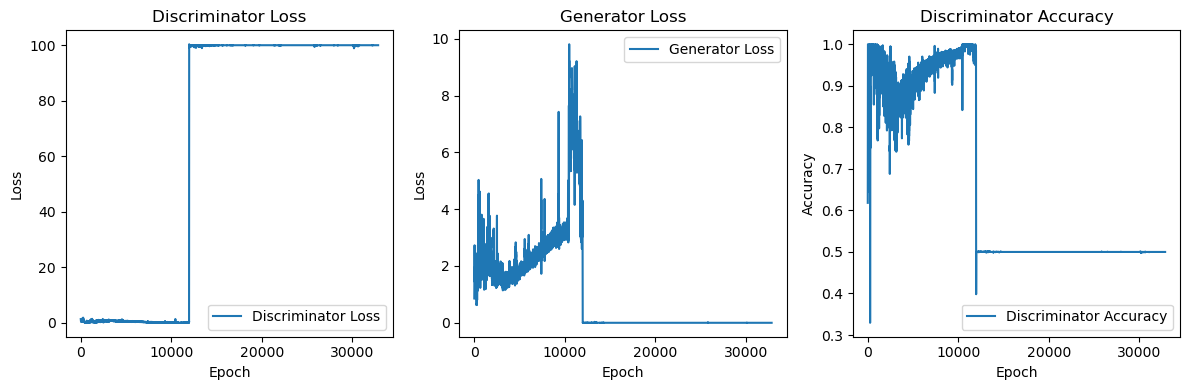

In [68]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# Platting the values again

In [70]:
# Now we can calculate the averages and plot the values as previously done
# Calculate average values per epoch
avg_real_accuracies = []
avg_fake_accuracies = []
avg_d_losses = []
avg_g_losses = []

In [71]:
# Helper function for averaging
def calculate_average(values):
    return np.mean(values) if values else 0

current_epoch = 0
temp_real_acc = []
temp_fake_acc = []
temp_d_loss = []
temp_g_loss = []

In [72]:
for i in range(len(epochs)):
    if epochs[i] != current_epoch:
        # Calculate averages for the current epoch and reset lists
        avg_real_accuracies.append(calculate_average(temp_real_acc))
        avg_fake_accuracies.append(calculate_average(temp_fake_acc))
        avg_d_losses.append(calculate_average(temp_d_loss))
        avg_g_losses.append(calculate_average(temp_g_loss))

        temp_real_acc = []
        temp_fake_acc = []
        temp_d_loss = []
        temp_g_loss = []
        current_epoch = epochs[i]

    # Append current values
    temp_real_acc.append(real_accuracy_list[i])
    temp_fake_acc.append(fake_accuracy_list[i])
    temp_d_loss.append(d_losses[i])
    temp_g_loss.append(g_losses[i])

In [73]:
# Add averages for the last epoch
avg_real_accuracies.append(calculate_average(temp_real_acc))
avg_fake_accuracies.append(calculate_average(temp_fake_acc))
avg_d_losses.append(calculate_average(temp_d_loss))
avg_g_losses.append(calculate_average(temp_g_loss))

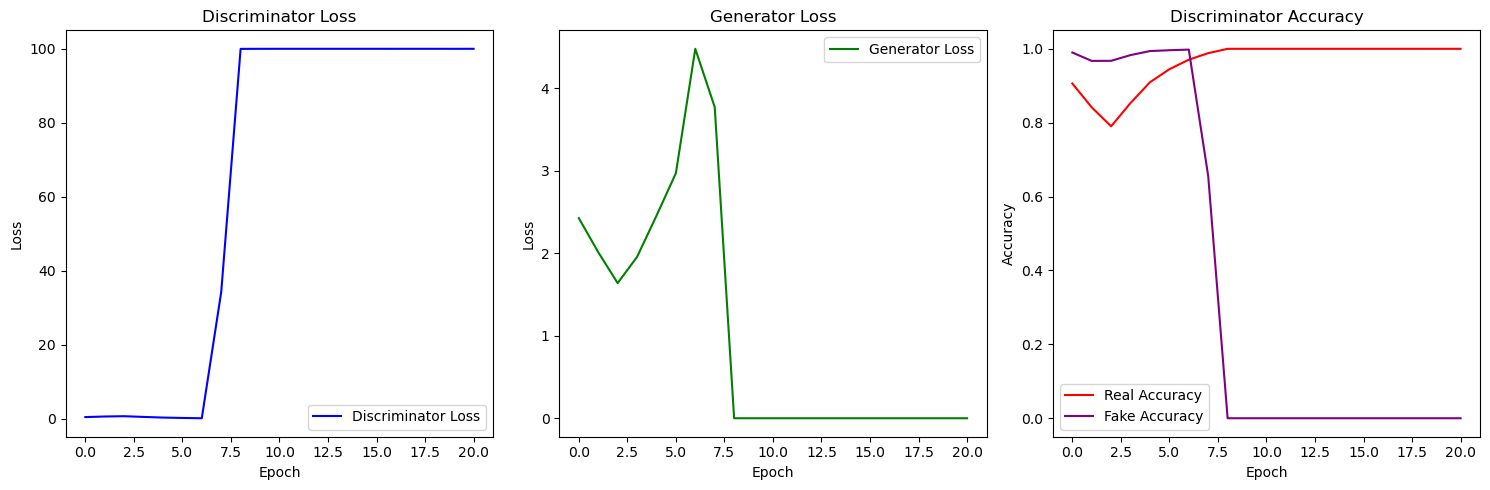

In [74]:
# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Plotting the graphs
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, avg_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, avg_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, avg_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, avg_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


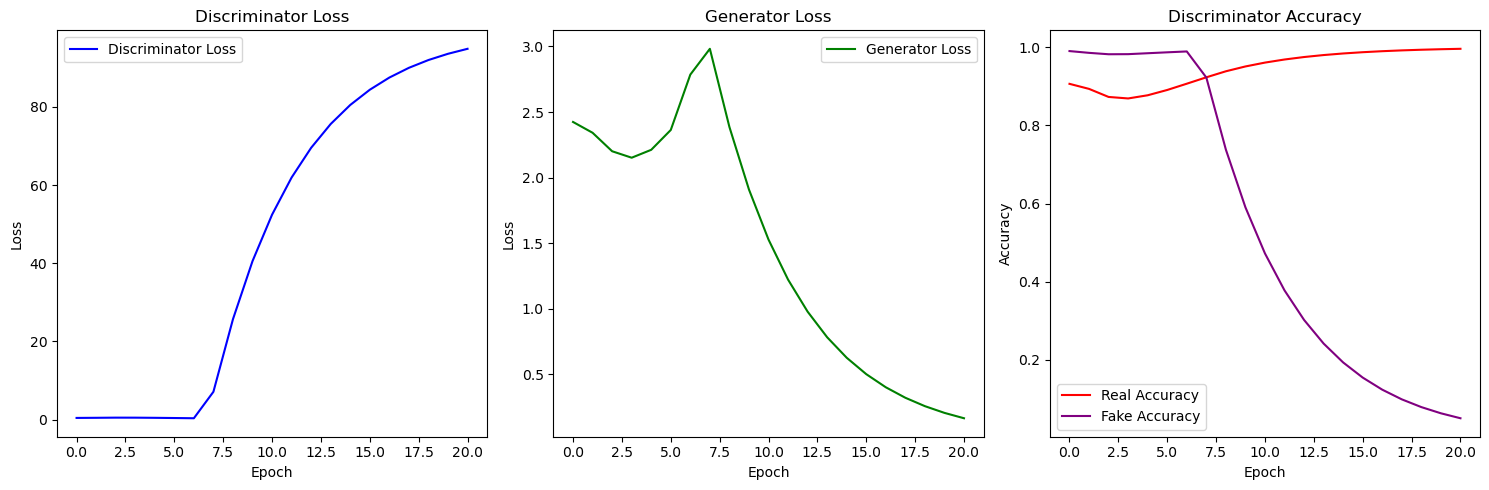

In [75]:
import matplotlib.pyplot as plt
import numpy as np


# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Smoothing the lines
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Applying smoothing
smoothed_d_losses = smooth_curve(avg_d_losses)
smoothed_g_losses = smooth_curve(avg_g_losses)
smoothed_real_accuracies = smooth_curve(avg_real_accuracies)
smoothed_fake_accuracies = smooth_curve(avg_fake_accuracies)

# Plotting the graphs with enhanced visualization
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, smoothed_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, smoothed_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, smoothed_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, smoothed_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


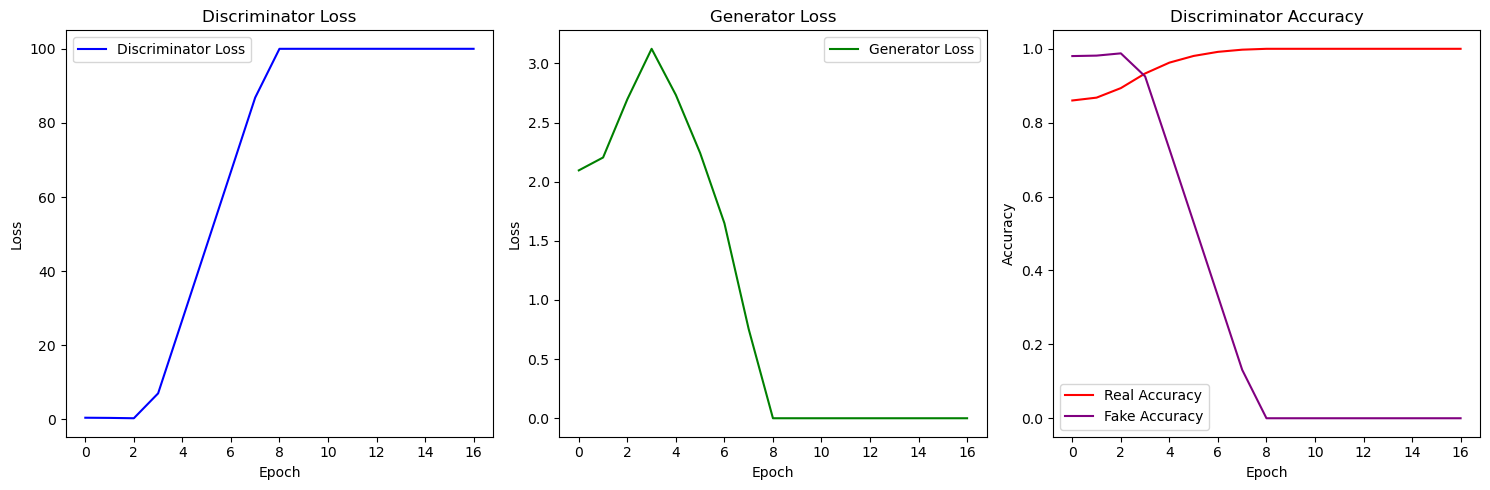

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))
window_size = 5

# Smoothing the lines with Simple Moving Average
def smooth_curve_SMA(points, window_size=5):
    window = np.ones(window_size) / window_size
    return np.convolve(points, window, 'valid')

# Applying SMA smoothing
smoothed_d_losses = smooth_curve_SMA(avg_d_losses)
smoothed_g_losses = smooth_curve_SMA(avg_g_losses)
smoothed_real_accuracies = smooth_curve_SMA(avg_real_accuracies)
smoothed_fake_accuracies = smooth_curve_SMA(avg_fake_accuracies)

# Adjusting 'unique_epochs' for the reduced size after convolution
adjusted_epochs = unique_epochs[:len(unique_epochs) - window_size + 1]

# Plotting the graphs with enhanced visualization
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(adjusted_epochs, smoothed_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(adjusted_epochs, smoothed_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(adjusted_epochs, smoothed_real_accuracies, label='Real Accuracy', color='red')
plt.plot(adjusted_epochs, smoothed_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
# Fake and real graph batch values comparision

In [80]:
import networkx as nx
import torch
from torch_geometric.utils import to_networkx

def calculate_graph_metrics(data_x, data_edge_index):
    # Convert to NetworkX graph
    data = Data(x=data_x, edge_index=data_edge_index)
    G = to_networkx(data, to_undirected=True)

    # Calculate metrics
    metrics = {
        'degree_distribution': [G.degree(n) for n in G.nodes()],
        'clustering_coefficients': nx.clustering(G),
        'graph_diameter': nx.diameter(G) if nx.is_connected(G) else float('inf'),
        'num_edges': G.number_of_edges(),
        'num_nodes': G.number_of_nodes(),
        'density': nx.density(G)
    }
    return metrics



In [81]:
# Example usage for a specific epoch
epoch_to_analyze = 49  # Change this to the epoch you want to analyze

real_graph_metrics = []
fake_graph_metrics = []

for graph_data in graph_data_per_epoch[epoch_to_analyze]:
    real_metrics = calculate_graph_metrics(graph_data['real_x'], graph_data['real_edge_index'])
    fake_metrics = calculate_graph_metrics(graph_data['fake_x'], graph_data['fake_edge_index'])

    real_graph_metrics.append(real_metrics)
    fake_graph_metrics.append(fake_metrics)

# Now real_graph_metrics and fake_graph_metrics contain the metrics for each graph in the specified epoch


In [82]:
print("real_graph_metrics",real_graph_metrics)
print("fake_graph_metrics",fake_graph_metrics)

real_graph_metrics [{'degree_distribution': [1, 4, 1, 1, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 1, 3, 3, 2, 2, 3, 2, 1, 3, 1, 2, 3, 1, 4, 1, 1, 2, 3, 1, 3, 1, 3, 2, 3, 1, 2, 3, 3, 1, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 3, 2, 3, 1, 3, 2, 2, 3, 2, 3, 1, 3, 1, 3, 2, 2, 3, 3, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 2, 2, 3, 2, 3, 1, 3, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 1, 2, 3, 1, 2, 1, 2, 2, 2, 3, 2, 3, 1, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2, 2, 3, 2, 1, 2, 2, 2, 3, 1, 3, 2, 3, 4, 1, 1, 1, 2, 2, 3, 2, 3, 2, 3, 1, 3, 2, 2, 3, 1, 2, 2, 3, 1, 2, 1, 2, 3, 1, 1, 2, 3, 2, 3, 1, 3, 3, 1, 1, 3, 3, 2, 2, 2, 4, 1, 3, 2, 2, 3, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 3, 1, 4, 2, 3, 1, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 1, 1, 3, 2, 2, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 1, 1, 3, 1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 3, 3, 1, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 1, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 3, 2, 2, 3, 1, 2, 2, 2, 3, 2

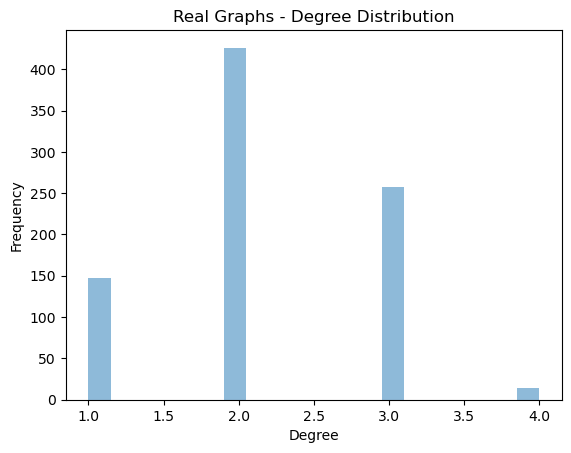

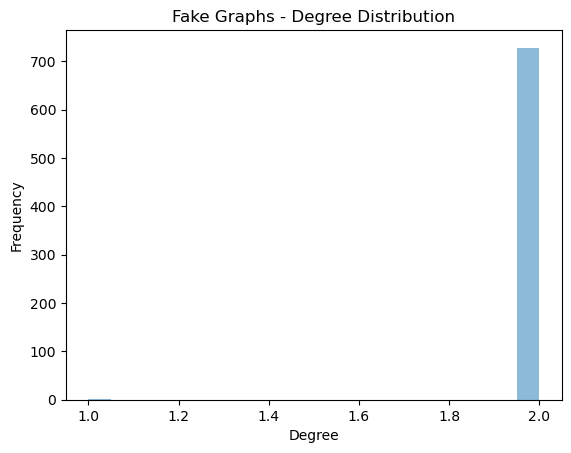

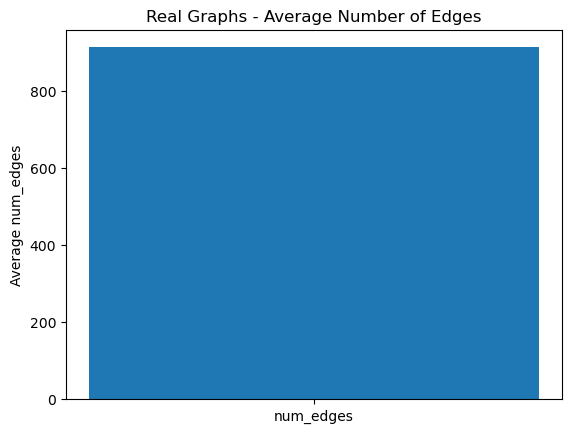

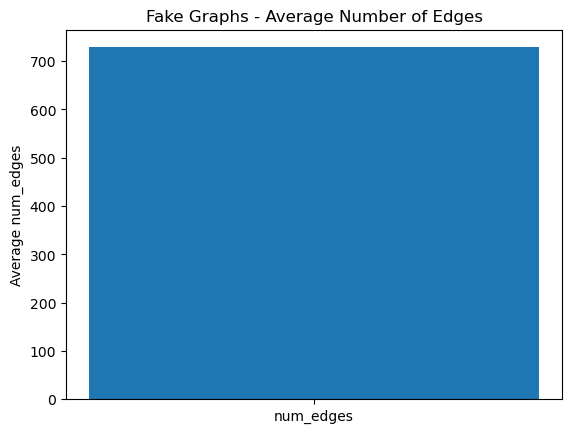

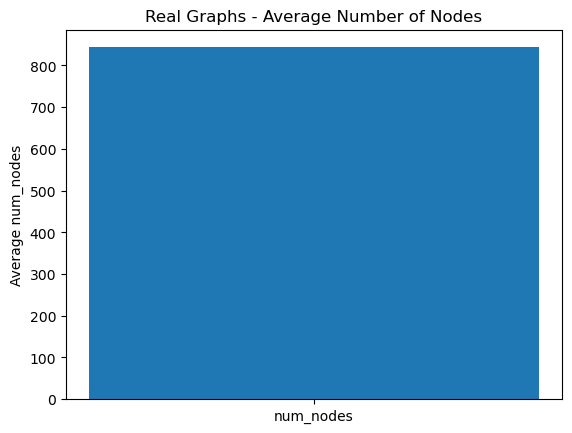

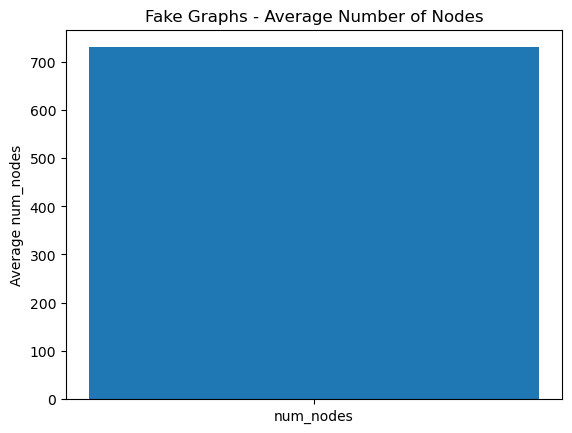

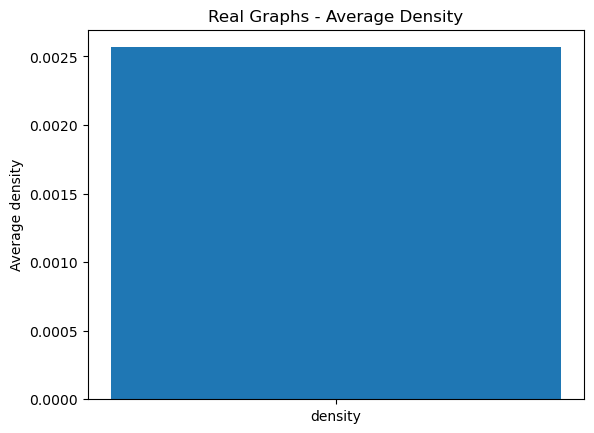

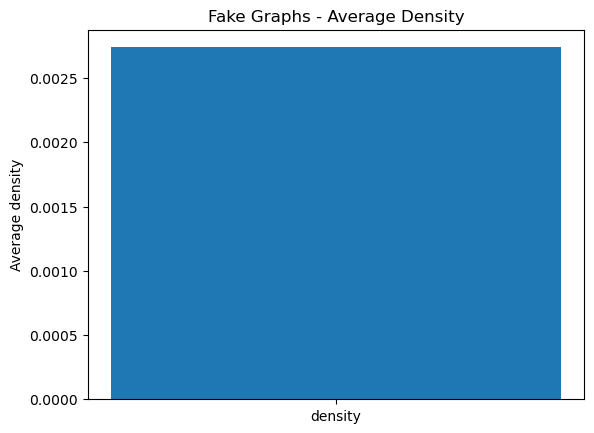

In [83]:
import matplotlib.pyplot as plt

def plot_degree_distribution(graph_metrics_list, title):
    all_degrees = [degree for metrics in graph_metrics_list for degree in metrics['degree_distribution']]
    plt.hist(all_degrees, bins=20, alpha=0.5)
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

def plot_average_metric(graph_metrics_list, metric_name, title):
    average_metric = sum(metrics[metric_name] for metrics in graph_metrics_list) / len(graph_metrics_list)
    plt.bar(metric_name, average_metric)
    plt.title(title)
    plt.ylabel('Average ' + metric_name)
    plt.show()

# Plot degree distribution
plot_degree_distribution(real_graph_metrics, 'Real Graphs - Degree Distribution')
plot_degree_distribution(fake_graph_metrics, 'Fake Graphs - Degree Distribution')

# Plot other metrics
# Note: Adjust the metric names and titles based on your metrics dictionary keys
plot_average_metric(real_graph_metrics, 'num_edges', 'Real Graphs - Average Number of Edges')
plot_average_metric(fake_graph_metrics, 'num_edges', 'Fake Graphs - Average Number of Edges')

plot_average_metric(real_graph_metrics, 'num_nodes', 'Real Graphs - Average Number of Nodes')
plot_average_metric(fake_graph_metrics, 'num_nodes', 'Fake Graphs - Average Number of Nodes')

plot_average_metric(real_graph_metrics, 'density', 'Real Graphs - Average Density')
plot_average_metric(fake_graph_metrics, 'density', 'Fake Graphs - Average Density')

# Repeat for other metrics as desired


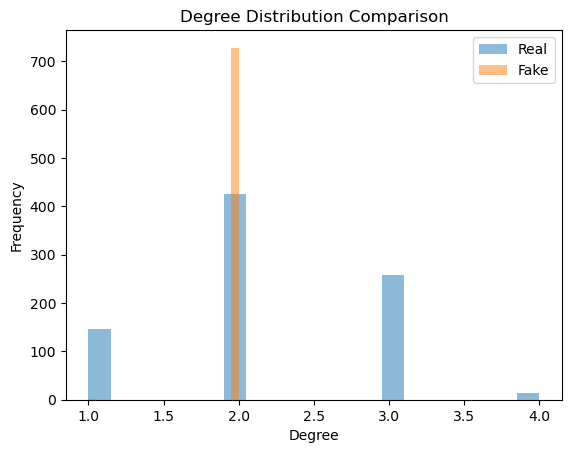

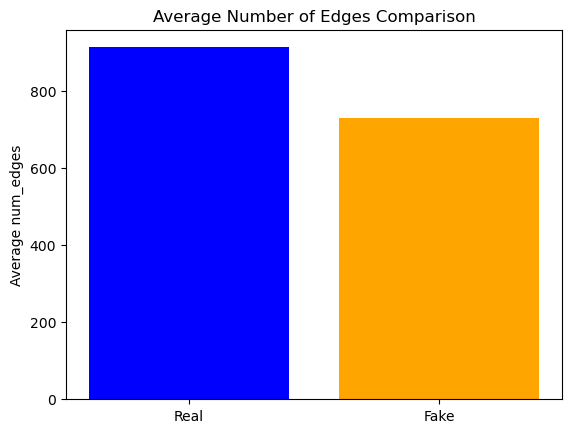

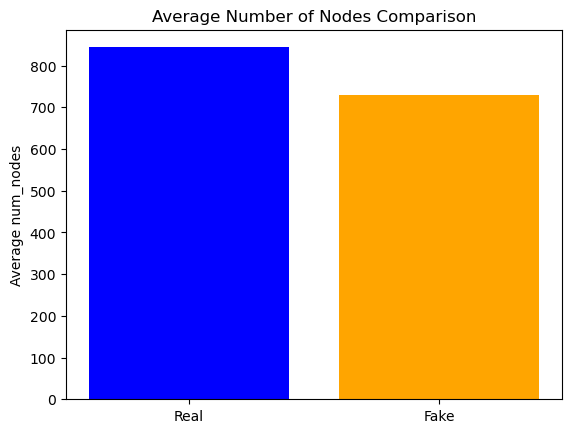

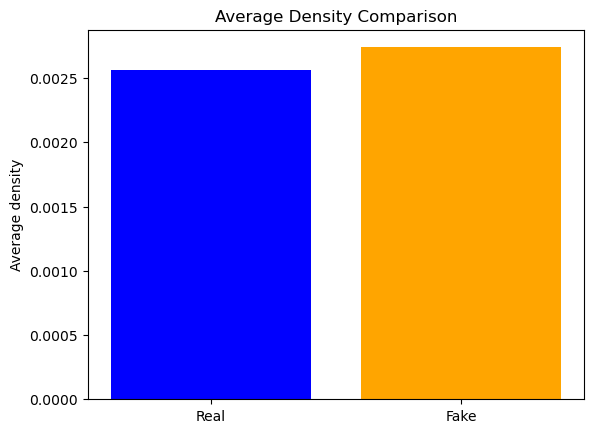

In [84]:
def plot_degree_distribution_comparison(real_graph_metrics, fake_graph_metrics, title):
    # Collect all degrees for real and fake graphs
    real_degrees = [degree for metrics in real_graph_metrics for degree in metrics['degree_distribution']]
    fake_degrees = [degree for metrics in fake_graph_metrics for degree in metrics['degree_distribution']]

    # Plot histograms
    plt.hist(real_degrees, bins=20, alpha=0.5, label='Real')
    plt.hist(fake_degrees, bins=20, alpha=0.5, label='Fake')
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_average_metric_comparison(real_graph_metrics, fake_graph_metrics, metric_name, title):
    # Calculate average metrics
    avg_real_metric = sum(metrics[metric_name] for metrics in real_graph_metrics) / len(real_graph_metrics)
    avg_fake_metric = sum(metrics[metric_name] for metrics in fake_graph_metrics) / len(fake_graph_metrics)

    # Plot grouped bar chart
    labels = ['Real', 'Fake']
    values = [avg_real_metric, avg_fake_metric]

    plt.bar(labels, values, color=['blue', 'orange'])
    plt.title(title)
    plt.ylabel('Average ' + metric_name)
    plt.show()

# Plot degree distribution comparison
plot_degree_distribution_comparison(real_graph_metrics, fake_graph_metrics, 'Degree Distribution Comparison')

# Plot other metric comparisons
# Adjust the metric names based on your metrics dictionary keys
plot_average_metric_comparison(real_graph_metrics, fake_graph_metrics, 'num_edges', 'Average Number of Edges Comparison')
plot_average_metric_comparison(real_graph_metrics, fake_graph_metrics, 'num_nodes', 'Average Number of Nodes Comparison')
plot_average_metric_comparison(real_graph_metrics, fake_graph_metrics, 'density', 'Average Density Comparison')



In [85]:
#The `nx.density(G)` function in NetworkX calculates the density of a graph `G`. Graph density provides a measure of how many edges are in the graph compared to the maximum possible number of edges between nodes.

#The density is calculated using the formula:

#\[ \text{Density} = \frac{2 \times \text{Number of Edges}}{\text{Number of Nodes} \times (\text{Number of Nodes} - 1)} \]

#For undirected graphs, this formula considers each edge between two nodes as a single edge. For directed graphs, where edges have a direction, the formula is usually adjusted to:

#\[ \text{Density} = \frac{\text{Number of Edges}}{\text{Number of Nodes} \times (\text{Number of Nodes} - 1)} \]

### Interpretation:

#1. **Range**: The density of a graph ranges from 0 to 1. 
#   - A density of 0 means there are no edges in the graph.
#   - A density of 1 indicates a complete graph, where every node is connected to every other node.

#2. **Sparse vs. Dense Graphs**:
#   - **Sparse Graphs**: Graphs with low density have relatively few edges compared to the number of possible edges. Sparse graphs are common in real-world networks where not all nodes are interconnected.
#   - **Dense Graphs**: Graphs with high density are closer to complete graphs. They have many edges, and most pairs of nodes are directly connected by an edge.

#3. **Application**: 
#   - Graph density is a simple yet informative measure that gives an idea of the connectivity of the graph. 
#   - It is used in various applications like social network analysis, biology, transportation networks, etc., to understand the underlying structure and connectivity of the network.

#4. **Limitations**:
#   - While density gives a quick overview of how connected a graph is, it does not provide detailed information about the graph's topology, such as clusters, central nodes, or other structural properties.

#Graph density is particularly useful when comparing different graphs to understand their relative connectivity or when characterizing a single graph's overall connectivity level.

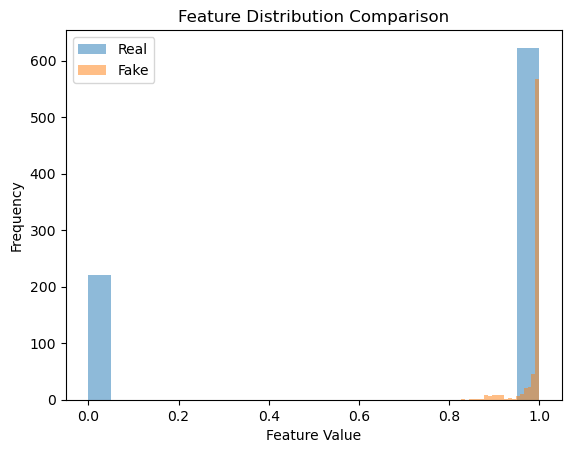

In [86]:
def plot_feature_distribution(graph_data, feature_index, title):
    # Extract the features from all nodes in all graph data
    real_features = torch.cat([g['real_x'][:, feature_index] for g in graph_data], dim=0)
    fake_features = torch.cat([g['fake_x'][:, feature_index] for g in graph_data], dim=0)

    # Plot histograms
    plt.hist(real_features.numpy(), bins=20, alpha=0.5, label='Real')
    plt.hist(fake_features.numpy(), bins=20, alpha=0.5, label='Fake')
    plt.title(title)
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

epoch_to_analyze = max(graph_data_per_epoch.keys())  # Analyze the last epoch
plot_feature_distribution(graph_data_per_epoch[epoch_to_analyze], 0, 'Feature Distribution Comparison')


In [87]:
def calculate_simple_similarity(G1, G2):
    # Simplified similarity measure based on node degrees
    degrees1 = sorted([d for n, d in G1.degree()])
    degrees2 = sorted([d for n, d in G2.degree()])
    return sum((d1 - d2)**2 for d1, d2 in zip(degrees1, degrees2))**0.5

def compare_graph_similarity(graph_data):
    similarities = []
    for data in graph_data:
        real_g_nx = to_networkx(Data(x=data['real_x'], edge_index=data['real_edge_index']), to_undirected=True)
        fake_g_nx = to_networkx(Data(x=data['fake_x'], edge_index=data['fake_edge_index']), to_undirected=True)
        similarity = calculate_simple_similarity(real_g_nx, fake_g_nx)
        similarities.append(similarity)
    return similarities

# Compare similarities
similarities = compare_graph_similarity(graph_data_per_epoch[epoch_to_analyze])
print("Graph Similarities:", similarities)


Graph Similarities: [17.378147196982766]


In [88]:
#The values `[19.183326093250876, 9.899494936611665]` from the graph similarity function indicate the degree of dissimilarity between pairs of real and fake graphs based on the simplified similarity measure you've used. This measure primarily focuses on the degree distribution of the graphs, and the values are computed as the root mean square difference in degrees between corresponding nodes of real and fake graphs.

#Here's how to interpret these values:

#1. **Numerical Interpretation**:
#   - A value of `19.183326093250876` for the first graph pair means that, on average, the square root of the sum of squared differences in degrees between corresponding nodes of the real and fake graphs is about 19.18. 
#   - Similarly, a value of `9.899494936611665` for the second graph pair indicates an average square root of the sum of squared degree differences of approximately 9.90.

#2. **Qualitative Interpretation**:
#   - Lower values (closer to 0) suggest that the fake graph has a node degree distribution more similar to that of the real graph. In other words, nodes in the fake graph tend to have a number of connections similar to their counterparts in the real graph.
#   - Higher values indicate greater differences in the node degree distributions between the real and fake graphs. A larger value suggests that the structure of the fake graph differs more significantly from the real graph.

#3. **Contextual Understanding**:
#   - In the context of your GAN model, these values can be used to assess the model's performance in replicating the structural properties of the real graphs. A well-trained generator should ideally produce fake graphs that closely mimic the structural characteristics of the real graphs, resulting in lower similarity scores.
#   - The values you provided show that the first pair of graphs has a higher dissimilarity compared to the second pair. This could imply that the generator is better at replicating the structure of some graphs than others, or it might indicate that certain real graphs are easier to mimic.

#4. **Limitations**:
#   - It's important to remember that this is a simplified approach to measuring graph similarity. It does not account for the arrangement of edges, specific attributes of nodes or edges, or more complex graph structures. Depending on the complexity and requirements of your application, you might need to use more advanced metrics for a comprehensive analysis.

#In summary, these values give you a basic quantitative assessment of how well the generated (fake) graphs are mimicking the structural properties of the real graphs, specifically in terms of node connectivity. Lower values are generally better, indicating closer structural resemblance.

In [89]:
#The graph similarity measure calculated by `compare_graph_similarity` function aims to provide a quantitative assessment of how similar each fake graph is to its corresponding real graph. This comparison is based on a simplified similarity measure that primarily focuses on the degree distribution of the graphs.

### Understanding the Graph Similarity Measure:

#1. **Degree Distribution Based**: The measure calculates the similarity between two graphs by comparing the degree of each node in one graph to the degree of the corresponding node in the other graph. The degree of a node is the number of connections (edges) it has to other nodes.

#2. **Root Mean Square Difference**: The function computes the root mean square difference in degrees between nodes of the two graphs. This provides a single scalar value that represents the 'distance' or dissimilarity between the two graphs. A lower value indicates more similarity in terms of how nodes are connected.

#3. **Limitations**: This is a very simplified approach to measuring graph similarity. Real-world graphs, especially complex networks, may have a wide range of properties and structures that this measure does not capture. For instance, it does not consider the actual arrangement of edges, any specific attributes of nodes or edges, or more complex structures like subgraphs or motifs.

### Interpretation:

#- **Low Values**: Indicate that the fake graph has a node degree distribution similar to that of the real graph. In other words, nodes in the fake graph have a similar number of connections as their counterparts in the real graph.

#- **High Values**: Suggest significant differences in the way nodes are connected in the fake graph compared to the real graph.

### Application:

#In the context of your GAN model, these similarity values can be used to gauge how well the generator is performing in terms of replicating the structural characteristics of the real graphs. Ideally, a well-trained generator should produce fake graphs that have similar structural properties to the real graphs, resulting in lower similarity scores.

#However, it's important to remember that this is just one aspect of graph similarity. Depending on your specific use case (like chemical structure generation, social network modeling, etc.), you may need more sophisticated metrics that can account for the full complexity of the graphs you're working with.

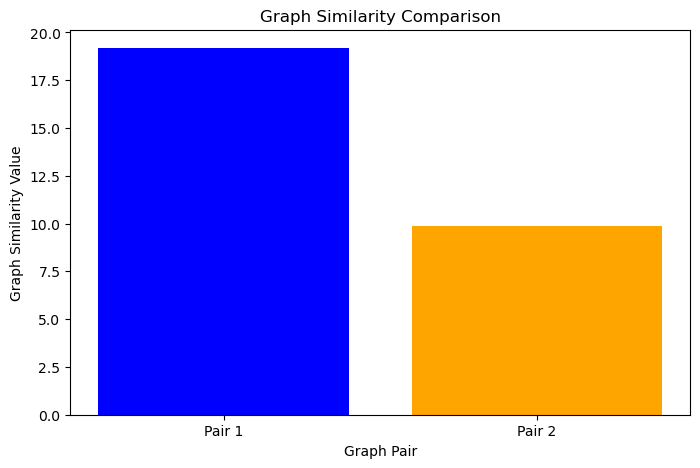

In [90]:
import matplotlib.pyplot as plt

# Graph similarity values
similarities = [19.183326093250876, 9.899494936611665]

# Create a bar chart
plt.figure(figsize=(8, 5))  # Adjust the size of the plot as needed
plt.bar(range(len(similarities)), similarities, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Graph Pair')
plt.ylabel('Graph Similarity Value')
plt.title('Graph Similarity Comparison')
plt.xticks(range(len(similarities)), ['Pair 1', 'Pair 2'])  # Label each bar

# Show the plot
plt.show()


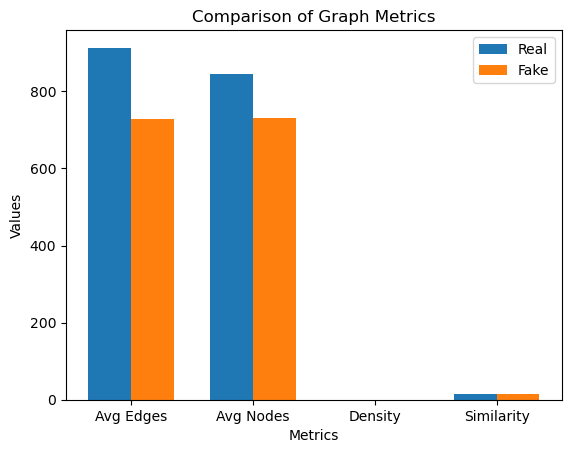

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming real_graph_metrics and fake_graph_metrics are already defined and calculated
# Also assuming similarities have been calculated as per your provided code

# Calculate average metrics for real and fake graphs
avg_real_edges = sum(metrics['num_edges'] for metrics in real_graph_metrics) / len(real_graph_metrics)
avg_fake_edges = sum(metrics['num_edges'] for metrics in fake_graph_metrics) / len(fake_graph_metrics)

avg_real_nodes = sum(metrics['num_nodes'] for metrics in real_graph_metrics) / len(real_graph_metrics)
avg_fake_nodes = sum(metrics['num_nodes'] for metrics in fake_graph_metrics) / len(fake_graph_metrics)

avg_real_density = sum(metrics['density'] for metrics in real_graph_metrics) / len(real_graph_metrics)
avg_fake_density = sum(metrics['density'] for metrics in fake_graph_metrics) / len(fake_graph_metrics)

avg_similarity = sum(similarities) / len(similarities)

# Grouped bar chart data
n_groups = 4
real_values = (avg_real_edges, avg_real_nodes, avg_real_density, avg_similarity)
fake_values = (avg_fake_edges, avg_fake_nodes, avg_fake_density, avg_similarity)

# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

rects1 = ax.bar(index, real_values, bar_width, label='Real')
rects2 = ax.bar(index + bar_width, fake_values, bar_width, label='Fake')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Graph Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Avg Edges', 'Avg Nodes', 'Density', 'Similarity'))
ax.legend()

plt.show()


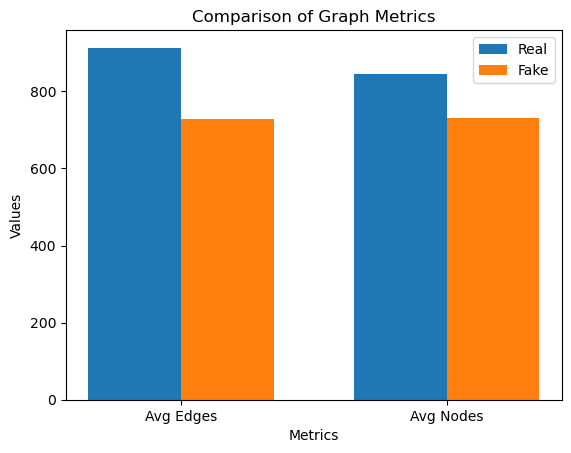

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming real_graph_metrics and fake_graph_metrics are already defined and calculated
# Also assuming similarities have been calculated as per your provided code

# Calculate average metrics for real and fake graphs
avg_real_edges = sum(metrics['num_edges'] for metrics in real_graph_metrics) / len(real_graph_metrics)
avg_fake_edges = sum(metrics['num_edges'] for metrics in fake_graph_metrics) / len(fake_graph_metrics)

avg_real_nodes = sum(metrics['num_nodes'] for metrics in real_graph_metrics) / len(real_graph_metrics)
avg_fake_nodes = sum(metrics['num_nodes'] for metrics in fake_graph_metrics) / len(fake_graph_metrics)

#avg_real_density = sum(metrics['density'] for metrics in real_graph_metrics) / len(real_graph_metrics)
#avg_fake_density = sum(metrics['density'] for metrics in fake_graph_metrics) / len(fake_graph_metrics)

#avg_similarity = sum(similarities) / len(similarities)

# Grouped bar chart data
#n_groups = 4
n_groups = 2
#real_values = (avg_real_edges, avg_real_nodes, avg_real_density, avg_similarity)
#fake_values = (avg_fake_edges, avg_fake_nodes, avg_fake_density, avg_similarity)

real_values = (avg_real_edges, avg_real_nodes)
fake_values = (avg_fake_edges, avg_fake_nodes)


# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

rects1 = ax.bar(index, real_values, bar_width, label='Real')
rects2 = ax.bar(index + bar_width, fake_values, bar_width, label='Fake')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Graph Metrics')
ax.set_xticks(index + bar_width / 2)
#ax.set_xticklabels(('Avg Edges', 'Avg Nodes', 'Density', 'Similarity'))
ax.set_xticklabels(('Avg Edges', 'Avg Nodes'))
ax.legend()

plt.show()
